In [1]:
import os.path
import os
import sys
from matplotlib import rcParams
from matplotlib.animation import ArtistAnimation
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

from datetime import datetime, timedelta
from siphon.cdmr import Dataset
import numpy as np
import numpy.ma as ma
import netCDF4

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

projection = ccrs.LambertConformal(central_longitude=262.5, 
                                   central_latitude=38.5, 
                                   standard_parallels=(38.5, 38.5),
                                    globe=ccrs.Globe(semimajor_axis=6371229,semiminor_axis=6371229))

from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
import scipy.ndimage as ndimage
import scipy.signal as signal
from scipy.interpolate import interp1d

import metpy
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import sky_cover
from metpy.calc import (bunkers_storm_motion, bulk_shear, dewpoint, dewpoint_from_relative_humidity, dry_lapse, moist_lapse,
                        vapor_pressure, saturation_vapor_pressure, wind_speed, wind_direction, pressure_to_height_std,
                        mixing_ratio, cape_cin, wind_components, height_to_pressure_std, equivalent_potential_temperature,
                        parcel_profile, precipitable_water, storm_relative_helicity, mean_pressure_weighted, 
                        most_unstable_cape_cin, most_unstable_parcel, supercell_composite, significant_tornado, get_layer,
                        relative_humidity_from_dewpoint, surface_based_cape_cin, mixed_layer_cape_cin,
                        surface_based_cape_cin, potential_temperature, wind_direction, add_pressure_to_height,
                        add_height_to_pressure, divergence, vorticity, lat_lon_grid_deltas, mixed_parcel,
                        most_unstable_parcel, lcl, lfc, mixing_ratio_from_relative_humidity, el,  cape_cin,
                        height_to_pressure_std, dewpoint_from_relative_humidity, dewpoint_from_specific_humidity)
from metpy.units import units
from metpy.plots import SkewT, Hodograph
from metpy.interpolate import interpolate_1d as metinterp, log_interpolate_1d
from metpy.calc.tools import get_layer, get_layer_heights
from metpy.plots.declarative import BarbPlot, ContourPlot, FilledContourPlot, MapPanel, PanelContainer, PlotObs

import sharppy
import sharppy.sharptab.profile as profile
import sharppy.sharptab.interp as interp
import sharppy.sharptab.winds as winds
import sharppy.sharptab.utils as utils
import sharppy.sharptab.params as params
import sharppy.sharptab.thermo as thermo

import pickle
import csv
import pandas as pd
import xarray as xr
import seaborn as sns
from scipy import stats
import s3fs
import matplotlib.colors as colors

import glob
import os

import dataclasses
import datetime

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

# Pull HRRR Vertical Profiles at Given Time/Location

hrrr.t00z.wrfnatf00.grib2 



C:\Users\kyled\AppData\Local\Temp\ipykernel_18088\490752631.py:86: UserWarning: Relative humidity >120%, ensure proper units.
  Td=dewpoint_from_specific_humidity(P* units('hPa'),T* units('kelvin'),q)
D:\Anaconda3\envs\THESIS\lib\site-packages\metpy\calc\thermo.py:1396: RuntimeWarning: divide by zero encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)
D:\Anaconda3\envs\THESIS\lib\site-packages\metpy\calc\thermo.py:1397: RuntimeWarning: invalid value encountered in divide
  return mpconsts.nounit.zero_degc + 243.5 * val / (17.67 - val)


35.23 -97.47
35.2345730551477 -97.47274057612748 



D:\Anaconda3\envs\THESIS\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl-old/201905/20190523/catalog.html?dataset=rap130anl-old/201905/20190523/rap_130_20190523_0000_000.grb2 returned HTML. Changing to: https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl-old/201905/20190523/catalog.xml?dataset=rap130anl-old/201905/20190523/rap_130_20190523_0000_000.grb2
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


We have the file we need1!


D:\Anaconda3\envs\THESIS\lib\site-packages\numpy\lib\function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)


Text(0.4, 1.0, 'KOUN Observed (Blue) \n HRRR (Red), RAP (Green) \n 5/23/2019 0Z Norman, OK')

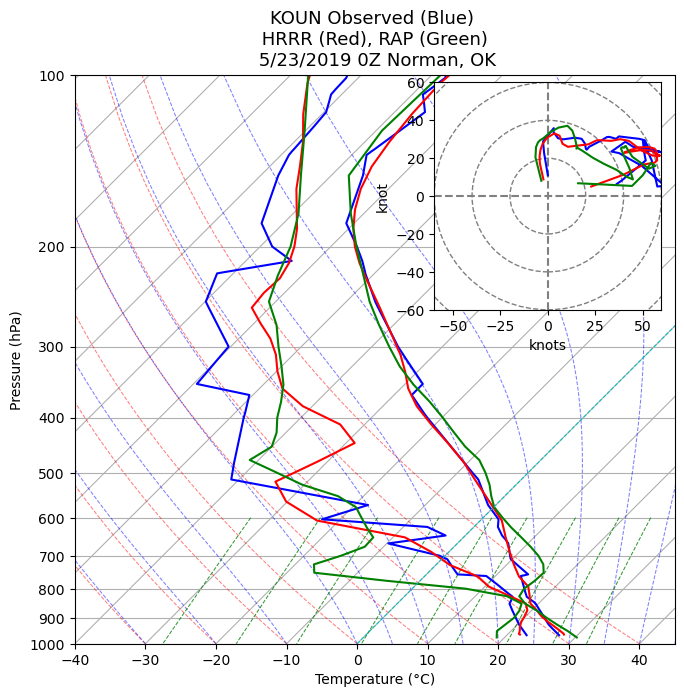

In [9]:
#LAMONT: 36.62, -97.48
#NORMAN: 35.23, -97.47
#SPRINGFIELD: 37.236, -93.402

#TORUS1529: 35.1813, -97.4391
#TORUS1813: 35.6668, -97.3128
#TORUS2141: 34.7526, -97.5986
#TORUS2345: 35.0158, -97.3244

##############################
year=2019
month=5
day = 23
hour = 0

cenlat,cenlon = 35.23, -97.47
##############################
#read in the data
col_names = ['pressure', 'height', 'temperature', 'dewpoint', 'RH', 'MIXR', 'direction', 'speed']

#df1 = pd.read_csv('D:/THESIS/5-22_TORUS_Data/UpperAirRadiosonde/UnivWyomingSoundings/KLMN_15Z_22May2019.txt', skiprows=5, usecols=[0, 1, 2, 3, 4, 5, 6, 7], names = col_names, delim_whitespace=True)
#df1 = pd.read_csv('D:/THESIS/5-22_TORUS_Data/UpperAirRadiosonde/UnivWyomingSoundings/KLMN_18Z_22May2019.txt', skiprows=5, usecols=[0, 1, 2, 3, 4, 5, 6, 7], names = col_names, delim_whitespace=True)
#df1 = pd.read_csv('D:/THESIS/5-22_TORUS_Data/UpperAirRadiosonde/UnivWyomingSoundings/KLMN_21Z_22May2019.txt', skiprows=5, usecols=[0, 1, 2, 3, 4, 5, 6, 7], names = col_names, delim_whitespace=True)
#df1 = pd.read_csv('D:/THESIS/5-22_TORUS_Data/UpperAirRadiosonde/UnivWyomingSoundings/KLMN_00Z_23May2019.txt', skiprows=5, usecols=[0, 1, 2, 3, 4, 5, 6, 7], names = col_names, delim_whitespace=True)
#df1 = pd.read_csv('D:/THESIS/5-22_TORUS_Data/UpperAirRadiosonde/UnivWyomingSoundings/KLMN_03Z_23May2019.txt', skiprows=5, usecols=[0, 1, 2, 3, 4, 5, 6, 7], names = col_names, delim_whitespace=True)

#df1 = pd.read_csv('D:/THESIS/5-22_TORUS_Data/UpperAirRadiosonde/UnivWyomingSoundings/KSGF_18Z_22May2019.txt', skiprows=5, usecols=[0, 1, 2, 3, 4, 5, 6, 7], names = col_names, delim_whitespace=True)
#df1 = pd.read_csv('D:/THESIS/5-22_TORUS_Data/UpperAirRadiosonde/UnivWyomingSoundings/KSGF_21Z_22May2019.txt', skiprows=5, usecols=[0, 1, 2, 3, 4, 5, 6, 7], names = col_names, delim_whitespace=True)
#df1 = pd.read_csv('D:/THESIS/5-22_TORUS_Data/UpperAirRadiosonde/UnivWyomingSoundings/KSGF_00Z_23May2019.txt', skiprows=5, usecols=[0, 1, 2, 3, 4, 5, 6, 7], names = col_names, delim_whitespace=True)

#df1 = pd.read_csv('D:/THESIS/5-22_TORUS_Data/UpperAirRadiosonde/UnivWyomingSoundings/KOUN_18Z_22May2019.txt', skiprows=5, usecols=[0, 1, 2, 3, 4, 5, 6, 7], names = col_names, delim_whitespace=True)
#df1 = pd.read_csv('D:/THESIS/5-22_TORUS_Data/UpperAirRadiosonde/UnivWyomingSoundings/KOUN_21Z_22May2019.txt', skiprows=5, usecols=[0, 1, 2, 3, 4, 5, 6, 7], names = col_names, delim_whitespace=True)
df1 = pd.read_csv('D:/THESIS/5-22_TORUS_Data/UpperAirRadiosonde/UnivWyomingSoundings/KOUN_00Z_23May2019.txt', skiprows=4, usecols=[0, 1, 2, 3, 4, 5, 6, 7], names = col_names, delim_whitespace=True)

col_names1 = ['temp', 'RH', 'dewpoint', 'pres', 'direction', 'speed', 'height']
df2 = pd.read_csv('D:/THESIS/5-22_TORUS_Data/UpperAirRadiosonde/NOAA_NSSL Mobile Radiosonde Data/5-22/FF_1529.csv', names = col_names1)
#df2 = pd.read_csv('D:/THESIS/5-22_TORUS_Data/UpperAirRadiosonde/NOAA_NSSL Mobile Radiosonde Data/5-22/FF_1813.csv', names = col_names1)
#df2 = pd.read_csv('D:/THESIS/5-22_TORUS_Data/UpperAirRadiosonde/NOAA_NSSL Mobile Radiosonde Data/5-22/FF_2141.csv', names = col_names1)
#df2 = pd.read_csv('D:/THESIS/5-22_TORUS_Data/UpperAirRadiosonde/NOAA_NSSL Mobile Radiosonde Data/5-22/FF_2345.csv', names = col_names1)
##############################
Hour = hour

time_start = datetime.datetime(int(year), int(month), int(day), int(hour), 0) # Our specified time
hour = time_start.hour
if hour < 10:
    hour = '0'+str(hour)
else:
    hour=str(hour)
day = time_start.day
if day < 10:
    day = '0'+str(day)
else:
    day=str(day)
month = time_start.month
if month < 10:
    month = '0'+str(month)
else:
    month=str(month)
year=str(year)

timeIN=str(year+month+day)

####################################
# HRRR SOUNDING BELOW HERE
######################################
fs = s3fs.S3FileSystem(anon=True)
#fs.ls('s3://noaa-hrrr-bdp-pds/hrrr.20190522/conus/')
files = np.array(fs.ls('s3://noaa-hrrr-bdp-pds/hrrr.'+timeIN+'/conus/'))
fileN = np.where(files=='noaa-hrrr-bdp-pds/hrrr.'+timeIN+'/conus/hrrr.t'+hour+'z.wrfnatf00.grib2')
fs.get(files[fileN[0][0]], files[fileN[0][0]].split('/')[-1])
fname=files[fileN[0][0]].split('/')[-1]
c=xr.open_dataset(fname, filter_by_keys={'typeOfLevel': 'hybrid'})
print(fname, "\n")

lev=np.asarray(c.variables['hybrid'][:]) # 0 = lowest level, 49 = highest level
lat=np.asarray(c.variables['latitude'])
lon=((np.asarray(c.variables['longitude'])*-1)+360)*-1

T=np.asarray(c.variables['t'][:]) #K #temperature
q=np.asarray(c.variables['q'][:]) # kg kg**-1 #specific humidity
u=np.asarray(c.variables['u'][:]) #m/s #u wind
v=np.asarray(c.variables['v'][:]) #m/s #v wind
P=(np.asarray(c.variables['pres'][:])/100.) #hPa #pressure
Hgt=np.asarray(c.variables['gh'][:]) #geopotential meters #geopotential height
w=(np.asarray(c.variables['w'][:])) #Pa s**-1 #vertical velocity
Td=dewpoint_from_specific_humidity(P* units('hPa'),T* units('kelvin'),q)

dlon = np.abs(lon - cenlon)
dlat = np.abs(lat - cenlat)
cordmax = np.maximum(dlon,dlat)
x,y=np.where(cordmax == np.min(cordmax))
x=x[0]
y=y[0]

print(cenlat,cenlon)
print(lat[x][y],lon[x][y], "\n")

P_sounding = P[:,x,y]
T_sounding = (T[:,x,y]* units.kelvin).to(units.degC)
Td_sounding = Td[:,x,y]
H_sounding = Hgt[:,x,y]
U_sounding = (u[:,x,y]* units.meter_per_second).to(units.knot)
V_sounding = (v[:,x,y]* units.meter_per_second).to(units.knot)

SoundingOut = [P_sounding, T_sounding.magnitude, Td_sounding.magnitude, H_sounding, U_sounding.magnitude, V_sounding.magnitude]
dfSounding = pd.DataFrame(SoundingOut)
dfSounding2 = dfSounding.T
df3 = dfSounding2
#print(dfSounding2)

####################################
# RAP SOUNDING BELOW HERE
######################################
file = 0

## 1    
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need1!")
    except:
        file = 0
        print("No file yet...")

## 2
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-ruc130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=ruc130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/ruc_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need2!")
    except:
        file = 0
        print("No file yet...")
        
#######################
latest_ds = list(cat.datasets.values())[0]
#print(latest_ds.access_urls)
ncss = NCSS(latest_ds.access_urls['NetcdfSubset'])

query = ncss.query()
query.variables('Vertical_velocity_pressure_isobaric').variables('u-component_of_wind_isobaric').variables('v-component_of_wind_isobaric').variables('Pressure_surface').variables('Dewpoint_temperature_height_above_ground').variables('Temperature_height_above_ground').variables('Geopotential_height_isobaric').variables('Geopotential_height_surface').variables('u-component_of_wind_height_above_ground').variables('v-component_of_wind_height_above_ground').variables('Relative_humidity_isobaric').variables('Temperature_isobaric')
query.add_lonlat().lonlat_box(cenlon-5.1, cenlon +5.1, cenlat-5.1, cenlat+5.1)
data1 = ncss.get_data(query)
dtime = data1.variables['Geopotential_height_isobaric'].dimensions[0]
dlev = data1.variables['Geopotential_height_isobaric'].dimensions[1]
dlat = data1.variables['Geopotential_height_isobaric'].dimensions[2] #(array shape is [208, 185], min = 0.00491, max = 14.87159)
dlon = data1.variables['Geopotential_height_isobaric'].dimensions[3] #(array shape is [208, 185], min = 0.000812, max = 21.69921)

#create 3D arrays for the entire domain of needed variables with values from the RAP 
SFCP = (np.asarray(data1.variables['Pressure_surface'][:])/100.) * units('hPa')
Td = (np.asarray(data1.variables['Dewpoint_temperature_height_above_ground'][:]) * units('kelvin')).to('degC')
T = np.asarray(data1.variables['Temperature_height_above_ground'][:]) * units('kelvin')
hgt = np.asarray(data1.variables['Geopotential_height_isobaric'][:]) * units('meter')
sfc_hgt = np.asarray(data1.variables['Geopotential_height_surface'][:]) * units('meter')
uwnd = np.asarray(data1.variables['u-component_of_wind_isobaric'][:]) * units('m/s')
vwnd = np.asarray(data1.variables['v-component_of_wind_isobaric'][:]) * units('m/s')
Temp_up = np.asarray(data1.variables['Temperature_isobaric'][:]) * units('kelvin')
VVEL_up = np.asarray(data1.variables['Vertical_velocity_pressure_isobaric'][:]) * units('Pa/s')
RH_up = np.asarray(data1.variables['Relative_humidity_isobaric'][:])
usfc = np.asarray(data1.variables['u-component_of_wind_height_above_ground'][:]) * units('m/s')
vsfc = np.asarray(data1.variables['v-component_of_wind_height_above_ground'][:]) * units('m/s')
# Get the dimension data
lats_r = data1.variables[dlat][:] #(shape = (208,), min = -317.99274, max = 2485.8223)
lons_r= data1.variables[dlon][:] #(shape = (185,), min = -1639.0303, max = 853.2497)

lev = (np.asarray(data1.variables[dlev][:])/100.) * units('hPa')

flon = float(cenlon)
flat = float(cenlat)
    # Set up our array of latitude and longitude values and transform to the desired projection.
crs = ccrs.PlateCarree()
crlons, crlats = np.meshgrid(lons_r[:]*1000, lats_r[:]*1000)
#trlatlons = crs.transform_points(ccrs.LambertConformal(central_longitude=flon, central_latitude=(flat-7.5), standard_parallels=None),crlons,crlats)
trlatlons = crs.transform_points(ccrs.LambertConformal(central_longitude=flon, central_latitude=(flat-7.5)),crlons,crlats)
#trlatlons = crs.transform_points(ccrs.LambertConformal(),crlons,crlats)
#trlatlons = crs.transform_points(ccrs.LambertConformal(central_longitude=-98, central_latitude=35, standard_parallels=(25.,25.)),crlons,crlats)
#trlatlons = crs.transform_points(ccrs.LambertConformal(central_longitude=-98, central_latitude=35, standard_parallels=None),crlons,crlats)
trlons = trlatlons[:,:,0]
trlats = trlatlons[:,:,1]
dlon = np.abs(trlons - cenlon)
dlat = np.abs(trlats - cenlat)
ilon = np.where(dlon == np.min(dlon)) #array position with minimal difference between gridpoint lon and input lon
ilat = np.where(dlat == np.min(dlat)) #array position with minimal difference between gridpoint lat and input lat

RH_prof = RH_up[0,:,ilat[0][0], ilon[1][0]]
Tdc_up = dewpoint_from_relative_humidity(Temp_up[0,:,ilat[0][0], ilon[1][0]],RH_up[0,:,ilat[0][0], ilon[1][0]]/100)
Omega = VVEL_up[0,:,ilat[0][0], ilon[1][0]]

#Create vertical profiles at the lat/lon point of interest
p_sounding = np.sort(np.append(lev, SFCP[0,ilat[0][0], ilon[1][0]]))
ind = np.where(p_sounding >= SFCP[0,ilat[0][0], ilon[1][0]])[0][0]
hgt_sounding = np.insert(hgt[0,:,ilat[0][0], ilon[1][0]].magnitude, ind, sfc_hgt[0,ilat[0][0], ilon[1][0]].magnitude) * hgt.units
T_sounding = (np.insert(Temp_up[0,:,ilat[0][0], ilon[1][0]].magnitude, ind, T[0,0,ilat[0][0], ilon[1][0]].magnitude) * T.units).to(Tdc_up.units)
Td_sounding = np.insert(Tdc_up.magnitude, ind, Td[0,0,ilat[0][0], ilon[1][0]].magnitude) * Tdc_up.units
u_sounding = np.insert(uwnd[0,:,ilat[0][0], ilon[1][0]].magnitude, ind, usfc[0,0,ilat[0][0], ilon[1][0]].magnitude) * usfc.units
v_sounding = np.insert(vwnd[0,:,ilat[0][0], ilon[1][0]].magnitude, ind, vsfc[0,0,ilat[0][0], ilon[1][0]].magnitude) * usfc.units
p_skewt = p_sounding[p_sounding <= SFCP[0,ilat[0][0], ilon[1][0]]]
hgt_skewt = hgt_sounding[p_sounding <= SFCP[0,ilat[0][0], ilon[1][0]]]
T_skewt = T_sounding[p_sounding <= SFCP[0,ilat[0][0], ilon[1][0]]]
Td_skewt = Td_sounding[p_sounding <= SFCP[0,ilat[0][0], ilon[1][0]]]
u_skewt = u_sounding[p_sounding <= SFCP[0,ilat[0][0], ilon[1][0]]]
v_skewt = v_sounding[p_sounding <= SFCP[0,ilat[0][0], ilon[1][0]]]
RH_skewt = relative_humidity_from_dewpoint(T_skewt, Td_skewt)

AGLhgts = hgt_skewt[::-1]-hgt_skewt[-1]
#print("MSL Height for this Lat/Lon Location:", hgt_skewt[-1], "\n")

#wind_dir = wind_direction(u_skewt[:].magnitude, v_skewt[:].magnitude)
wind_dir = []
for i in range(len(u_skewt)):
    wdir = wind_direction(u_skewt[i], v_skewt[i])
    wind_dir.append(wdir.magnitude)
wind_dir = np.asarray(wind_dir)
wind_spd = wind_speed(u_skewt, v_skewt)

#sharppy profile
prof = profile.create_profile(profile='default', pres=p_skewt[::-1], hght=hgt_skewt[::-1]-hgt_skewt[-1], tmpc=T_skewt[::-1], dwpc=Td_skewt[::-1], wspd=wind_spd[::-1], wdir=wind_dir[::-1], missing=-9999, strictQC=True)
mupcl = params.parcelx( prof, flag=3 ) # Most-Unstable Parcel
mlpcl = params.parcelx( prof, flag=4 ) # 100 mb Mean Layer Parcel

SoundingOutRAP = [p_skewt[::-1].magnitude, T_skewt[::-1].magnitude, Td_skewt[::-1].magnitude, AGLhgts.magnitude, u_skewt[::-1].magnitude, v_skewt[::-1].magnitude]
dfSoundingRAP = pd.DataFrame(SoundingOutRAP)
dfSounding3 = dfSoundingRAP.T
#print(dfSounding3)

#df=dfSounding2
df=dfSounding3

################ THESE NEED TO BE CHANGED IF/WHEN THE FILE PATH CHANGES #####################
#file = files[i] 
#title = file[48:74]
#title = file[62:74]
################################################################################################

# Drop any rows with all NaN values for T, Td, winds
#df1 = df1.dropna(subset=('temp', 'RH', 'dewpoint', 'pres', 'direction', 'speed', 'height'), how='all').reset_index(drop=True)


#create variables to plot
#hpa100 = np.where(P_sounding >=100)
p = df[0].values * units.hPa
T = df[1].values * units.degC
Td = df[2].values * units.degC
hgt=df[3].values * units.meter
u = df[4].values * units.meter_per_second
v = df[5].values * units.meter_per_second
u = u.to('knots')
v = v.to('knots')
#u = u.to(units.knot)
#v = v.to(units.knot)

p1 = df1['pressure'].values * units.hPa
T1 = df1['temperature'].values * units.degC
Td1 = df1['dewpoint'].values * units.degC
wind_speed1 = df1['speed'].values * units.knots
wind_dir1 = df1['direction'].values * units.degrees
u1, v1 = wind_components(wind_speed1, wind_dir1)
height_scale1 = df1['height'].values
height1 = df1['height'].values * units.m

p2 = df2['pres'].values * units.hPa
T2 = df2['temp'].values * units.kelvin
T2 = T2.to('degC')
Td2 = df2['dewpoint'].values * units.kelvin
Td2 = Td2.to('degC')
wind_speed2 = df2['speed'].values * units.knots
wind_speed2 = wind_speed2.to('knots')
wind_dir2 = df2['direction'].values * units.degrees
u2, v2 = wind_components(wind_speed2, wind_dir2)
height_scale2 = df2['height'].values
height2 = df2['height'].values * units.m

p3 = df3[0].values * units.hPa
T3 = df3[1].values * units.degC
Td3 = df3[2].values * units.degC
hgt3=df3[3].values * units.meter
u3 = df3[4].values * units.knot
v3 = df3[5].values * units.knot

#column_names=['Pres (hPa)','Temp (C)','Dewpoint (C)','Height (m)','u (kts)','v (kts)']
#df.columns=column_names
#df3.columns=column_names

df2['dewC']=Td2
df2['tempC']=T2
df2['wind_speed2']=wind_speed2

#######################################################
fig = plt.figure(figsize=(7.5, 10))
#gs=gridspec.GridSpec(nrows=6, ncols=4, figure=fig)

#ax0 = plt.subplot(gs.new_subplotspec((0,0), rowspan=4, colspan=4))

skew = SkewT(fig, rotation=45, rect=(0, 0.25, 0.8, 0.8)) # left, bottom, width, height (range 0 to 1)
#hpa100 = np.where(combinedP_1['meanP'] >=100)

skew.plot(p1, T1, 'b', linestyle='-', linewidth=1.5) #OBS
skew.plot(p1, Td1, 'b', linestyle='-', linewidth=1.5)
skew.plot(p3, T3, 'r', linestyle='-', linewidth=1.5) #HRRR
skew.plot(p3, Td3, 'r', linestyle='-', linewidth=1.5)
skew.plot(p[1:37], T[1:37], 'g', linestyle='-', linewidth=1.5)   #RAP
skew.plot(p[1:37], Td[1:37], 'g', linestyle='-', linewidth=1.5)

skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 45)
skew.ax.set_ylabel('Pressure (hPa)')
skew.ax.set_xlabel('Temperature (°C)')

skew.ax.axvline(0, color='c', linestyle='--', linewidth=0.75)
# Add the relevant special lines
skew.plot_dry_adiabats(linewidth=0.75)
skew.plot_moist_adiabats(linewidth=0.75)
skew.plot_mixing_lines(linewidth=0.75)

ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1)
h = Hodograph(ax_hod, component_range=60.)
h.add_grid(increment=20)
h.ax.set_xlabel('knots')
h.plot(u1[0:60],v1[0:60], linewidth=1.5, color='blue')
h.plot(u3[0:40],v3[0:40], linewidth=1.5, color='red')
h.plot(u,v, linewidth=1.5, color='green')

plt.suptitle("KOUN Observed (Blue) \n HRRR (Red), RAP (Green) \n 5/23/2019 0Z Norman, OK", x=0.4, y=1.0, fontsize=13, ha='center')

# Download RAP Data

In [ ]:
#LAMONT: 36.62, -97.48
#NORMAN: 35.23, -97.47
#SPRINGFIELD: 37.236, -93.402
#TORUS1529: 35.1807, -97.4398
#TORUS1813: 35.6668, -97.3128
#TORUS2141: 34.7526, -97.5986
#TORUS2345: 35.0158, -97.3244

#Load Data from the RAP:
year=2019
month=5
day=23
hour=0
cenlat=35.0158
cenlon=-97.3244

time_start = datetime(int(year), int(month), int(day), int(hour), 0) # Our specified time
hour = time_start.hour
if hour < 10:
    hour = '0'+str(hour)
day = time_start.day
if day < 10:
    day = '0'+str(day)
month = time_start.month
if month < 10:
    month = '0'+str(month)
   
####################
file = 0

## 1    
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need1!")
    except:
        file = 0
        print("No file yet...")

## 2
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-ruc130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=ruc130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/ruc_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need2!")
    except:
        file = 0
        print("No file yet...")
        
## 3
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-rap252anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap252anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need3!")
    except:
        file = 0
        print("No file yet...")

## 4
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-ruc252anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=ruc252anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/ruc_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need4!")
    except:
        file = 0
        print("No file yet...")        
        
## 1b
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need1b!")
    except:
        file = 0
        print("No file yet...")

## 2b
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-ruc130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=ruc130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/ruc_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need2b!")
    except:
        file = 0
        print("No file yet...")
        
## 3b
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-rap252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need3b!")
    except:
        file = 0
        print("No file yet...")

## 4b
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-ruc252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=ruc252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/ruc_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need4b!")
    except:
        file = 0
        print("No file yet...")


## 5
#if file == 0:
#    try:
#        cat = TDSCatalog('https://www.ncdc.noaa.gov/thredds/catalog/model-rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
#        file = 1
#        print("We have the file we need!")
#    except:
#        file = 0
#        print("No file yet...")
        
## 6
#if file == 0:
#    try:
#        cat = TDSCatalog('https://www.ncdc.noaa.gov/thredds/catalog/model-rap130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
#        file = 1
#        print("We have the file we need...rap130anal!")
#    except:
#        file = 0
#        print("No file yet...rap130anal")

## 7
#if file == 0:
#    try:
#        cat = TDSCatalog('https://www.ncdc.noaa.gov/thredds/catalog/model-rap252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
#        file = 1
#        print("We have the file we need...rap252anal!")
#    except:
#        file = 0
#        print("No file yet...rap252anal")

## 8
#if file == 0:
#    try:
#        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
#        file = 1
#        print("We have the file we need!")
#    except:
#        file = 0
#        print("No file yet...")


## 9
if file == 0:
    try:
        cat = TDSCatalog('http://nomads.ncdc.noaa.gov/thredds/catalog/rap130/'+str(time_start.year)+'0'+str(time_start.month)+'/'+str(time_start.year)+'0'+str(time_start.month)+str(time_start.day)+'/catalog.html?dataset=rap130/'+str(time_start.year)+'0'+str(time_start.month)+'/'+str(time_start.year)+'0'+str(time_start.month)+str(time_start.day)+'/rap_130_'+str(time_start.year)+'0'+str(time_start.month)+str(time_start.day)+'_'+str(time_start.hour)+'00_001.grb2')
        file = 1
        print("We have the file we need!")
    except:
        file = 0
        print("No file yet...")

## 10
if file == 0:
    try:
        cat = TDSCatalog('http://nomads.ncdc.noaa.gov/thredds/catalog/rap130/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/catalog.html?dataset=rap130/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/rap_130_'+str(year)+str(month)+str(day)+'_'+str(UTC)+'_000.grb2')
        file = 1
        print("We have the file we need!")
    except:
        file = 0
        print("No file yet...")

## 11
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/rap130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need!")
    except:
        file = 0
        print("No file yet...")

## 12
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncdc.noaa.gov/thredds/catalog/model-rap252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need!")
    except:
        file = 0
        print("No file yet...")

## 13
#if file == 0:
#    try:
#        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-rap252anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=rap252anl-old/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/rap_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2') 
#        file = 1
#        print("We have the file we need!")
#    except:
#        file = 0
#        print("No file yet...")

## 14
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-ruc130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=ruc130anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/ruc2anl_130_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2') 
        file = 1
        print("We have the file we need!")
    except:
        file = 0
        print("No file yet...")

## 15
if file == 0:
    try:
        cat = TDSCatalog('https://www.ncei.noaa.gov/thredds/catalog/model-ruc252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/catalog.html?dataset=ruc252anl/'+str(time_start.year)+str(month)+'/'+str(time_start.year)+str(month)+str(day)+'/ruc2anl_252_'+str(time_start.year)+str(month)+str(day)+'_'+str(hour)+'00_000.grb2')
        file = 1
        print("We have the file we need!")
    except:
        file = 0
        print("We didn't get any file!")
#######################

latest_ds = list(cat.datasets.values())[0]
#print(latest_ds.access_urls)
ncss = NCSS(latest_ds.access_urls['NetcdfSubset'])

query = ncss.query()
query.variables('Vertical_velocity_pressure_isobaric').variables('u-component_of_wind_isobaric').variables('v-component_of_wind_isobaric').variables('Pressure_surface').variables('Dewpoint_temperature_height_above_ground').variables('Temperature_height_above_ground').variables('Geopotential_height_isobaric').variables('Geopotential_height_surface').variables('u-component_of_wind_height_above_ground').variables('v-component_of_wind_height_above_ground').variables('Relative_humidity_isobaric').variables('Temperature_isobaric')
#query.add_lonlat().lonlat_box((dfread['Lon'].min() -2.1), (dfread['Lon'].max() +2.1), (dfread['Lat'].min() -2.1), (dfread['Lat'].max() +2.1))  
#query.add_lonlat().lonlat_box((dfread['Lon'].min() -4.1), (dfread['Lon'].max() +4.1), (dfread['Lat'].min() -4.1), (dfread['Lat'].max() +4.1))  
#query.add_lonlat().lonlat_box(west=(dfread['Lon'].min()-2), east=(dfread['Lon'].max() +2), south=(dfread['Lat'].min() -2), north=(dfread['Lat'].max() +2))
#query.add_lonlat().lonlat_box(west=-103, east=-90, south=30,north=41)
#query.add_lonlat().lonlat_box(west=cenlon-12.1, east=cenlon +12.1, south=cenlat-12.1, north=cenlat+12.1)
query.add_lonlat().lonlat_box(cenlon-5.1, cenlon +5.1, cenlat-5.1, cenlat+5.1)
data1 = ncss.get_data(query)
dtime = data1.variables['Geopotential_height_isobaric'].dimensions[0]
dlev = data1.variables['Geopotential_height_isobaric'].dimensions[1]
dlat = data1.variables['Geopotential_height_isobaric'].dimensions[2] #(array shape is [208, 185], min = 0.00491, max = 14.87159)
dlon = data1.variables['Geopotential_height_isobaric'].dimensions[3] #(array shape is [208, 185], min = 0.000812, max = 21.69921)

#create 3D arrays for the entire domain of needed variables with values from the RAP 
SFCP = (np.asarray(data1.variables['Pressure_surface'][:])/100.) * units('hPa')
Td = (np.asarray(data1.variables['Dewpoint_temperature_height_above_ground'][:]) * units('kelvin'))
T = np.asarray(data1.variables['Temperature_height_above_ground'][:]) * units('kelvin')
hgt = np.asarray(data1.variables['Geopotential_height_isobaric'][:]) * units('meter')
sfc_hgt = np.asarray(data1.variables['Geopotential_height_surface'][:]) * units('meter')
uwnd = np.asarray(data1.variables['u-component_of_wind_isobaric'][:]) * units('m/s')
vwnd = np.asarray(data1.variables['v-component_of_wind_isobaric'][:]) * units('m/s')
Temp_up = np.asarray(data1.variables['Temperature_isobaric'][:]) * units('kelvin')
VVEL_up = np.asarray(data1.variables['Vertical_velocity_pressure_isobaric'][:]) * units('Pa/s')
RH_up = np.asarray(data1.variables['Relative_humidity_isobaric'][:])
usfc = np.asarray(data1.variables['u-component_of_wind_height_above_ground'][:]) * units('m/s')
vsfc = np.asarray(data1.variables['v-component_of_wind_height_above_ground'][:]) * units('m/s')
# Get the dimension data
lats_r = data1.variables[dlat][:] #(shape = (208,), min = -317.99274, max = 2485.8223)
lons_r= data1.variables[dlon][:] #(shape = (185,), min = -1639.0303, max = 853.2497)

lev = (np.asarray(data1.variables[dlev][:])/100.) * units('hPa')

flon = float(cenlon)
flat = float(cenlat)
    # Set up our array of latitude and longitude values and transform to the desired projection.
crs = ccrs.PlateCarree()
crlons, crlats = np.meshgrid(lons_r[:]*1000, lats_r[:]*1000)
#trlatlons = crs.transform_points(ccrs.LambertConformal(central_longitude=flon, central_latitude=(flat-7.5), standard_parallels=None),crlons,crlats)
trlatlons = crs.transform_points(ccrs.LambertConformal(central_longitude=flon, central_latitude=(flat-7.5)),crlons,crlats)
#trlatlons = crs.transform_points(ccrs.LambertConformal(),crlons,crlats)
#trlatlons = crs.transform_points(ccrs.LambertConformal(central_longitude=-98, central_latitude=35, standard_parallels=(25.,25.)),crlons,crlats)
#trlatlons = crs.transform_points(ccrs.LambertConformal(central_longitude=-98, central_latitude=35, standard_parallels=None),crlons,crlats)
trlons = trlatlons[:,:,0]
trlats = trlatlons[:,:,1]
dlon = np.abs(trlons - cenlon)
dlat = np.abs(trlats - cenlat)
ilon = np.where(dlon == np.min(dlon)) #array position with minimal difference between gridpoint lon and input lon
ilat = np.where(dlat == np.min(dlat)) #array position with minimal difference between gridpoint lat and input lat

RH_prof = RH_up[0,:,ilat[0][0], ilon[1][0]]
Tdc_up = dewpoint_from_relative_humidity(Temp_up[0,:,ilat[0][0], ilon[1][0]],RH_up[0,:,ilat[0][0], ilon[1][0]]/100)
Tdc_up = Tdc_up.to(units.K)
Omega = VVEL_up[0,:,ilat[0][0], ilon[1][0]]

#Create vertical profiles at the lat/lon point of interest
p_sounding = np.sort(np.append(lev, SFCP[0,ilat[0][0], ilon[1][0]]))
ind = np.where(p_sounding >= SFCP[0,ilat[0][0], ilon[1][0]])[0][0]
hgt_sounding = np.insert(hgt[0,:,ilat[0][0], ilon[1][0]].magnitude, ind, sfc_hgt[0,ilat[0][0], ilon[1][0]].magnitude) * hgt.units
T_sounding = (np.insert(Temp_up[0,:,ilat[0][0], ilon[1][0]].magnitude, ind, T[0,0,ilat[0][0], ilon[1][0]].magnitude) * T.units)
Td_sounding = np.insert(Tdc_up.magnitude, ind, Td[0,0,ilat[0][0], ilon[1][0]].magnitude) * Td.units
u_sounding = np.insert(uwnd[0,:,ilat[0][0], ilon[1][0]].magnitude, ind, usfc[0,0,ilat[0][0], ilon[1][0]].magnitude) * usfc.units
v_sounding = np.insert(vwnd[0,:,ilat[0][0], ilon[1][0]].magnitude, ind, vsfc[0,0,ilat[0][0], ilon[1][0]].magnitude) * usfc.units
p_skewt = p_sounding[p_sounding <= SFCP[0,ilat[0][0], ilon[1][0]]]
hgt_skewt = hgt_sounding[p_sounding <= SFCP[0,ilat[0][0], ilon[1][0]]]
T_skewt = T_sounding[p_sounding <= SFCP[0,ilat[0][0], ilon[1][0]]]
Td_skewt = Td_sounding[p_sounding <= SFCP[0,ilat[0][0], ilon[1][0]]]
u_skewt = u_sounding[p_sounding <= SFCP[0,ilat[0][0], ilon[1][0]]]
v_skewt = v_sounding[p_sounding <= SFCP[0,ilat[0][0], ilon[1][0]]]
RH_skewt = relative_humidity_from_dewpoint(T_skewt, Td_skewt)

AGLhgts = hgt_skewt[::-1]-hgt_skewt[-1]
#print("MSL Height for this Lat/Lon Location:", hgt_skewt[-1], "\n")

#wind_dir = wind_direction(u_skewt[:].magnitude, v_skewt[:].magnitude)
wind_dir = []
for i in range(len(u_skewt)):
    wdir = wind_direction(u_skewt[i], v_skewt[i])
    wind_dir.append(wdir.magnitude)
wind_dir = np.asarray(wind_dir)
wind_spd = wind_speed(u_skewt, v_skewt)

#sharppy profile
prof = profile.create_profile(profile='default', pres=p_skewt[::-1], hght=hgt_skewt[::-1], tmpc=T_skewt[::-1], dwpc=Td_skewt[::-1], wspd=wind_spd[::-1], wdir=wind_dir[::-1], missing=-9999, strictQC=True)
mupcl = params.parcelx( prof, flag=3 ) # Most-Unstable Parcel
mlpcl = params.parcelx( prof, flag=4 ) # 100 mb Mean Layer Parcel

#p_skewt
#T_skewt
#Td_skewt
#AGLhgts
#u_skewt
#v_skewt

SoundingOut = [p_skewt[::-1].magnitude, T_skewt[::-1].magnitude, Td_skewt[::-1].magnitude, hgt_skewt[::-1].magnitude, wind_spd[::-1].magnitude, wind_dir[::-1]]
dfSounding = pd.DataFrame(SoundingOut)
dfSounding2 = dfSounding.T
print(dfSounding2)

np.savetxt(r'C:\Users\Kyled\Desktop\RAP_'+str(hour)+'_'+str(cenlat)+'_'+str(cenlon)+'.txt', dfSounding2,fmt='%1.9f')

# Download HRRR Data

In [ ]:
##########################################################
# Pre Load HRRR Files to speed up parameter calculations #
##########################################################
def download_and_open_hrrr(year, month, day, hours, s3_path='s3://noaa-hrrr-bdp-pds', level_filter='hybrid'):
    """
    Download and open HRRR GRIB2 files for specified hours.
    
    Parameters:
        year (int): Year of the data
        month (int): Month of the data
        day (int): Day of the data
        hours (list): List of hours to download
        s3_path (str): Base S3 path to HRRR files
        level_filter (str): Filter for the level type (e.g., 'hybrid')
    
    Returns:
        dict: Dictionary of Xarray datasets
    """
    fs = s3fs.S3FileSystem(anon=True)
    datasets = {}
    
    for idx, hour in enumerate(hours):
        # Format the year, month, day, and hour
        year_str = f"{year}"
        month_str = f"{month:02}"
        day_str = f"{day:02}"
        hour_str = f"{hour:02}"
        
        # Construct the file path and local filename
        time_in = f"{year_str}{month_str}{day_str}"
        file_path = f"{s3_path}/hrrr.{time_in}/conus/hrrr.t{hour_str}z.wrfnatf00.grib2"
        local_fname = f"HRRR_{year_str}{month_str}{day_str}_{hour_str}UTC.grib2"
        
        # Download the file
        if not os.path.exists(local_fname):  # Avoid re-downloading
            fs.get(file_path, local_fname)
        
        # Open the file with Xarray
        datasets[f"c{idx}"] = xr.open_dataset(local_fname, filter_by_keys={'typeOfLevel': level_filter})
    
    return datasets

# Parameters
year = 2019
month = 5

# # Download data for 22nd May
# hours_22 = [18, 19, 20, 21, 22, 23]
# d1 = download_and_open_hrrr(year, month, 22, hours_22)

# # Download data for 23rd May
# hours_23 = [0, 1, 2, 3, 4, 5, 6, 7, 8]
# d2 = download_and_open_hrrr(year, month, 23, hours_23)


# Download data for 22nd May
hours_22 = [15, 18, 21, 22]
d1 = download_and_open_hrrr(year, month, 22, hours_22)

# Download data for 23rd May
hours_23 = [0, 3]
d2 = download_and_open_hrrr(year, month, 23, hours_23)

In [ ]:
#LAMONT: 36.62, -97.48
#NORMAN: 35.23, -97.47
#SPRINGFIELD: 37.236, -93.402
#TORUS1529: 35.1807, -97.4398
#TORUS1813: 35.6668, -97.3128
#TORUS2141: 34.7526, -97.5986
#TORUS2345: 35.0158, -97.3244

#Load Data from the HRRR:
year=2019
month=5
day=23
hour=0
cenlat=35.0158
cenlon=-97.3244

time_start = datetime(int(year), int(month), int(day), int(hour), 0) # Our specified time
hour = time_start.hour
if hour < 10:
    hour = '0'+str(hour)
day = time_start.day
if day < 10:
    day = '0'+str(day)
month = time_start.month
if month < 10:
    month = '0'+str(month)
    
if hour==15:
    c=d1['c0']
elif hour==18:
    c=d1['c1']
elif hour==21:
    c=d1['c2']
elif hour==22:
    c=d1['c3']
elif hour==0:
    c=d2['c0'] 
elif hour==3:
    c=d2['c1'] 
else:
    print("WRONG HOUR")

time_start = datetime(int(year), int(month), int(day), int(hour), 0) # Our specified time       
timeIN=str(str(year)+str(month)+str(day))

#################################################################################################################
lev=np.asarray(c.variables['hybrid'][:]) # 0 = lowest level, 49 = highest level
lat=np.asarray(c.variables['latitude'])
lon=((np.asarray(c.variables['longitude'])*-1)+360)*-1

T=np.asarray(c.variables['t'][:]) #K #temperature
q=np.asarray(c.variables['q'][:]) # kg kg**-1 #specific humidity
uwnd=np.asarray(c.variables['u'][:]) #m/s #u wind
vwnd=np.asarray(c.variables['v'][:]) #m/s #v wind
hgt=np.asarray(c.variables['gh'][:]) #geopotential meters #geopotential height
#VVEL_up=(np.asarray(c.variables['w'][:])) #Pa s**-1 #vertical velocity  
lev=(np.asarray(c.variables['pres'][:])/100.) #hPa #pressure
Td=dewpoint_from_specific_humidity(lev* units('hPa'),T* units('kelvin'),q)

dlon = np.abs(lon - cenlon)
dlat = np.abs(lat - cenlat)
cordmax = np.maximum(dlon,dlat)
x,y=np.where(cordmax == np.min(cordmax))
x=x[0]
y=y[0]

P_sounding = lev[:,x,y]* units.hectopascal
T_sounding = (T[:,x,y]* units.kelvin)
Td_sounding = (Td[:,x,y]* units.kelvin)
#Td_sounding[np.isnan(Td_sounding)] = 0*units('degC')
hgt_sounding = (hgt[:,x,y] - hgt[0,x,y])* units.meter
msl_sounding = (hgt[:,x,y])* units.meter
u_sounding = (uwnd[:,x,y]* units.meter_per_second)
v_sounding = (vwnd[:,x,y]* units.meter_per_second)

wind_dir = []
for i in range(len(u_sounding)):
    wdir = wind_direction(u_sounding[i], v_sounding[i])
    wind_dir.append(wdir.magnitude)
wind_dir = np.asarray(wind_dir)
wind_spd = wind_speed(u_sounding, v_sounding)

SoundingOut = [P_sounding.magnitude, T_sounding.magnitude, Td_sounding.magnitude, msl_sounding.magnitude, wind_spd.magnitude, wind_dir]
dfSounding = pd.DataFrame(SoundingOut)
dfSounding2 = dfSounding.T
print(dfSounding2)

np.savetxt(r'C:\Users\Kyled\Desktop\HRRR_'+str(hour)+'_'+str(cenlat)+'_'+str(cenlon)+'.txt', dfSounding2,fmt='%1.9f')

# Interpolate Soundings to Same Vertical Grid

In [2]:
# Define directories
directory_obs = r"D:\THESIS\__UNL MS Thesis (MAIN)__\3 - Obtain Vertical Profiles\Observed\Compare\522_Observed"
directory_rap = r"D:\THESIS\__UNL MS Thesis (MAIN)__\3 - Obtain Vertical Profiles\Observed\Compare\RAPSoundings"
directory_hrrr = r"D:\THESIS\__UNL MS Thesis (MAIN)__\3 - Obtain Vertical Profiles\Observed\Compare\HRRRSoudnings"

OBSERVED_TXT_COLUMNS = ['pres', 'height', 'temp', 'dewpoint', 'RH', 'mixr', 'direction', 'speed', 'theta', 'theta_e', 'theta_v']
OBSERVED_CSV_COLUMNS = ['temp', 'RH', 'dewpoint', 'pres', 'direction', 'speed', 'height']
RAP_HRRR_COLUMNS = ['pres', 'temp', 'dewpoint', 'height', 'speed', 'direction']

obs_files = sorted(os.listdir(directory_obs))
rap_files = sorted(os.listdir(directory_rap))
hrrr_files = sorted(os.listdir(directory_hrrr))

# Loop through each observed file
for obs_file in obs_files:
    obs_file_path = os.path.join(directory_obs, obs_file)

    # Extract number from OBS_xx_xxxxx
    obs_number = obs_file.split('_')[1]
    obs_source = obs_file.split('_')[2]
    obs_time = obs_file.split('_')[3]

    # Find matching RAP and HRRR files
    rap_file = next((f for f in rap_files if f"RAP_{obs_number}_" in f), None)
    hrrr_file = next((f for f in hrrr_files if f"HRRR_{obs_number}_" in f), None)

    if not rap_file or not hrrr_file:
        print(f"Skipping {obs_file} due to missing RAP or HRRR file.")
        continue

    # Read OBS file
    if obs_file.endswith('.csv'):
        df_OBS = pd.read_csv(obs_file_path, names=OBSERVED_CSV_COLUMNS)
        df_OBS['temp'] -= 273.15
        df_OBS['dewpoint'] -= 273.15
        df_OBS['speed'] *= 1.94384
    elif obs_file.endswith('.txt'):
        df_OBS = pd.read_csv(obs_file_path, names=OBSERVED_TXT_COLUMNS, delim_whitespace=True)
    else:
        print(f"Unrecognized file format: {obs_file}. Skipping...")
        continue

    # Read RAP and HRRR files
    df_RAP = pd.read_csv(os.path.join(directory_rap, rap_file), names=RAP_HRRR_COLUMNS, delim_whitespace=True)
    df_HRRR = pd.read_csv(os.path.join(directory_hrrr, hrrr_file), names=RAP_HRRR_COLUMNS, delim_whitespace=True)

    # Convert RAP & HRRR temperature to Celsius and wind speed to knots
    for df in [df_RAP, df_HRRR]:
        df['temp'] -= 273.15
        df['dewpoint'] -= 273.15
        df['speed'] *= 1.94384

    # Drop NaNs and duplicate pressure values
    for df in [df_OBS, df_RAP, df_HRRR]:
        df.dropna(inplace=True)
        df.drop_duplicates(subset=['pres'], inplace=True)

    # Determine lowest starting pressure level
    lowest_starting_pressure = min(df_OBS['pres'].iloc[0], df_RAP['pres'].iloc[0], df_HRRR['pres'].iloc[0])

    interpP = df_OBS['pres'].values

    def interpolate_to_obs_grid(source_df, obs_pres):
        """ Interpolate RAP/HRRR data to observed pressure levels, ensuring the surface level matches the original RAP/HRRR surface. """
        interp_func = lambda var: interp1d(source_df['pres'], source_df[var], bounds_error=False, fill_value='extrapolate')

        interpolated_values = {
            'height': interp_func('height')(obs_pres),
            'temp': interp_func('temp')(obs_pres),
            'dewpoint': interp_func('dewpoint')(obs_pres),
            'speed': interp_func('speed')(obs_pres),
            'direction': interp_func('direction')(obs_pres),
        }

        # **Ensure the first row matches the first level of RAP/HRRR data**
        for key in interpolated_values.keys():
            interpolated_values[key][0] = source_df[key].iloc[0]  # Explicitly set the first level to match RAP/HRRR

        return interpolated_values

    # Interpolate RAP and HRRR to observed pressure levels
    interp_RAP = interpolate_to_obs_grid(df_RAP, df_OBS['pres'])
    interp_HRRR = interpolate_to_obs_grid(df_HRRR, df_OBS['pres'])

    # Extract interpolated values for DataFrame
    interpH_Obs = df_OBS['height'].values
    interpT_Obs = df_OBS['temp'].values
    interpTd_Obs = df_OBS['dewpoint'].values
    interpWS_Obs = df_OBS['speed'].values
    interpWD_Obs = df_OBS['direction'].values

    interpH_RAP = interp_RAP['height']
    interpT_RAP = interp_RAP['temp']
    interpTd_RAP = interp_RAP['dewpoint']
    interpWS_RAP = interp_RAP['speed']
    interpWD_RAP = interp_RAP['direction']

    interpH_HRRR = interp_HRRR['height']
    interpT_HRRR = interp_HRRR['temp']
    interpTd_HRRR = interp_HRRR['dewpoint']
    interpWS_HRRR = interp_HRRR['speed']
    interpWD_HRRR = interp_HRRR['direction']
    
    
    # Dynamically create DataFrame variable name
    df_name = f"CombinedS_{obs_number}_{obs_source}_{obs_time}"
    
    # Create the DataFrame dynamically
    globals()[df_name] = pd.DataFrame({
        'Number': list(range(len(interpP))),
        'Obs_P': interpP,
        'Obs_H': interpH_Obs,
        'Obs_T': interpT_Obs,
        'Obs_Td': interpTd_Obs,
        'Obs_Spd': interpWS_Obs,
        'Obs_Dir': interpWD_Obs,
        'HRRR_P': interpP,
        'HRRR_H': interpH_HRRR,
        'HRRR_T': interpT_HRRR,
        'HRRR_Td': interpTd_HRRR,
        'HRRR_Spd': interpWS_HRRR,
        'HRRR_Dir': interpWD_HRRR,
        'RAP_P': interpP,
        'RAP_H': interpH_RAP,
        'RAP_T': interpT_RAP,
        'RAP_Td': interpTd_RAP,
        'RAP_Spd': interpWS_RAP,
        'RAP_Dir': interpWD_RAP
    })

    print(f"Created {df_name}")

Created CombinedS_01_KLMN_18Z
Created CombinedS_02_KLMN_21Z
Created CombinedS_03_KLMN_00Z
Created CombinedS_04_KLMN_03Z
Created CombinedS_05_KOUN_18Z
Created CombinedS_06_KOUN_21Z
Created CombinedS_07_KOUN_00Z
Created CombinedS_08_KSGF_18Z
Created CombinedS_09_KSGF_21Z
Created CombinedS_10_KSGF_00Z
Created CombinedS_12_FF_1813Z
Created CombinedS_13_FF_2141Z
Created CombinedS_14_FF_2345Z


# Create Comparison Figure

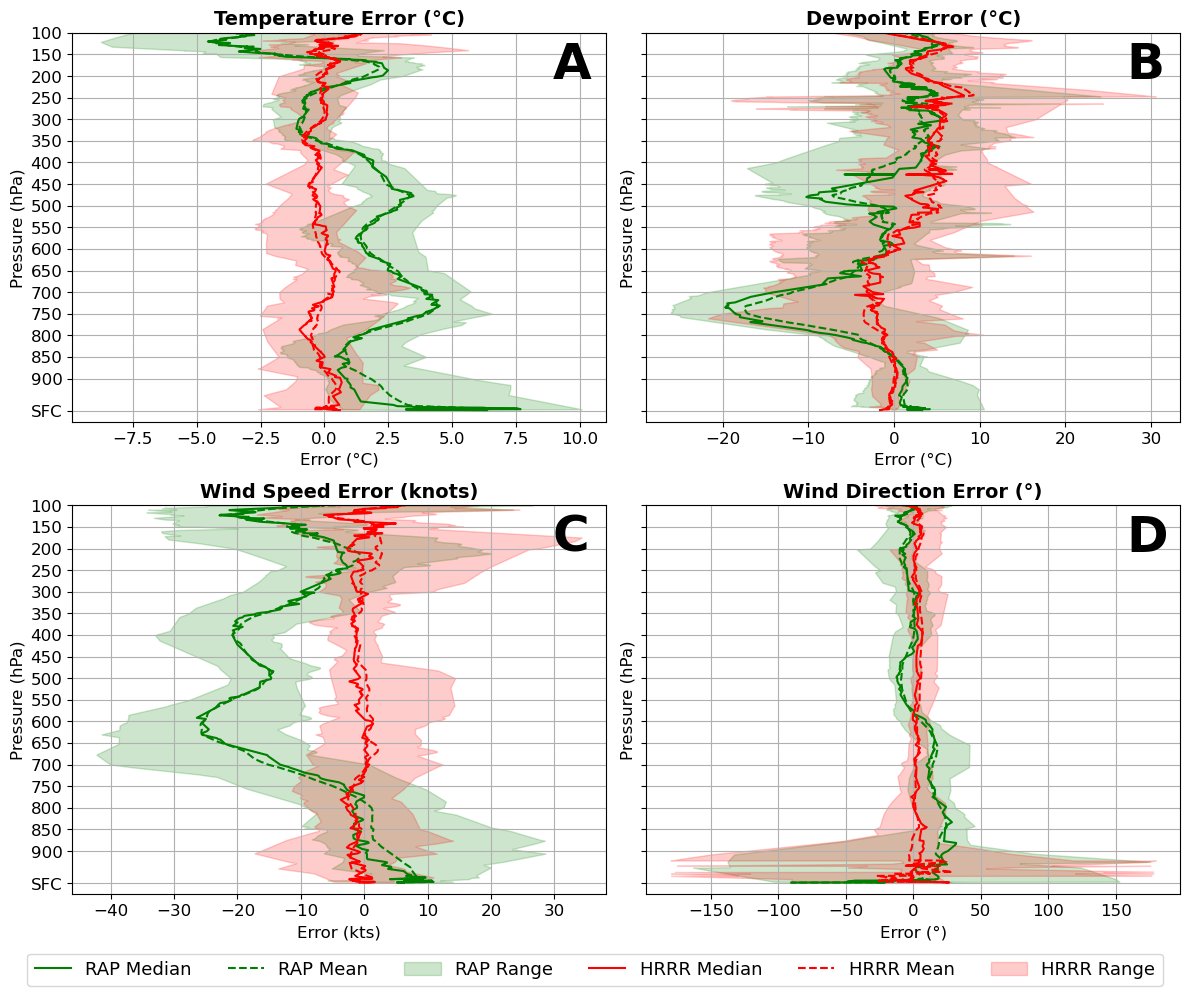

In [3]:
# Identify all dynamically created CombinedS_* DataFrames
combined_dfs = {name: globals()[name] for name in globals() if name.startswith("CombinedS_")}

# Determine a shared pressure grid (use the highest resolution)
all_pressure_levels = np.unique(np.concatenate([df['Obs_P'].values for df in combined_dfs.values()]))

# Keep only levels within 1000-100 hPa
valid_indices = (all_pressure_levels >= 100) & (all_pressure_levels <= 1000)
pressure_levels_filtered = all_pressure_levels[valid_indices]

# Storage for all deltas across different soundings
delta_T_RAP, delta_T_HRRR = [], []
delta_Td_RAP, delta_Td_HRRR = [], []
delta_Spd_RAP, delta_Spd_HRRR = [], []
delta_Dir_RAP, delta_Dir_HRRR = [], []

# Function to interpolate a variable to the shared pressure grid
def interpolate_to_grid(df, variable):
    interp_func = interp1d(df['Obs_P'], df[variable], bounds_error=False, fill_value=np.nan)
    return interp_func(all_pressure_levels)[valid_indices]  # Keep only 1000-100 hPa

# Process each dataframe and interpolate to the shared pressure grid
for df_name, df in combined_dfs.items():
    df = df.reset_index(drop=True)  # Reset index to ensure alignment
    
    obs_T_interp = interpolate_to_grid(df, 'Obs_T')
    obs_Td_interp = interpolate_to_grid(df, 'Obs_Td')
    obs_Spd_interp = interpolate_to_grid(df, 'Obs_Spd')
    obs_Dir_interp = interpolate_to_grid(df, 'Obs_Dir')

    rap_T_interp = interpolate_to_grid(df, 'RAP_T')
    rap_Td_interp = interpolate_to_grid(df, 'RAP_Td')
    rap_Spd_interp = interpolate_to_grid(df, 'RAP_Spd')
    rap_Dir_interp = interpolate_to_grid(df, 'RAP_Dir')

    hrrr_T_interp = interpolate_to_grid(df, 'HRRR_T')
    hrrr_Td_interp = interpolate_to_grid(df, 'HRRR_Td')
    hrrr_Spd_interp = interpolate_to_grid(df, 'HRRR_Spd')
    hrrr_Dir_interp = interpolate_to_grid(df, 'HRRR_Dir')

    # Compute differences (OBS - RAP & OBS - HRRR)
    delta_T_RAP.append(rap_T_interp - obs_T_interp)
    delta_T_HRRR.append(hrrr_T_interp - obs_T_interp)

    delta_Td_RAP.append(rap_Td_interp - obs_Td_interp)
    delta_Td_HRRR.append(hrrr_Td_interp - obs_Td_interp)

    delta_Spd_RAP.append(rap_Spd_interp - obs_Spd_interp)
    delta_Spd_HRRR.append(hrrr_Spd_interp - obs_Spd_interp)

    # Ensure wind direction deltas are within ±180°
    delta_Dir_RAP.append(((obs_Dir_interp - rap_Dir_interp + 180) % 360) - 180)
    delta_Dir_HRRR.append(((obs_Dir_interp - hrrr_Dir_interp + 180) % 360) - 180)

# Convert lists to NumPy arrays
delta_T_RAP, delta_T_HRRR = np.array(delta_T_RAP), np.array(delta_T_HRRR)
delta_Td_RAP, delta_Td_HRRR = np.array(delta_Td_RAP), np.array(delta_Td_HRRR)
delta_Spd_RAP, delta_Spd_HRRR = np.array(delta_Spd_RAP), np.array(delta_Spd_HRRR)
delta_Dir_RAP, delta_Dir_HRRR = np.array(delta_Dir_RAP), np.array(delta_Dir_HRRR)

# Compute statistics (mean, median, min/max)
def compute_stats(delta_array):
    """Computes mean, median, min, and max while handling NaNs properly."""
    return {
        'mean': np.nanmean(delta_array, axis=0),
        'median': np.nanmedian(delta_array, axis=0),
        'min': np.nanmin(delta_array, axis=0),
        'max': np.nanmax(delta_array, axis=0),
    }

stats_T_RAP = compute_stats(delta_T_RAP)
stats_T_HRRR = compute_stats(delta_T_HRRR)

stats_Td_RAP = compute_stats(delta_Td_RAP)
stats_Td_HRRR = compute_stats(delta_Td_HRRR)

stats_Spd_RAP = compute_stats(delta_Spd_RAP)
stats_Spd_HRRR = compute_stats(delta_Spd_HRRR)

stats_Dir_RAP = compute_stats(delta_Dir_RAP)
stats_Dir_HRRR = compute_stats(delta_Dir_HRRR)

# Create 4-panel plot for the mean, median, and range (min/max)
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
#fig.suptitle("Mean, Median, and Range of OBS - RAP & OBS - HRRR Deltas", fontsize=14)

legend_handles = []  # Store legend handles
legend_labels = []   # Store corresponding labels

def plot_panel(ax, stats_RAP, stats_HRRR, xlabel):
    """Helper function to plot mean, median, and range."""
    median_rap, = ax.plot(stats_RAP['median'], pressure_levels_filtered, color='green', linestyle='-', label='RAP Median')
    mean_rap, = ax.plot(stats_RAP['mean'], pressure_levels_filtered, color='green', linestyle='--', label='RAP Mean')
    
    median_hrrr, = ax.plot(stats_HRRR['median'], pressure_levels_filtered, color='red', linestyle='-', label='HRRR Median')
    mean_hrrr, = ax.plot(stats_HRRR['mean'], pressure_levels_filtered, color='red', linestyle='--', label='HRRR Mean')
    
    range_rap = ax.fill_betweenx(pressure_levels_filtered, stats_RAP['min'], stats_RAP['max'], color='green', alpha=0.2, label='RAP Range')
    range_hrrr = ax.fill_betweenx(pressure_levels_filtered, stats_HRRR['min'], stats_HRRR['max'], color='red', alpha=0.2, label='HRRR Range')

    ax.set_xlabel(xlabel)
    ax.grid()

    #Collect handles and labels for a single legend
    if not legend_handles:
        legend_handles.extend([median_rap, mean_rap, range_rap, median_hrrr, mean_hrrr, range_hrrr])
        legend_labels.extend([h.get_label() for h in legend_handles])

#legend_labels = ['RAP Median', 'RAP Mean', 'RAP Range','HRRR Median', 'HRRR Mean', 'HRRR Range']
        
# Temperature Delta Plot
plot_panel(axes[0, 0], stats_T_RAP, stats_T_HRRR, "Error (°C)")

# Dewpoint Delta Plot
plot_panel(axes[0, 1], stats_Td_RAP, stats_Td_HRRR, "Error (°C)")

# Wind Speed Delta Plot
plot_panel(axes[1, 0], stats_Spd_RAP, stats_Spd_HRRR, "Error (kts)")

# Wind Direction Delta Plot
plot_panel(axes[1, 1], stats_Dir_RAP, stats_Dir_HRRR, "Error (°)")

subplot_labels = ["A", "B", "C", "D"]  # Labels for each subplot

subplot_titles = [
    "Temperature Error (°C)",
    "Dewpoint Error (°C)",
    "Wind Speed Error (knots)",
    "Wind Direction Error (°)"
]

for ax, title in zip(axes.flat, subplot_titles):
    ax.set_title(title, fontsize=14, fontweight='bold')

for ax, label in zip(axes.flat, subplot_labels):
    ax.text(
        0.90, 0.98, label, transform=ax.transAxes, fontsize=36, fontweight='bold',
        va='top', ha='left'
    )

# Reverse y-axis to match atmospheric convention (high pressure at bottom)
for ax in axes.flat:
    ax.invert_yaxis()  # Flip Y-axis so high pressure is at the bottom
    ax.set_ylabel("Pressure (hPa)", fontsize=12)
    ax.set_ylim(1000, 100)  # Set limits so the top of the plot is 100 hPa
    # Define Y-axis tick locations
    yticks = [975] + list(range(900, 50, -50))  # Add 1000 (to replace with SFC) and then every 50 hPa

    # Convert 1000 hPa to "SFC" in the tick labels
    ytick_labels = ["SFC"] + [str(p) for p in yticks[1:]]

    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_labels, fontsize=12)  # Increase font size
    ax.xaxis.label.set_size(12)  # Make X-axis label text larger
    ax.tick_params(axis='x', labelsize=12)

# Place a single legend between the two rows
fig.legend(handles=legend_handles, labels=legend_labels, loc="upper center", ncol=6, fontsize=13, frameon=True, bbox_to_anchor=(0.5, 0.01))

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout for title
plt.show()

In [ ]:
#Quick Comparison Plot

In [ ]:
# df1 = pd.read_csv(r'D:\THESIS\5-22_TORUS_Data\UpperAirRadiosonde\NWS High Resolution Radiosonde Data (ESC Format)\KSGF 5-23-19 0000Z.txt',
#                   skiprows=15, usecols=[1, 2, 3, 7, 8, 14], names = ["Press mb", "Temp C","Dewpt C","spd m/s","dir deg","Alt m",], delim_whitespace=True)
# df1 = df1[df1['Press mb'] >= 100]
# df1 = df1.replace(999.0, np.nan).dropna()

df2 = pd.read_csv(r'D:\THESIS\__UNL MS Thesis (MAIN)__\3 - Obtain Vertical Profiles\Observed\522_Observed\KSGF_18Z_22May2019.txt',
                  skiprows=6, skipfooter=32, usecols=[0, 1, 2, 3, 6, 7], 
                  names = ["PRES hPa", "HGHT m","TEMP C","DWPT C","DRCT deg","SKNT knot"], 
                  delim_whitespace=True, engine='python')
df2 = df2[df2['PRES hPa'] >= 100]

fig = plt.figure(figsize=(15, 12))
gs=gridspec.GridSpec(nrows=4, ncols=6)
gs=gridspec.GridSpec(nrows=1, ncols=2)

skew = SkewT(fig, rotation=45, subplot=gs[0,0])
#skew = SkewT(fig, rotation=45, subplot=gs[0:3, 0:3])

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot.
skew.plot(CombinedS_08_KSGF_18Z['Obs_P']*units.hPa, CombinedS_08_KSGF_18Z['Obs_T']*units.degC, 'r')
skew.plot(CombinedS_08_KSGF_18Z['Obs_P']*units.hPa, CombinedS_08_KSGF_18Z['Obs_Td']*units.degC, 'r')
#skew.plot_barbs(p[::2], u[::2], v[::2], color='red')
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 45)
skew.ax.set_ylabel('Pressure (hPa)')
skew.ax.set_xlabel('Temperature (°C)')

#skew.plot(p1, T1, 'b')
#skew.plot(p1, Td1, 'b')
#skew.plot_barbs(p1[::2], u1[::2], v1[::2], color='blue')

skew.plot(df2['PRES hPa']* units.hPa, df2['TEMP C']* units.degC, 'b')
skew.plot(df2['PRES hPa']* units.hPa, df2['DWPT C']* units.degC, 'b')
#skew.plot_barbs(p2[::150], u2[::150], v2[::150], color='blue')


# Create Composite Soundings within Clusters

C:\Users\kyled\AppData\Local\Temp\ipykernel_20920\2666281892.py:141: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i in df[df.EWB=='BND'][df.Time==time]['StormID']:
D:\Anaconda3\envs\THESIS\lib\site-packages\numpy\lib\function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)
D:\Anaconda3\envs\THESIS\lib\site-packages\numpy\lib\function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)
D:\Anaconda3\envs\THESIS\lib\site-packages\numpy\lib\function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)
D:\Anaconda3\envs\THESIS\lib\site-packages\numpy\lib\function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)
D:\Anaconda3\envs\THESIS\lib\site-packages\numpy\lib\function_base.py:1594: UserWar

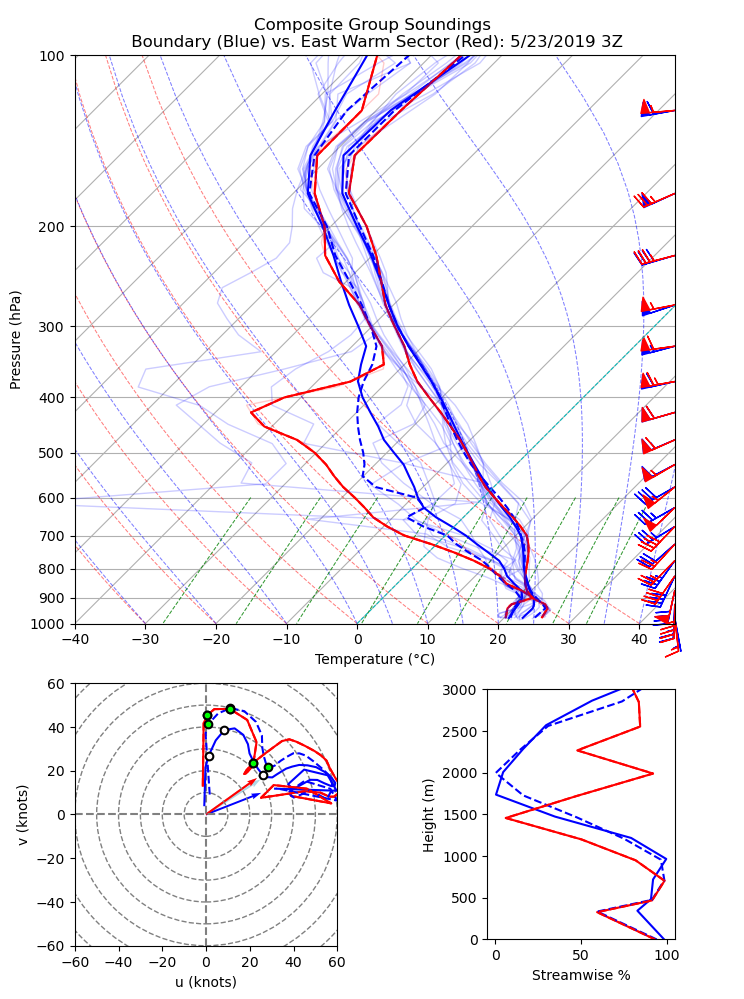

In [6]:
#MEAN#
#df = pd.read_excel("C:/Users/kyled/Desktop/HRRRouts/combined_EW.xlsx")
df = pd.read_csv('D:/THESIS/__UNL MS Thesis (MAIN)__/6 - SkewTs/5_22_VerticalProfs_QC_Grouped_BND.csv')

#D:\THESIS\__UNL MS Thesis (MAIN)__\6 - SkewTs

folder = r"D:\THESIS\__UNL MS Thesis (MAIN)__\6 - SkewTs\Soundings"
col_names = ['pressure', 'temperature', 'dewpoint', 'height', 'uwnd', 'vwnd']

time = 3
day = 23

combinedP_1 = []
combinedT_1 = []
combinedTd_1 = []
combinedH_1 = []
combinedU_1 = []
combinedV_1 = []

combinedP_W = []
combinedT_W = []
combinedTd_W = []
combinedH_W = []
combinedU_W = []
combinedV_W = []

combinedP_E = []
combinedT_E = []
combinedTd_E = []
combinedH_E = []
combinedU_E = []
combinedV_E = []

combinedP_2 = []
combinedT_2 = []
combinedTd_2 = []
combinedH_2 = []
combinedU_2 = []
combinedV_2 = []

interpP_W = []
interpT_W = []
interpTd_W = []
interpH_W = []
interpU_W = []
interpV_W = []

interpP_E = []
interpT_E = []
interpTd_E = []
interpH_E = []
interpU_E = []
interpV_E = []

sfcP_w = []
sfcT_w = []
sfcTd_w = []
sfcH_w = []
sfcU_w = []
sfcV_w = []

sfcP_e = []
sfcT_e = []
sfcTd_e = []
sfcH_e = []
sfcU_e = []
sfcV_e = []

###
combinedP_1sup = []
combinedT_1sup = []
combinedTd_1sup = []
combinedH_1sup = []
combinedU_1sup = []
combinedV_1sup = []

combinedP_Wsup = []
combinedT_Wsup = []
combinedTd_Wsup = []
combinedH_Wsup = []
combinedU_Wsup = []
combinedV_Wsup = []

combinedP_Esup = []
combinedT_Esup = []
combinedTd_Esup = []
combinedH_Esup = []
combinedU_Esup = []
combinedV_Esup = []

combinedP_2sup = []
combinedT_2sup = []
combinedTd_2sup = []
combinedH_2sup = []
combinedU_2sup = []
combinedV_2sup = []

interpP_Wsup = []
interpT_Wsup = []
interpTd_Wsup = []
interpH_Wsup = []
interpU_Wsup = []
interpV_Wsup = []

interpP_Esup = []
interpT_Esup = []
interpTd_Esup = []
interpH_Esup = []
interpU_Esup = []
interpV_Esup = []

sfcP_wsup = []
sfcT_wsup = []
sfcTd_wsup = []
sfcH_wsup = []
sfcU_wsup = []
sfcV_wsup = []

sfcP_esup = []
sfcT_esup = []
sfcTd_esup = []
sfcH_esup = []
sfcU_esup = []
sfcV_esup = []
###

interpP_W = [940.0, 925.0, 900.0, 875.0, 850.0, 825.0, 800.0, 775.0, 750.0, 725.0, 700.0, 675.0,
          650.0, 625.0, 600.0, 575.0, 550.0, 525.0, 500.0, 475.0, 450.0, 425.0, 400.0, 375.0,
          350.0, 325.0, 300.0, 275.0, 250.0, 225.0, 200.0, 175.0, 150.0, 125.0, 100.0]
interpP_E = [940.0, 925.0, 900.0, 875.0, 850.0, 825.0, 800.0, 775.0, 750.0, 725.0, 700.0, 675.0,
          650.0, 625.0, 600.0, 575.0, 550.0, 525.0, 500.0, 475.0, 450.0, 425.0, 400.0, 375.0,
          350.0, 325.0, 300.0, 275.0, 250.0, 225.0, 200.0, 175.0, 150.0, 125.0, 100.0]

interpP_Wsup = [940.0, 925.0, 900.0, 875.0, 850.0, 825.0, 800.0, 775.0, 750.0, 725.0, 700.0, 675.0,
          650.0, 625.0, 600.0, 575.0, 550.0, 525.0, 500.0, 475.0, 450.0, 425.0, 400.0, 375.0,
          350.0, 325.0, 300.0, 275.0, 250.0, 225.0, 200.0, 175.0, 150.0, 125.0, 100.0]
interpP_Esup = [940.0, 925.0, 900.0, 875.0, 850.0, 825.0, 800.0, 775.0, 750.0, 725.0, 700.0, 675.0,
          650.0, 625.0, 600.0, 575.0, 550.0, 525.0, 500.0, 475.0, 450.0, 425.0, 400.0, 375.0,
          350.0, 325.0, 300.0, 275.0, 250.0, 225.0, 200.0, 175.0, 150.0, 125.0, 100.0]

#for i in df[df.Grouping==1][df.Time==20]['Profile_Number']:
for i in df[df.EWB=='BND'][df.Time==time]['StormID']:
#for i in df[df.EW=='W'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        profW = profile.create_profile(profile='default', pres=sounding_df['pressure'], hght=sounding_df['height'],
                                       tmpc=sounding_df['temperature'], dwpc=sounding_df['dewpoint'],
                                       u=sounding_df['uwnd'], v=sounding_df['vwnd'], missing=-9999)
       
        sfcP_W = sharppy.sharptab.interp.pres(profW, 0)
        sfcT_W = sharppy.sharptab.interp.temp(profW, sfcP_W)
        sfcTd_W = sharppy.sharptab.interp.dwpt(profW, sfcP_W)
        sfcWind_W = sharppy.sharptab.interp.components(profW, sfcP_W)
        sfcU_W = sfcWind_W[0]
        sfcV_W = sfcWind_W[1]
        
        sfcP_w.append(sfcP_W)
        sfcT_w.append(sfcT_W)
        sfcTd_w.append(sfcTd_W)
        sfcU_w.append(sfcU_W)
        sfcV_w.append(sfcV_W)

        interpT_W = []
        interpTd_W = []
        interpH_W = []
        interpU_W = []
        interpV_W = []                
        
        for k in interpP_W:
            H_west = sharppy.sharptab.interp.hght(profW, k)
            T_west = sharppy.sharptab.interp.temp(profW, k)
            Td_west = sharppy.sharptab.interp.dwpt(profW, k)
            Wind_west = sharppy.sharptab.interp.components(profW, k)
            U_west = Wind_west[0]
            V_west = Wind_west[1]
            
            interpT_W.append(T_west)
            interpTd_W.append(Td_west)
            interpH_W.append(H_west)
            interpU_W.append(U_west)
            interpV_W.append(V_west)
        
        combinedP_W.append(np.asarray(interpP_W))
        combinedT_W.append(np.asarray(interpT_W))
        combinedTd_W.append(np.asarray(interpTd_W))
        combinedH_W.append(np.asarray(interpH_W))
        combinedU_W.append(np.asarray(interpU_W))
        combinedV_W.append(np.asarray(interpV_W))

#for i in df[df.Grouping==1][df.Time==20]['Profile_Number']:
for i in df[df.EWB=='BND'][df.Time==time][df.Supercell=="Y"]['StormID']:
#for i in df[df.EW=='W'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        profWsup = profile.create_profile(profile='default', pres=sounding_df['pressure'], hght=sounding_df['height'],
                                       tmpc=sounding_df['temperature'], dwpc=sounding_df['dewpoint'],
                                       u=sounding_df['uwnd'], v=sounding_df['vwnd'], missing=-9999)
       
        sfcP_Wsup = sharppy.sharptab.interp.pres(profWsup, 0)
        sfcT_Wsup = sharppy.sharptab.interp.temp(profWsup, sfcP_Wsup)
        sfcTd_Wsup = sharppy.sharptab.interp.dwpt(profWsup, sfcP_Wsup)
        sfcWind_Wsup = sharppy.sharptab.interp.components(profWsup, sfcP_Wsup)
        sfcU_Wsup = sfcWind_Wsup[0]
        sfcV_Wsup = sfcWind_Wsup[1]
        
        sfcP_wsup.append(sfcP_Wsup)
        sfcT_wsup.append(sfcT_Wsup)
        sfcTd_wsup.append(sfcTd_Wsup)
        sfcU_wsup.append(sfcU_Wsup)
        sfcV_wsup.append(sfcV_Wsup)

        interpT_Wsup = []
        interpTd_Wsup = []
        interpH_Wsup = []
        interpU_Wsup = []
        interpV_Wsup = []                
        
        for k in interpP_Wsup:
            H_westsup = sharppy.sharptab.interp.hght(profWsup, k)
            T_westsup = sharppy.sharptab.interp.temp(profWsup, k)
            Td_westsup = sharppy.sharptab.interp.dwpt(profWsup, k)
            Wind_westsup = sharppy.sharptab.interp.components(profWsup, k)
            U_westsup = Wind_westsup[0]
            V_westsup = Wind_westsup[1]
            
            interpT_Wsup.append(T_westsup)
            interpTd_Wsup.append(Td_westsup)
            interpH_Wsup.append(H_westsup)
            interpU_Wsup.append(U_westsup)
            interpV_Wsup.append(V_westsup)
        
        combinedP_Wsup.append(np.asarray(interpP_Wsup))
        combinedT_Wsup.append(np.asarray(interpT_Wsup))
        combinedTd_Wsup.append(np.asarray(interpTd_Wsup))
        combinedH_Wsup.append(np.asarray(interpH_Wsup))
        combinedU_Wsup.append(np.asarray(interpU_Wsup))
        combinedV_Wsup.append(np.asarray(interpV_Wsup))
        
for i in df[df.EWB=='OPE'][df.Time==time]['StormID']:
#for i in df[df.EW=='E'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        profE = profile.create_profile(profile='default', pres=sounding_df['pressure'], hght=sounding_df['height'],
                                       tmpc=sounding_df['temperature'], dwpc=sounding_df['dewpoint'],
                                       u=sounding_df['uwnd'], v=sounding_df['vwnd'], missing=-9999)
       
        sfcP_E = sharppy.sharptab.interp.pres(profE, 0)
        sfcT_E = sharppy.sharptab.interp.temp(profE, sfcP_E)
        sfcTd_E = sharppy.sharptab.interp.dwpt(profE, sfcP_E)
        sfcWind_E = sharppy.sharptab.interp.components(profE, sfcP_E)
        sfcU_E = sfcWind_E[0]
        sfcV_E = sfcWind_E[1]
        
        sfcP_e.append(sfcP_E)
        sfcT_e.append(sfcT_E)
        sfcTd_e.append(sfcTd_E)
        sfcU_e.append(sfcU_E)
        sfcV_e.append(sfcV_E)

        interpT_E = []
        interpTd_E = []
        interpH_E = []
        interpU_E = []
        interpV_E = []                
        
        for k in interpP_E:
            H_east = sharppy.sharptab.interp.hght(profE, k)
            T_east = sharppy.sharptab.interp.temp(profE, k)
            Td_east = sharppy.sharptab.interp.dwpt(profE, k)
            Wind_east = sharppy.sharptab.interp.components(profE, k)
            U_east = Wind_east[0]
            V_east = Wind_east[1]
            
            interpT_E.append(T_east)
            interpTd_E.append(Td_east)
            interpH_E.append(H_east)
            interpU_E.append(U_east)
            interpV_E.append(V_east)
                    
        combinedP_E.append(np.asarray(interpP_E))
        combinedT_E.append(np.asarray(interpT_E))
        combinedTd_E.append(np.asarray(interpTd_E))
        combinedH_E.append(np.asarray(interpH_E))
        combinedU_E.append(np.asarray(interpU_E))
        combinedV_E.append(np.asarray(interpV_E))

#for i in df[df.Grouping==1][df.Time==20]['Profile_Number']:
for i in df[df.EWB=='OPE'][df.Time==time][df.Supercell=="Y"]['StormID']:
#for i in df[df.EW=='W'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        profEsup = profile.create_profile(profile='default', pres=sounding_df['pressure'], hght=sounding_df['height'],
                                       tmpc=sounding_df['temperature'], dwpc=sounding_df['dewpoint'],
                                       u=sounding_df['uwnd'], v=sounding_df['vwnd'], missing=-9999)
       
        sfcP_Esup = sharppy.sharptab.interp.pres(profEsup, 0)
        sfcT_Esup = sharppy.sharptab.interp.temp(profEsup, sfcP_Esup)
        sfcTd_Esup = sharppy.sharptab.interp.dwpt(profEsup, sfcP_Esup)
        sfcWind_Esup = sharppy.sharptab.interp.components(profEsup, sfcP_Esup)
        sfcU_Esup = sfcWind_Esup[0]
        sfcV_Esup = sfcWind_Esup[1]
        
        sfcP_esup.append(sfcP_Esup)
        sfcT_esup.append(sfcT_Esup)
        sfcTd_esup.append(sfcTd_Esup)
        sfcU_esup.append(sfcU_Esup)
        sfcV_esup.append(sfcV_Esup)

        interpT_Esup = []
        interpTd_Esup = []
        interpH_Esup = []
        interpU_Esup = []
        interpV_Esup = []                
        
        for k in interpP_Esup:
            H_eastsup = sharppy.sharptab.interp.hght(profEsup, k)
            T_eastsup = sharppy.sharptab.interp.temp(profEsup, k)
            Td_eastsup = sharppy.sharptab.interp.dwpt(profEsup, k)
            Wind_eastsup = sharppy.sharptab.interp.components(profEsup, k)
            U_eastsup = Wind_eastsup[0]
            V_eastsup = Wind_eastsup[1]
            
            interpT_Esup.append(T_eastsup)
            interpTd_Esup.append(Td_eastsup)
            interpH_Esup.append(H_eastsup)
            interpU_Esup.append(U_eastsup)
            interpV_Esup.append(V_eastsup)
        
        combinedP_Esup.append(np.asarray(interpP_Esup))
        combinedT_Esup.append(np.asarray(interpT_Esup))
        combinedTd_Esup.append(np.asarray(interpTd_Esup))
        combinedH_Esup.append(np.asarray(interpH_Esup))
        combinedU_Esup.append(np.asarray(interpU_Esup))
        combinedV_Esup.append(np.asarray(interpV_Esup))
        
combinedP_W=np.asarray(combinedP_W)
combinedT_W=np.asarray(combinedT_W)
combinedTd_W=np.asarray(combinedTd_W)
combinedH_W=np.asarray(combinedH_W)
combinedU_W=np.asarray(combinedU_W)
combinedV_W=np.asarray(combinedV_W)

combinedP_E=np.asarray(combinedP_E)
combinedT_E=np.asarray(combinedT_E)
combinedTd_E=np.asarray(combinedTd_E)
combinedH_E=np.asarray(combinedH_E)
combinedU_E=np.asarray(combinedU_E)
combinedV_E=np.asarray(combinedV_E)

combinedP_Wsup=np.asarray(combinedP_Wsup)
combinedT_Wsup=np.asarray(combinedT_Wsup)
combinedTd_Wsup=np.asarray(combinedTd_Wsup)
combinedH_Wsup=np.asarray(combinedH_Wsup)
combinedU_Wsup=np.asarray(combinedU_Wsup)
combinedV_Wsup=np.asarray(combinedV_Wsup)

combinedP_Esup=np.asarray(combinedP_Esup)
combinedT_Esup=np.asarray(combinedT_Esup)
combinedTd_Esup=np.asarray(combinedTd_Esup)
combinedH_Esup=np.asarray(combinedH_Esup)
combinedU_Esup=np.asarray(combinedU_Esup)
combinedV_Esup=np.asarray(combinedV_Esup)
   
sfcP_w=np.asarray(sfcP_w)
sfcT_w=np.asarray(sfcT_w)
sfcTd_w=np.asarray(sfcTd_w)
sfcU_w=np.asarray(sfcU_w)
sfcV_w=np.asarray(sfcV_w)

sfcP_e=np.asarray(sfcP_e)
sfcT_e=np.asarray(sfcT_e)
sfcTd_e=np.asarray(sfcTd_e)
sfcU_e=np.asarray(sfcU_e)
sfcV_e=np.asarray(sfcV_e)

sfcP_wsup=np.asarray(sfcP_wsup)
sfcT_wsup=np.asarray(sfcT_wsup)
sfcTd_wsup=np.asarray(sfcTd_wsup)
sfcU_wsup=np.asarray(sfcU_wsup)
sfcV_wsup=np.asarray(sfcV_wsup)

sfcP_esup=np.asarray(sfcP_esup)
sfcT_esup=np.asarray(sfcT_esup)
sfcTd_esup=np.asarray(sfcTd_esup)
sfcU_esup=np.asarray(sfcU_esup)
sfcV_esup=np.asarray(sfcV_esup)

PRES_W=[]
TEMP_W=[]
DEWP_W=[]
HGHT_W=[]
UWND_W=[]
VWND_W=[]

PRES_E=[]
TEMP_E=[]
DEWP_E=[]
HGHT_E=[]
UWND_E=[]
VWND_E=[]

PRES_Wsup=[]
TEMP_Wsup=[]
DEWP_Wsup=[]
HGHT_Wsup=[]
UWND_Wsup=[]
VWND_Wsup=[]

PRES_Esup=[]
TEMP_Esup=[]
DEWP_Esup=[]
HGHT_Esup=[]
UWND_Esup=[]
VWND_Esup=[]

for l in range(0,len(sfcP_w)):
    PRES_W.append(np.insert(combinedP_W[l],0,sfcP_w[l]))
    TEMP_W.append(np.insert(combinedT_W[l],0,sfcT_w[l]))
    DEWP_W.append(np.insert(combinedTd_W[l],0,sfcTd_w[l]))
    HGHT_W.append(np.insert(combinedH_W[l],0,0))
    UWND_W.append(np.insert(combinedU_W[l],0,sfcU_w[l]))
    VWND_W.append(np.insert(combinedV_W[l],0,sfcV_w[l]))

for l in range(0,len(sfcP_e)):
    PRES_E.append(np.insert(combinedP_E[l],0,sfcP_e[l]))
    TEMP_E.append(np.insert(combinedT_E[l],0,sfcT_e[l]))
    DEWP_E.append(np.insert(combinedTd_E[l],0,sfcTd_e[l]))
    HGHT_E.append(np.insert(combinedH_E[l],0,0))
    UWND_E.append(np.insert(combinedU_E[l],0,sfcU_e[l]))
    VWND_E.append(np.insert(combinedV_E[l],0,sfcV_e[l]))

for l in range(0,len(sfcP_wsup)):
    PRES_Wsup.append(np.insert(combinedP_Wsup[l],0,sfcP_wsup[l]))
    TEMP_Wsup.append(np.insert(combinedT_Wsup[l],0,sfcT_wsup[l]))
    DEWP_Wsup.append(np.insert(combinedTd_Wsup[l],0,sfcTd_wsup[l]))
    HGHT_Wsup.append(np.insert(combinedH_Wsup[l],0,0))
    UWND_Wsup.append(np.insert(combinedU_Wsup[l],0,sfcU_wsup[l]))
    VWND_Wsup.append(np.insert(combinedV_Wsup[l],0,sfcV_wsup[l]))

for l in range(0,len(sfcP_esup)):
    PRES_Esup.append(np.insert(combinedP_Esup[l],0,sfcP_esup[l]))
    TEMP_Esup.append(np.insert(combinedT_Esup[l],0,sfcT_esup[l]))
    DEWP_Esup.append(np.insert(combinedTd_Esup[l],0,sfcTd_esup[l]))
    HGHT_Esup.append(np.insert(combinedH_Esup[l],0,0))
    UWND_Esup.append(np.insert(combinedU_Esup[l],0,sfcU_esup[l]))
    VWND_Esup.append(np.insert(combinedV_Esup[l],0,sfcV_esup[l]))
    
#PRES_W=np.asarray(PRES_W)        
combinedP_1=pd.DataFrame(PRES_W).T
combinedT_1=pd.DataFrame(TEMP_W).T
combinedTd_1=pd.DataFrame(DEWP_W).T
combinedH_1=pd.DataFrame(HGHT_W).T
combinedU_1=pd.DataFrame(UWND_W).T
combinedV_1=pd.DataFrame(VWND_W).T        

combinedP_2=pd.DataFrame(PRES_E).T
combinedT_2=pd.DataFrame(TEMP_E).T
combinedTd_2=pd.DataFrame(DEWP_E).T
combinedH_2=pd.DataFrame(HGHT_E).T
combinedU_2=pd.DataFrame(UWND_E).T
combinedV_2=pd.DataFrame(VWND_E).T        

combinedP_1sup=pd.DataFrame(PRES_Wsup).T
combinedT_1sup=pd.DataFrame(TEMP_Wsup).T
combinedTd_1sup=pd.DataFrame(DEWP_Wsup).T
combinedH_1sup=pd.DataFrame(HGHT_Wsup).T
combinedU_1sup=pd.DataFrame(UWND_Wsup).T
combinedV_1sup=pd.DataFrame(VWND_Wsup).T        

combinedP_2sup=pd.DataFrame(PRES_Esup).T
combinedT_2sup=pd.DataFrame(TEMP_Esup).T
combinedTd_2sup=pd.DataFrame(DEWP_Esup).T
combinedH_2sup=pd.DataFrame(HGHT_Esup).T
combinedU_2sup=pd.DataFrame(UWND_Esup).T
combinedV_2sup=pd.DataFrame(VWND_Esup).T   

combinedP_1['meanP'] = combinedP_1.mean(axis=1)
combinedT_1['meanT'] = combinedT_1.mean(axis=1)
combinedTd_1['meanTd'] = combinedTd_1.mean(axis=1)
combinedH_1['meanH'] = combinedH_1.mean(axis=1)
combinedU_1['meanU'] = combinedU_1.mean(axis=1)
combinedV_1['meanV'] = combinedV_1.mean(axis=1)
        
combinedP_2['meanP'] = combinedP_2.mean(axis=1)
combinedT_2['meanT'] = combinedT_2.mean(axis=1)
combinedTd_2['meanTd'] = combinedTd_2.mean(axis=1)
combinedH_2['meanH'] = combinedH_2.mean(axis=1)
combinedU_2['meanU'] = combinedU_2.mean(axis=1)
combinedV_2['meanV'] = combinedV_2.mean(axis=1)

combinedP_1sup['meanP'] = combinedP_1sup.mean(axis=1)
combinedT_1sup['meanT'] = combinedT_1sup.mean(axis=1)
combinedTd_1sup['meanTd'] = combinedTd_1sup.mean(axis=1)
combinedH_1sup['meanH'] = combinedH_1sup.mean(axis=1)
combinedU_1sup['meanU'] = combinedU_1sup.mean(axis=1)
combinedV_1sup['meanV'] = combinedV_1sup.mean(axis=1)
        
combinedP_2sup['meanP'] = combinedP_2sup.mean(axis=1)
combinedT_2sup['meanT'] = combinedT_2sup.mean(axis=1)
combinedTd_2sup['meanTd'] = combinedTd_2sup.mean(axis=1)
combinedH_2sup['meanH'] = combinedH_2sup.mean(axis=1)
combinedU_2sup['meanU'] = combinedU_2sup.mean(axis=1)
combinedV_2sup['meanV'] = combinedV_2sup.mean(axis=1)

#######################################################
#Shear Calculations
u_1 = np.asarray(combinedU_1['meanU'])/1.944
v_1 = np.asarray(combinedV_1['meanV'])/1.944
z_1 = np.asarray(combinedH_1['meanH'])

u_2 = np.asarray(combinedU_2['meanU'])/1.944
v_2 = np.asarray(combinedV_2['meanV'])/1.944
z_2 = np.asarray(combinedH_2['meanH'])

profMS_W = profile.create_profile(profile='default', pres=np.asarray(combinedP_1['meanP']), hght=z_1,
                               tmpc=np.asarray(combinedT_1['meanT']), dwpc=np.asarray(combinedTd_1['meanTd']),
                               u=u_1, v=v_1, missing=-9999)
profMS_E = profile.create_profile(profile='default', pres=np.asarray(combinedP_2['meanP']), hght=z_2,
                               tmpc=np.asarray(combinedT_2['meanT']), dwpc=np.asarray(combinedTd_2['meanTd']),
                               u=u_2, v=v_2, missing=-9999)

srwindW = params.bunkers_storm_motion(profMS_W)
srwindE = params.bunkers_storm_motion(profMS_E)

uSR_W = u_1-srwindW[0]
uSR_E = u_2-srwindE[0]

vSR_W = v_1-srwindW[1]
vSR_E = v_2-srwindE[1]

dudz_W=(np.array(u_1[2::])-np.array(u_1[0:-2]))/(np.array(z_1[2::])-np.array(z_1[0:-2]))
dvdz_W=(np.array(v_1[2::])-np.array(v_1[0:-2]))/(np.array(z_1[2::])-np.array(z_1[0:-2]))
dudz_W=np.insert(dudz_W,0,dudz_W[0])
dudz_W=np.insert(dudz_W,-1,dudz_W[-1])
dvdz_W=np.insert(dvdz_W,0,dvdz_W[0])
dvdz_W=np.insert(dvdz_W,-1,dvdz_W[-1])

dudz_E=(np.array(u_2[2::])-np.array(u_2[0:-2]))/(np.array(z_2[2::])-np.array(z_2[0:-2]))
dvdz_E=(np.array(v_2[2::])-np.array(v_2[0:-2]))/(np.array(z_2[2::])-np.array(z_2[0:-2]))
dudz_E=np.insert(dudz_E,0,dudz_E[0])
dudz_E=np.insert(dudz_E,-1,dudz_E[-1])
dvdz_E=np.insert(dvdz_E,0,dvdz_E[0])
dvdz_E=np.insert(dvdz_E,-1,dvdz_E[-1])

shear_W=np.sqrt(dudz_W**2+dvdz_W**2)+0.0000001
# Vorticity components
uvort_W=-dvdz_W
vvort_W=dudz_W
# Streamwise vorticity
strmw_W=abs((uSR_W*uvort_W+vSR_W*vvort_W)/(np.sqrt(uSR_W**2+vSR_W**2)))
# Streamwise fraction
strmwperc_W=strmw_W/shear_W

shear_E=np.sqrt(dudz_E**2+dvdz_E**2)+0.0000001
# Vorticity components
uvort_E=-dvdz_E
vvort_E=dudz_E
# Streamwise vorticity
strmw_E=abs((uSR_E*uvort_E+vSR_E*vvort_E)/(np.sqrt(uSR_E**2+vSR_E**2)))
# Streamwise fraction
strmwperc_E=strmw_E/shear_E

#################################################
#Shear Calculations
if len(df[df.EWB=='BND'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    u_1sup = np.asarray(combinedU_1sup['meanU'])/1.944
    v_1sup = np.asarray(combinedV_1sup['meanV'])/1.944
    z_1sup = np.asarray(combinedH_1sup['meanH'])

    profMS_Wsup = profile.create_profile(profile='default', pres=np.asarray(combinedP_1sup['meanP']), hght=z_1sup,
                               tmpc=np.asarray(combinedT_1sup['meanT']), dwpc=np.asarray(combinedTd_1sup['meanTd']),
                               u=u_1sup, v=v_1sup, missing=-9999)
    
    srwindWsup = params.bunkers_storm_motion(profMS_Wsup)
    uSR_Wsup = u_1sup-srwindWsup[0]
    vSR_Wsup = v_1sup-srwindWsup[1]
    
    dudz_Wsup=(np.array(u_1sup[2::])-np.array(u_1sup[0:-2]))/(np.array(z_1sup[2::])-np.array(z_1sup[0:-2]))
    dvdz_Wsup=(np.array(v_1sup[2::])-np.array(v_1sup[0:-2]))/(np.array(z_1sup[2::])-np.array(z_1sup[0:-2]))
    dudz_Wsup=np.insert(dudz_Wsup,0,dudz_Wsup[0])
    dudz_Wsup=np.insert(dudz_Wsup,-1,dudz_Wsup[-1])
    dvdz_Wsup=np.insert(dvdz_Wsup,0,dvdz_Wsup[0])
    dvdz_Wsup=np.insert(dvdz_Wsup,-1,dvdz_Wsup[-1])
    
    shear_Wsup=np.sqrt(dudz_Wsup**2+dvdz_Wsup**2)+0.0000001
    # Vorticity components
    uvort_Wsup=-dvdz_Wsup
    vvort_Wsup=dudz_Wsup
    # Streamwise vorticity
    strmw_Wsup=abs((uSR_Wsup*uvort_Wsup+vSR_Wsup*vvort_Wsup)/(np.sqrt(uSR_Wsup**2+vSR_Wsup**2)))
    # Streamwise fraction
    strmwperc_Wsup=strmw_Wsup/shear_Wsup
    
if len(df[df.EWB=='OPE'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    u_2sup = np.asarray(combinedU_2sup['meanU'])/1.944
    v_2sup = np.asarray(combinedV_2sup['meanV'])/1.944
    z_2sup = np.asarray(combinedH_2sup['meanH'])


    profMS_Esup = profile.create_profile(profile='default', pres=np.asarray(combinedP_2sup['meanP']), hght=z_2sup,
                                   tmpc=np.asarray(combinedT_2sup['meanT']), dwpc=np.asarray(combinedTd_2sup['meanTd']),
                                   u=u_2sup, v=v_2sup, missing=-9999)
    
    srwindEsup = params.bunkers_storm_motion(profMS_Esup)
    uSR_Esup = u_2sup-srwindEsup[0]
    vSR_Esup = v_2sup-srwindEsup[1]

    dudz_Esup=(np.array(u_2sup[2::])-np.array(u_2sup[0:-2]))/(np.array(z_2sup[2::])-np.array(z_2sup[0:-2]))
    dvdz_Esup=(np.array(v_2sup[2::])-np.array(v_2sup[0:-2]))/(np.array(z_2sup[2::])-np.array(z_2sup[0:-2]))
    dudz_Esup=np.insert(dudz_Esup,0,dudz_Esup[0])
    dudz_Esup=np.insert(dudz_Esup,-1,dudz_Esup[-1])
    dvdz_Esup=np.insert(dvdz_Esup,0,dvdz_Esup[0])
    dvdz_Esup=np.insert(dvdz_Esup,-1,dvdz_Esup[-1])

    shear_Esup=np.sqrt(dudz_Esup**2+dvdz_Esup**2)+0.0000001
    # Vorticity components
    uvort_Esup=-dvdz_Esup
    vvort_Esup=dudz_Esup
    # Streamwise vorticity
    strmw_Esup=abs((uSR_Esup*uvort_Esup+vSR_Esup*vvort_Esup)/(np.sqrt(uSR_Esup**2+vSR_Esup**2)))
    # Streamwise fraction
    strmwperc_Esup=strmw_Esup/shear_Esup

#######################################################
fig = plt.figure(figsize=(7.5, 10))
#gs=gridspec.GridSpec(nrows=6, ncols=4, figure=fig)

#ax0 = plt.subplot(gs.new_subplotspec((0,0), rowspan=4, colspan=4))

skew = SkewT(fig, rotation=45, rect=(0, 0.25, 0.8, 0.8)) # left, bottom, width, height (range 0 to 1)
#skew = SkewT(ax0, rotation=45)
#skew = SkewT(fig, rotation=45, subplot=gs[0:3, 0:3])

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot.

hpa100 = np.where(combinedP_1['meanP'] >=100)

skew.plot(combinedP_1['meanP'], combinedT_1['meanT'], 'b', linestyle='-', linewidth=1.5)
skew.plot(combinedP_1['meanP'], combinedTd_1['meanTd'], 'b', linestyle='-', linewidth=1.5)
skew.plot_barbs(combinedP_1['meanP'][hpa100[0]][::2], combinedU_1['meanU'][hpa100[0]][::2], combinedV_1['meanV'][hpa100[0]][::2], color='blue')
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 45)
skew.ax.set_ylabel('Pressure (hPa)')
skew.ax.set_xlabel('Temperature (°C)')

skew.plot(combinedP_2['meanP'], combinedT_2['meanT'], 'r', linestyle='-', linewidth=1.5)
skew.plot(combinedP_2['meanP'], combinedTd_2['meanTd'], 'r', linestyle='-', linewidth=1.5)
skew.plot_barbs(combinedP_2['meanP'][hpa100[0]][::2], combinedU_2['meanU'][hpa100[0]][::2], combinedV_2['meanV'][hpa100[0]][::2], color='red')

skew.plot(combinedP_1sup['meanP'], combinedT_1sup['meanT'], 'b', linestyle='--', linewidth=1.5)
skew.plot(combinedP_1sup['meanP'], combinedTd_1sup['meanTd'], 'b', linestyle='--', linewidth=1.5)
skew.plot(combinedP_2sup['meanP'], combinedT_2sup['meanT'], 'r', linestyle='--', linewidth=1.5)
skew.plot(combinedP_2sup['meanP'], combinedTd_2sup['meanTd'], 'r', linestyle='--', linewidth=1.5)

for i in df[df.EWB=='OPE'][df.Time==time]['StormID']:
#for i in df[df.EW=='E'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        skew.plot(np.asarray(sounding_df['pressure']), np.asarray(sounding_df['temperature']), 'r', linewidth=1.0, alpha=0.2)
        skew.plot(np.asarray(sounding_df['pressure']), np.asarray(sounding_df['dewpoint']), 'r', linewidth=1.0, alpha=0.2)

for i in df[df.EWB=='BND'][df.Time==time]['StormID']:
#for i in df[df.EW=='E'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        skew.plot(np.asarray(sounding_df['pressure']), np.asarray(sounding_df['temperature']), 'b', linewidth=1.0, alpha=0.2)
        skew.plot(np.asarray(sounding_df['pressure']), np.asarray(sounding_df['dewpoint']), 'b', linewidth=1.0, alpha=0.2)

        
#skew.plot(p2, T2, 'b')
#skew.plot(p2, Td2, 'b')
#skew.plot_barbs(p2[::150], u2[::150], v2[::150], color='blue')

# Calculate LCL height and plot as black dot. Because `p`'s first value is
# ~1000 mb and its last value is ~250 mb, the `0` index is selected for
# `p`, `T`, and `Td` to lift the parcel from the surface. If `p` was inverted,
# i.e. start from low value, 250 mb, to a high value, 1000 mb, the `-1` index
# should be selected.

#lcl_pressure, lcl_temperature = lcl(p[0], T[0], Td[0])
#skew.plot(lcl_pressure, lcl_temperature, marker=11, markerfacecolor='black', markers)

# Calculate full parcel profile and add to plot as black line
#prof = parcel_profile(p, T[0], Td[0]).to('degC')

#prof1 = mixed_parcel(p, T, Td)
#prof = parcel_profile(p, prof1[1], prof1[2]).to('degC')
#prof = parcel_profile(p, mlpcl.tmpc*units.degree_Celsius, mlpcl.dwpc*units.degree_Celsius).to('degC')


#mlpcl.tmpc*units.degree_Celsius
#skew.plot(p, prof, 'k', linewidth=1.5, linestyle='--')

# Shade areas of CAPE and CIN
#skew.shade_cin(p, T, prof, Td)
#skew.shade_cape(p, T, prof)

# An example of a slanted line at constant T -- in this case the 0
# isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=0.75)
#skew.ax.axvline(-20, color='c', linestyle='--', linewidth=1)
#skew.ax.axvline(-30, color='c', linestyle='--', linewidth=1)

#hgt0c = (mupcl.hght0c*units.meter).to(units.feet)
#hgtm20c = (mupcl.hghtm20c*units.meter).to(units.feet)
#hgtm30c = (mupcl.hghtm30c*units.meter).to(units.feet)

# Add the relevant special lines
skew.plot_dry_adiabats(linewidth=0.75)
skew.plot_moist_adiabats(linewidth=0.75)
skew.plot_mixing_lines(linewidth=0.75)

plt.title("Composite Group Soundings \n Boundary (Blue) vs. East Warm Sector (Red): 5/"+str(day)+"/2019 "+str(time)+"Z")

#plt.title("Composite Group Soundings (Warm Sector) \n West (Blue) vs. East (Red): 5/"+str(day)+"/2019 "+str(time)+"Z")
#plt.title("Composite Group Soundings (Supercells) \n West (Blue) vs. East (Red): 5/"+str(day)+"/2019 "+str(time)+"Z")
#plt.title("Composite Group Soundings (Supercells) \n West (Blue) vs. East (Red): 5/"+str(day)+"/2019 "+str(time)+"Z")
#plt.title("Composite Group Soundings (Supercells) \n West (Blue) vs. East (Red): 5/23/2019 "+str(time)+"Z")

# Add a secondary axis that automatically converts between pressure and height
# assuming a standard atmosphere. The value of -0.12 puts the secondary axis
# 0.12 normalized (0 to 1) coordinates left of the original axis.
#secax = skew.ax.secondary_yaxis(-0.14,
#    functions=(lambda p: pressure_to_height_std(units.Quantity(p, 'mbar')).m_as('feet'),
#               lambda h: height_to_pressure_std(units.Quantity(h, 'feet')).m))

#fig = plt.figure(figsize=(12, 12))
#gs=gridspec.GridSpec(2,2)


#ax = fig.add_subplot(gs[4,0])
#ax = plt.subplot(gs.new_subplotspec((4,0), rowspan=2, colspan=2))
#ax = fig.add_subplot(gs[1:2,3:])

ax = plt.axes((0, 0, 0.35, 0.35))
h = Hodograph(ax, component_range=60.)
h.add_grid(increment=10)
h.ax.set_xlabel('u (knots)')
h.ax.set_ylabel('v (knots)')

height_scale = combinedH_1['meanH'][hpa100[0]].values
height = combinedH_1['meanH'][hpa100[0]].values * units.m

h.plot(combinedU_1['meanU'][hpa100[0]],combinedV_1['meanV'][hpa100[0]], alpha = 1.0,linewidth=1.5, color='blue')
h.plot(combinedU_2['meanU'][hpa100[0]],combinedV_2['meanV'][hpa100[0]], alpha = 1.0,linewidth=1.5, color='red')

if len(df[df.EWB=='BND'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    h.plot(combinedU_1sup['meanU'][hpa100[0]],combinedV_1sup['meanV'][hpa100[0]], alpha = 1.0,linewidth=1.5, linestyle="--", color='blue')

if len(df[df.EWB=='OPE'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    h.plot(combinedU_2sup['meanU'][hpa100[0]],combinedV_2sup['meanV'][hpa100[0]], alpha = 1.0,linewidth=1.5, linestyle="--", color='red')

for i in df[df.EWB=='OPE'][df.Time==time]['StormID']:
#for i in df[df.EW=='E'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        #h.plot(np.asarray(sounding_df['uwnd'][hpa100[0]]), np.asarray(sounding_df['vwnd'][hpa100[0]]), linewidth=1.0, alpha=0.3, color='red')

for i in df[df.EWB=='BND'][df.Time==time]['StormID']:
#for i in df[df.EW=='E'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        #h.plot(np.asarray(sounding_df['uwnd'][hpa100[0]]), np.asarray(sounding_df['vwnd'][hpa100[0]]), linewidth=1.0, alpha=0.3, color='blue')

#cmap_W = plt.cm.winter_r
#cmap_E = plt.cm.autumn_r
#cmap_W = truncate_colormap(cmap_W, 0.35, 0.85)
#cmap_E = truncate_colormap(cmap_E, 0.35, 0.85)

#for i in range(0, v3000E):
    #w_3km = h.plot(combinedU_1['meanU'][hpa100[0]][i:i+2],combinedV_1['meanV'][hpa100[0]][i:i+2], alpha = 0.6, linewidth=180*shear_W[i], color=cmap_W(int(strmwperc_W[i]*255)))
    #e_3km = h.plot(combinedU_2['meanU'][hpa100[0]][i:i+2],combinedV_2['meanV'][hpa100[0]][i:i+2], alpha = 0.6, linewidth=180*shear_E[i], color=cmap_E(int(strmwperc_E[i]*255)))
    #w_3km = h.plot(combinedU_1['meanU'][hpa100[0]][i:i+2],combinedV_1['meanV'][hpa100[0]][i:i+2], linewidth=2.0, color=cmap_W(int(strmwperc_W[i]*255)))
    #e_3km = h.plot(combinedU_2['meanU'][hpa100[0]][i:i+2],combinedV_2['meanV'][hpa100[0]][i:i+2], linewidth=2.0, color=cmap_E(int(strmwperc_E[i]*255)))
#h.plot_colormapped(combinedU_1['meanU'][hpa100[0]],combinedV_1['meanV'][hpa100[0]], height_scale, cmap=plt.cm.Blues,intervals=[10,15,25], linewidth=2)
#h.plot_colormapped(combinedU_2['meanU'][hpa100[0]],combinedV_2['meanV'][hpa100[0]], height_scale, cmap=plt.cm.Reds,intervals=[10,15,25], linewidth=2)

#h.plot(combinedU_1['meanU'][hpa100[0]][13],combinedV_1['meanV'][hpa100[0]][13], marker="s")
#h.ax.text(combinedU_1['meanU'][hpa100[0]][5],combinedV_1['meanV'][hpa100[0]][5],'1',fontsize=24,ha='left',fontweight='bold', color='black')
#h.ax.text(combinedU_2['meanU'][hpa100[0]][5],combinedV_2['meanV'][hpa100[0]][5],'1',fontsize=24,ha='left',fontweight='bold', color='black')

val500W = find_nearest(combinedH_1['meanH'][hpa100[0]], 500)
val500posW = np.where(combinedH_1['meanH'][hpa100[0]] == val500W)
v500W = val500posW[0][0]

val1000W = find_nearest(combinedH_1['meanH'][hpa100[0]], 1000)
val1000posW = np.where(combinedH_1['meanH'][hpa100[0]] == val1000W)
v1000W = val1000posW[0][0]

val3000W = find_nearest(combinedH_1['meanH'][hpa100[0]], 3000)
val3000posW = np.where(combinedH_1['meanH'][hpa100[0]] == val3000W)
v3000W = val3000posW[0][0]

val500E = find_nearest(combinedH_2['meanH'][hpa100[0]], 500)
val500posE = np.where(combinedH_2['meanH'][hpa100[0]] == val500E)
v500E = val500posE[0][0]

val1000E = find_nearest(combinedH_2['meanH'][hpa100[0]], 1000)
val1000posE = np.where(combinedH_2['meanH'][hpa100[0]] == val1000E)
v1000E = val1000posE[0][0]

val3000E = find_nearest(combinedH_2['meanH'][hpa100[0]], 3000)
val3000posE = np.where(combinedH_2['meanH'][hpa100[0]] == val3000E)
v3000E = val3000posE[0][0]

###########
if len(df[df.EWB=='BND'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    val500Wsup = find_nearest(combinedH_1sup['meanH'][hpa100[0]], 500)
    val500posWsup = np.where(combinedH_1sup['meanH'][hpa100[0]] == val500Wsup)
    v500Wsup = val500posWsup[0][0]

    val1000Wsup = find_nearest(combinedH_1sup['meanH'][hpa100[0]], 1000)
    val1000posWsup = np.where(combinedH_1sup['meanH'][hpa100[0]] == val1000Wsup)
    v1000Wsup = val1000posWsup[0][0]

    val3000Wsup = find_nearest(combinedH_1sup['meanH'][hpa100[0]], 3000)
    val3000posWsup = np.where(combinedH_1sup['meanH'][hpa100[0]] == val3000Wsup)
    v3000Wsup = val3000posWsup[0][0]

if len(df[df.EWB=='OPE'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    val500Esup = find_nearest(combinedH_2sup['meanH'][hpa100[0]], 500)
    val500posEsup = np.where(combinedH_2sup['meanH'][hpa100[0]] == val500Esup)
    v500Esup = val500posEsup[0][0]

    val1000Esup = find_nearest(combinedH_2sup['meanH'][hpa100[0]], 1000)
    val1000posEsup = np.where(combinedH_2sup['meanH'][hpa100[0]] == val1000Esup)
    v1000Esup = val1000posEsup[0][0]

    val3000Esup = find_nearest(combinedH_2sup['meanH'][hpa100[0]], 3000)
    val3000posEsup = np.where(combinedH_2sup['meanH'][hpa100[0]] == val3000Esup)
    v3000Esup = val3000posEsup[0][0]

############
h.plot(combinedU_1['meanU'][hpa100[0]][v500W],combinedV_1['meanV'][hpa100[0]][v500W], marker="o", color='black', markersize=6)
h.plot(combinedU_1['meanU'][hpa100[0]][v1000W],combinedV_1['meanV'][hpa100[0]][v1000W], marker="o", color='black', markersize=6)
h.plot(combinedU_1['meanU'][hpa100[0]][v3000W],combinedV_1['meanV'][hpa100[0]][v3000W], marker="o", color='black', markersize=6)

h.plot(combinedU_2['meanU'][hpa100[0]][v500E],combinedV_2['meanV'][hpa100[0]][v500E], marker="o", color='black', markersize=6)
h.plot(combinedU_2['meanU'][hpa100[0]][v1000E],combinedV_2['meanV'][hpa100[0]][v1000E], marker="o", color='black', markersize=6)
h.plot(combinedU_2['meanU'][hpa100[0]][v3000E],combinedV_2['meanV'][hpa100[0]][v3000E], marker="o", color='black', markersize=6)

h.plot(combinedU_1['meanU'][hpa100[0]][v500W],combinedV_1['meanV'][hpa100[0]][v500W], marker="o", color='snow', markersize=3)
h.plot(combinedU_1['meanU'][hpa100[0]][v1000W],combinedV_1['meanV'][hpa100[0]][v1000W], marker="o", color='snow', markersize=3)
h.plot(combinedU_1['meanU'][hpa100[0]][v3000W],combinedV_1['meanV'][hpa100[0]][v3000W], marker="o", color='snow', markersize=3)

h.plot(combinedU_2['meanU'][hpa100[0]][v500E],combinedV_2['meanV'][hpa100[0]][v500E], marker="o", color='snow', markersize=3)
h.plot(combinedU_2['meanU'][hpa100[0]][v1000E],combinedV_2['meanV'][hpa100[0]][v1000E], marker="o", color='snow', markersize=3)
h.plot(combinedU_2['meanU'][hpa100[0]][v3000E],combinedV_2['meanV'][hpa100[0]][v3000E], marker="o", color='snow', markersize=3)

ax1 = plt.axes((0.55, 0.05, 0.25, 0.25))
ax1.plot(strmwperc_W[0:v3000W+2]*100, z_1[0:v3000W+2], color="blue")
ax1.plot(strmwperc_E[0:v3000E+2]*100, z_2[0:v3000E+2], color="red")

############
if len(df[df.EWB=='BND'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    h.plot(combinedU_1sup['meanU'][hpa100[0]][v500Wsup],combinedV_1sup['meanV'][hpa100[0]][v500Wsup], marker="o", color='black', markersize=6)
    h.plot(combinedU_1sup['meanU'][hpa100[0]][v1000Wsup],combinedV_1sup['meanV'][hpa100[0]][v1000Wsup], marker="o", color='black', markersize=6)
    h.plot(combinedU_1sup['meanU'][hpa100[0]][v3000Wsup],combinedV_1sup['meanV'][hpa100[0]][v3000Wsup], marker="o", color='black', markersize=6)

    h.plot(combinedU_1sup['meanU'][hpa100[0]][v500Wsup],combinedV_1sup['meanV'][hpa100[0]][v500Wsup], marker="o", color='lime', markersize=3)
    h.plot(combinedU_1sup['meanU'][hpa100[0]][v1000Wsup],combinedV_1sup['meanV'][hpa100[0]][v1000Wsup], marker="o", color='lime', markersize=3)
    h.plot(combinedU_1sup['meanU'][hpa100[0]][v3000Wsup],combinedV_1sup['meanV'][hpa100[0]][v3000Wsup], marker="o", color='lime', markersize=3)

    right1, left1, mean1 = bunkers_storm_motion(np.asarray(combinedP_1sup['meanP'][hpa100[0]])* units.hPa, np.asarray(combinedU_1sup['meanU'][hpa100[0]])* units.knot,np.asarray(combinedV_1sup['meanV'][hpa100[0]])* units.knot, np.asarray(combinedH_1sup['meanH'][hpa100[0]])* units.meter)
    h.wind_vectors(right1[0], right1[1], color='lightblue', linestyle="--")
    #h.ax.text(right1[0], right1[1],'M',fontsize=36,fontweight='bold', color='blue')
    ax1.plot(strmwperc_Wsup[0:v3000Wsup+2]*100, z_1sup[0:v3000Wsup+2], color="blue", linestyle="--")
    
if len(df[df.EWB=='OPE'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    h.plot(combinedU_2sup['meanU'][hpa100[0]][v500Esup],combinedV_2sup['meanV'][hpa100[0]][v500Esup], marker="o", color='black', markersize=6)
    h.plot(combinedU_2sup['meanU'][hpa100[0]][v1000Esup],combinedV_2sup['meanV'][hpa100[0]][v1000Esup], marker="o", color='black', markersize=6)
    h.plot(combinedU_2sup['meanU'][hpa100[0]][v3000Esup],combinedV_2sup['meanV'][hpa100[0]][v3000Esup], marker="o", color='black', markersize=6)

    h.plot(combinedU_2sup['meanU'][hpa100[0]][v500Esup],combinedV_2sup['meanV'][hpa100[0]][v500Esup], marker="o", color='lime', markersize=3)
    h.plot(combinedU_2sup['meanU'][hpa100[0]][v1000Esup],combinedV_2sup['meanV'][hpa100[0]][v1000Esup], marker="o", color='lime', markersize=3)
    h.plot(combinedU_2sup['meanU'][hpa100[0]][v3000Esup],combinedV_2sup['meanV'][hpa100[0]][v3000Esup], marker="o", color='lime', markersize=3)
    
    right2, left2, mean2 = bunkers_storm_motion(np.asarray(combinedP_2sup['meanP'][hpa100[0]])* units.hPa, np.asarray(combinedU_2['meanU'][hpa100[0]])* units.knot,np.asarray(combinedV_2sup['meanV'][hpa100[0]])* units.knot, np.asarray(combinedH_2sup['meanH'][hpa100[0]])* units.meter)
    h.wind_vectors(right2[0], right2[1], color='lightcoral',linestyle="--")
       
    ax1.plot(strmwperc_Esup[0:v3000Esup+2]*100, z_2sup[0:v3000Esup+2], color="red", linestyle="--")
############
#for i in range(0,int(30)):
#    ax.plot(uSR[i:i+2]*1.944,vSR[i:i+2]*1.944,lw=180*shear[i],color=cmap(int(strmwperc[i]*255)))

#colors=['black','black','black','darkgray',[0.6,0.6,0.6]]

# Shear magnitude graphic
#for i in range(0,4):
#    ax.plot([-56+15*i,-48+15*i],[-45,-45],color=colors[2],lw=180*(0.01+0.01*i))

# Shear magnitude labels
#for i in range(0,4):
#    ax.text(-52+15*i,-48,str(0.01+0.01*i),fontsize=8,color=colors[1],ha='center',va='top')  

# Shear magnitude title
#ax.text(-30,-58,'Shear Magnitude (1/s)',fontsize=9,color=colors[1],ha='center')

right1, left1, mean1 = bunkers_storm_motion(np.asarray(combinedP_1['meanP'][hpa100[0]])* units.hPa, np.asarray(combinedU_1['meanU'][hpa100[0]])* units.knot,np.asarray(combinedV_1['meanV'][hpa100[0]])* units.knot, np.asarray(combinedH_1['meanH'][hpa100[0]])* units.meter)
h.wind_vectors(right1[0], right1[1], color='blue')
#h.ax.text(right1[0], right1[1],'M',fontsize=36,fontweight='bold', color='blue')

right2, left2, mean2 = bunkers_storm_motion(np.asarray(combinedP_2['meanP'][hpa100[0]])* units.hPa, np.asarray(combinedU_2['meanU'][hpa100[0]])* units.knot,np.asarray(combinedV_2['meanV'][hpa100[0]])* units.knot, np.asarray(combinedH_2['meanH'][hpa100[0]])* units.meter)
h.wind_vectors(right2[0], right2[1], color='red')
############################

#right_mover_direction = wind_direction(right1[0],right1[1])
#right_mover_speed = wind_speed(right1[0],right1[1])
#print(right_mover_speed, right_mover_direction)

#right_mover_direction = wind_direction(right2[0],right2[1])
#right_mover_speed = wind_speed(right2[0],right2[1])
#print(right_mover_speed, right_mover_direction)

#left_mover_direction = get_wind_dir(left[0],left[1])
#left_mover_speed = get_wind_speed(left[0],left[1])
#print(left_mover_speed, left_mover_direction)

#mean_direction = get_wind_dir(mean[0],mean[1])
#mean_speed = get_wind_speed(mean[0],mean[1])
#print(mean_speed, mean_direction)
#plt.figtext(0.15, 0.38, '0°C Height: '+str(int(hgt0c.magnitude))+' ft', fontsize = 12)

#sm = plt.cm.ScalarMappable(cmap=cmap_E,norm=plt.Normalize(vmin=0,vmax=1))
#cbar=plt.colorbar(sm,orientation='vertical',shrink=0.5,pad=0.03)
#cbar.ax.set_xticklabels(['0%','20%','40%','60%','80%','100%'],fontsize=6,color=colors[1])
#cbar.set_label('Streamwise Percentage', fontsize=7,color=colors[1])
#cbar.outline.set_color(colors[1])
#cbar.outline.set_visible(False)
#cbar.ax.tick_params(color=colors[1])

#sm = plt.cm.ScalarMappable(cmap=cmap_W,norm=plt.Normalize(vmin=0,vmax=1))
#cbar=plt.colorbar(sm,orientation='vertical',shrink=0.5,pad=0.03)
#cbar.ax.set_xticklabels(['0%','20%','40%','60%','80%','100%'],fontsize=6,color=colors[1])
#cbar.set_label('Streamwise Percentage', fontsize=7,color=colors[1])
#cbar.outline.set_color(colors[1])
#cbar.outline.set_visible(False)
#cbar.ax.tick_params(color=colors[1])

#ax1 = fig.add_subplot(gs[4,2])

ax1.set_ylim(bottom=0, top=3000)
ax1.set_xlabel('Streamwise %')
ax1.set_ylabel('Height (m)')

# Show the plot
plt.savefig(r"D:\THESIS\__UNL MS Thesis (MAIN)__\6 - SkewTs\CompositeGroupSoundings\BDY_Ewarm\BDY_"+str(time)+"z.png", bbox_inches='tight')
plt.show()

C:\Users\kyled\AppData\Local\Temp\ipykernel_20920\736604132.py:142: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i in df[df.EWB=='BND'][df.Time==time]['StormID']:
D:\Anaconda3\envs\THESIS\lib\site-packages\numpy\lib\function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)
D:\Anaconda3\envs\THESIS\lib\site-packages\numpy\lib\function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)
D:\Anaconda3\envs\THESIS\lib\site-packages\numpy\lib\function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)
D:\Anaconda3\envs\THESIS\lib\site-packages\numpy\lib\function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)
D:\Anaconda3\envs\THESIS\lib\site-packages\numpy\lib\function_base.py:1594: UserWarn

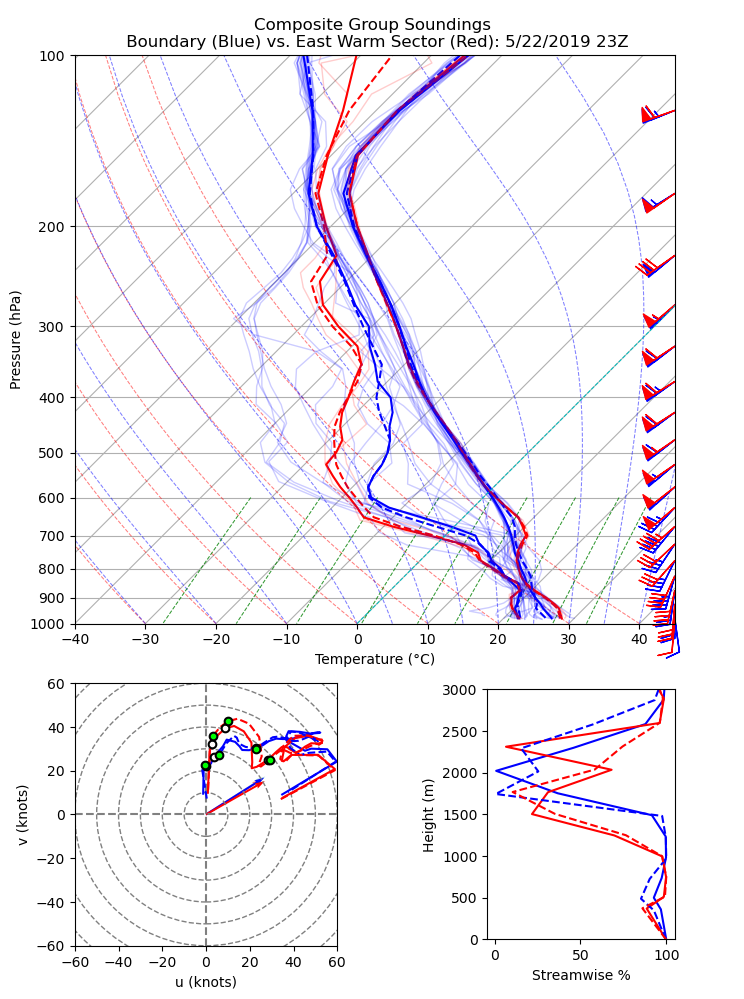

In [14]:
###########################################
#                                         #
#   MEDIAN BOUNDARY VS EAST WARM SECTOR   #
#                                         #
###########################################
#df = pd.read_excel("C:/Users/kyled/Desktop/HRRRouts/combined_EW.xlsx")
df = pd.read_csv('D:/THESIS/__UNL MS Thesis (MAIN)__/6 - SkewTs/5_22_VerticalProfs_QC_Grouped_BND.csv')

#D:\THESIS\__UNL MS Thesis (MAIN)__\6 - SkewTs

folder = r"D:\THESIS\__UNL MS Thesis (MAIN)__\6 - SkewTs\Soundings"
col_names = ['pressure', 'temperature', 'dewpoint', 'height', 'uwnd', 'vwnd']

time = 23
day = 22

combinedP_1 = []
combinedT_1 = []
combinedTd_1 = []
combinedH_1 = []
combinedU_1 = []
combinedV_1 = []

combinedP_W = []
combinedT_W = []
combinedTd_W = []
combinedH_W = []
combinedU_W = []
combinedV_W = []

combinedP_E = []
combinedT_E = []
combinedTd_E = []
combinedH_E = []
combinedU_E = []
combinedV_E = []

combinedP_2 = []
combinedT_2 = []
combinedTd_2 = []
combinedH_2 = []
combinedU_2 = []
combinedV_2 = []

interpP_W = []
interpT_W = []
interpTd_W = []
interpH_W = []
interpU_W = []
interpV_W = []

interpP_E = []
interpT_E = []
interpTd_E = []
interpH_E = []
interpU_E = []
interpV_E = []

sfcP_w = []
sfcT_w = []
sfcTd_w = []
sfcH_w = []
sfcU_w = []
sfcV_w = []

sfcP_e = []
sfcT_e = []
sfcTd_e = []
sfcH_e = []
sfcU_e = []
sfcV_e = []

###
combinedP_1sup = []
combinedT_1sup = []
combinedTd_1sup = []
combinedH_1sup = []
combinedU_1sup = []
combinedV_1sup = []

combinedP_Wsup = []
combinedT_Wsup = []
combinedTd_Wsup = []
combinedH_Wsup = []
combinedU_Wsup = []
combinedV_Wsup = []

combinedP_Esup = []
combinedT_Esup = []
combinedTd_Esup = []
combinedH_Esup = []
combinedU_Esup = []
combinedV_Esup = []

combinedP_2sup = []
combinedT_2sup = []
combinedTd_2sup = []
combinedH_2sup = []
combinedU_2sup = []
combinedV_2sup = []

interpP_Wsup = []
interpT_Wsup = []
interpTd_Wsup = []
interpH_Wsup = []
interpU_Wsup = []
interpV_Wsup = []

interpP_Esup = []
interpT_Esup = []
interpTd_Esup = []
interpH_Esup = []
interpU_Esup = []
interpV_Esup = []

sfcP_wsup = []
sfcT_wsup = []
sfcTd_wsup = []
sfcH_wsup = []
sfcU_wsup = []
sfcV_wsup = []

sfcP_esup = []
sfcT_esup = []
sfcTd_esup = []
sfcH_esup = []
sfcU_esup = []
sfcV_esup = []
###

interpP_W = [940.0, 925.0, 900.0, 875.0, 850.0, 825.0, 800.0, 775.0, 750.0, 725.0, 700.0, 675.0,
          650.0, 625.0, 600.0, 575.0, 550.0, 525.0, 500.0, 475.0, 450.0, 425.0, 400.0, 375.0,
          350.0, 325.0, 300.0, 275.0, 250.0, 225.0, 200.0, 175.0, 150.0, 125.0, 100.0]
interpP_E = [940.0, 925.0, 900.0, 875.0, 850.0, 825.0, 800.0, 775.0, 750.0, 725.0, 700.0, 675.0,
          650.0, 625.0, 600.0, 575.0, 550.0, 525.0, 500.0, 475.0, 450.0, 425.0, 400.0, 375.0,
          350.0, 325.0, 300.0, 275.0, 250.0, 225.0, 200.0, 175.0, 150.0, 125.0, 100.0]

interpP_Wsup = [940.0, 925.0, 900.0, 875.0, 850.0, 825.0, 800.0, 775.0, 750.0, 725.0, 700.0, 675.0,
          650.0, 625.0, 600.0, 575.0, 550.0, 525.0, 500.0, 475.0, 450.0, 425.0, 400.0, 375.0,
          350.0, 325.0, 300.0, 275.0, 250.0, 225.0, 200.0, 175.0, 150.0, 125.0, 100.0]
interpP_Esup = [940.0, 925.0, 900.0, 875.0, 850.0, 825.0, 800.0, 775.0, 750.0, 725.0, 700.0, 675.0,
          650.0, 625.0, 600.0, 575.0, 550.0, 525.0, 500.0, 475.0, 450.0, 425.0, 400.0, 375.0,
          350.0, 325.0, 300.0, 275.0, 250.0, 225.0, 200.0, 175.0, 150.0, 125.0, 100.0]

#for i in df[df.Grouping==1][df.Time==20]['Profile_Number']:
for i in df[df.EWB=='BND'][df.Time==time]['StormID']:
#for i in df[df.EW=='W'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        profW = profile.create_profile(profile='default', pres=sounding_df['pressure'], hght=sounding_df['height'],
                                       tmpc=sounding_df['temperature'], dwpc=sounding_df['dewpoint'],
                                       u=sounding_df['uwnd'], v=sounding_df['vwnd'], missing=-9999)
       
        sfcP_W = sharppy.sharptab.interp.pres(profW, 0)
        sfcT_W = sharppy.sharptab.interp.temp(profW, sfcP_W)
        sfcTd_W = sharppy.sharptab.interp.dwpt(profW, sfcP_W)
        sfcWind_W = sharppy.sharptab.interp.components(profW, sfcP_W)
        sfcU_W = sfcWind_W[0]
        sfcV_W = sfcWind_W[1]
        
        sfcP_w.append(sfcP_W)
        sfcT_w.append(sfcT_W)
        sfcTd_w.append(sfcTd_W)
        sfcU_w.append(sfcU_W)
        sfcV_w.append(sfcV_W)

        interpT_W = []
        interpTd_W = []
        interpH_W = []
        interpU_W = []
        interpV_W = []                
        
        for k in interpP_W:
            H_west = sharppy.sharptab.interp.hght(profW, k)
            T_west = sharppy.sharptab.interp.temp(profW, k)
            Td_west = sharppy.sharptab.interp.dwpt(profW, k)
            Wind_west = sharppy.sharptab.interp.components(profW, k)
            U_west = Wind_west[0]
            V_west = Wind_west[1]
            
            interpT_W.append(T_west)
            interpTd_W.append(Td_west)
            interpH_W.append(H_west)
            interpU_W.append(U_west)
            interpV_W.append(V_west)
        
        combinedP_W.append(np.asarray(interpP_W))
        combinedT_W.append(np.asarray(interpT_W))
        combinedTd_W.append(np.asarray(interpTd_W))
        combinedH_W.append(np.asarray(interpH_W))
        combinedU_W.append(np.asarray(interpU_W))
        combinedV_W.append(np.asarray(interpV_W))

#for i in df[df.Grouping==1][df.Time==20]['Profile_Number']:
for i in df[df.EWB=='BND'][df.Time==time][df.Supercell=="Y"]['StormID']:
#for i in df[df.EW=='W'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        profWsup = profile.create_profile(profile='default', pres=sounding_df['pressure'], hght=sounding_df['height'],
                                       tmpc=sounding_df['temperature'], dwpc=sounding_df['dewpoint'],
                                       u=sounding_df['uwnd'], v=sounding_df['vwnd'], missing=-9999)
       
        sfcP_Wsup = sharppy.sharptab.interp.pres(profWsup, 0)
        sfcT_Wsup = sharppy.sharptab.interp.temp(profWsup, sfcP_Wsup)
        sfcTd_Wsup = sharppy.sharptab.interp.dwpt(profWsup, sfcP_Wsup)
        sfcWind_Wsup = sharppy.sharptab.interp.components(profWsup, sfcP_Wsup)
        sfcU_Wsup = sfcWind_Wsup[0]
        sfcV_Wsup = sfcWind_Wsup[1]
        
        sfcP_wsup.append(sfcP_Wsup)
        sfcT_wsup.append(sfcT_Wsup)
        sfcTd_wsup.append(sfcTd_Wsup)
        sfcU_wsup.append(sfcU_Wsup)
        sfcV_wsup.append(sfcV_Wsup)

        interpT_Wsup = []
        interpTd_Wsup = []
        interpH_Wsup = []
        interpU_Wsup = []
        interpV_Wsup = []                
        
        for k in interpP_Wsup:
            H_westsup = sharppy.sharptab.interp.hght(profWsup, k)
            T_westsup = sharppy.sharptab.interp.temp(profWsup, k)
            Td_westsup = sharppy.sharptab.interp.dwpt(profWsup, k)
            Wind_westsup = sharppy.sharptab.interp.components(profWsup, k)
            U_westsup = Wind_westsup[0]
            V_westsup = Wind_westsup[1]
            
            interpT_Wsup.append(T_westsup)
            interpTd_Wsup.append(Td_westsup)
            interpH_Wsup.append(H_westsup)
            interpU_Wsup.append(U_westsup)
            interpV_Wsup.append(V_westsup)
        
        combinedP_Wsup.append(np.asarray(interpP_Wsup))
        combinedT_Wsup.append(np.asarray(interpT_Wsup))
        combinedTd_Wsup.append(np.asarray(interpTd_Wsup))
        combinedH_Wsup.append(np.asarray(interpH_Wsup))
        combinedU_Wsup.append(np.asarray(interpU_Wsup))
        combinedV_Wsup.append(np.asarray(interpV_Wsup))
        
for i in df[df.EWB=='OPE'][df.Time==time]['StormID']:
#for i in df[df.EW=='E'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        profE = profile.create_profile(profile='default', pres=sounding_df['pressure'], hght=sounding_df['height'],
                                       tmpc=sounding_df['temperature'], dwpc=sounding_df['dewpoint'],
                                       u=sounding_df['uwnd'], v=sounding_df['vwnd'], missing=-9999)
       
        sfcP_E = sharppy.sharptab.interp.pres(profE, 0)
        sfcT_E = sharppy.sharptab.interp.temp(profE, sfcP_E)
        sfcTd_E = sharppy.sharptab.interp.dwpt(profE, sfcP_E)
        sfcWind_E = sharppy.sharptab.interp.components(profE, sfcP_E)
        sfcU_E = sfcWind_E[0]
        sfcV_E = sfcWind_E[1]
        
        sfcP_e.append(sfcP_E)
        sfcT_e.append(sfcT_E)
        sfcTd_e.append(sfcTd_E)
        sfcU_e.append(sfcU_E)
        sfcV_e.append(sfcV_E)

        interpT_E = []
        interpTd_E = []
        interpH_E = []
        interpU_E = []
        interpV_E = []                
        
        for k in interpP_E:
            H_east = sharppy.sharptab.interp.hght(profE, k)
            T_east = sharppy.sharptab.interp.temp(profE, k)
            Td_east = sharppy.sharptab.interp.dwpt(profE, k)
            Wind_east = sharppy.sharptab.interp.components(profE, k)
            U_east = Wind_east[0]
            V_east = Wind_east[1]
            
            interpT_E.append(T_east)
            interpTd_E.append(Td_east)
            interpH_E.append(H_east)
            interpU_E.append(U_east)
            interpV_E.append(V_east)
                    
        combinedP_E.append(np.asarray(interpP_E))
        combinedT_E.append(np.asarray(interpT_E))
        combinedTd_E.append(np.asarray(interpTd_E))
        combinedH_E.append(np.asarray(interpH_E))
        combinedU_E.append(np.asarray(interpU_E))
        combinedV_E.append(np.asarray(interpV_E))

#for i in df[df.Grouping==1][df.Time==20]['Profile_Number']:
for i in df[df.EWB=='OPE'][df.Time==time][df.Supercell=="Y"]['StormID']:
#for i in df[df.EW=='W'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        profEsup = profile.create_profile(profile='default', pres=sounding_df['pressure'], hght=sounding_df['height'],
                                       tmpc=sounding_df['temperature'], dwpc=sounding_df['dewpoint'],
                                       u=sounding_df['uwnd'], v=sounding_df['vwnd'], missing=-9999)
       
        sfcP_Esup = sharppy.sharptab.interp.pres(profEsup, 0)
        sfcT_Esup = sharppy.sharptab.interp.temp(profEsup, sfcP_Esup)
        sfcTd_Esup = sharppy.sharptab.interp.dwpt(profEsup, sfcP_Esup)
        sfcWind_Esup = sharppy.sharptab.interp.components(profEsup, sfcP_Esup)
        sfcU_Esup = sfcWind_Esup[0]
        sfcV_Esup = sfcWind_Esup[1]
        
        sfcP_esup.append(sfcP_Esup)
        sfcT_esup.append(sfcT_Esup)
        sfcTd_esup.append(sfcTd_Esup)
        sfcU_esup.append(sfcU_Esup)
        sfcV_esup.append(sfcV_Esup)

        interpT_Esup = []
        interpTd_Esup = []
        interpH_Esup = []
        interpU_Esup = []
        interpV_Esup = []                
        
        for k in interpP_Esup:
            H_eastsup = sharppy.sharptab.interp.hght(profEsup, k)
            T_eastsup = sharppy.sharptab.interp.temp(profEsup, k)
            Td_eastsup = sharppy.sharptab.interp.dwpt(profEsup, k)
            Wind_eastsup = sharppy.sharptab.interp.components(profEsup, k)
            U_eastsup = Wind_eastsup[0]
            V_eastsup = Wind_eastsup[1]
            
            interpT_Esup.append(T_eastsup)
            interpTd_Esup.append(Td_eastsup)
            interpH_Esup.append(H_eastsup)
            interpU_Esup.append(U_eastsup)
            interpV_Esup.append(V_eastsup)
        
        combinedP_Esup.append(np.asarray(interpP_Esup))
        combinedT_Esup.append(np.asarray(interpT_Esup))
        combinedTd_Esup.append(np.asarray(interpTd_Esup))
        combinedH_Esup.append(np.asarray(interpH_Esup))
        combinedU_Esup.append(np.asarray(interpU_Esup))
        combinedV_Esup.append(np.asarray(interpV_Esup))
        
combinedP_W=np.asarray(combinedP_W)
combinedT_W=np.asarray(combinedT_W)
combinedTd_W=np.asarray(combinedTd_W)
combinedH_W=np.asarray(combinedH_W)
combinedU_W=np.asarray(combinedU_W)
combinedV_W=np.asarray(combinedV_W)

combinedP_E=np.asarray(combinedP_E)
combinedT_E=np.asarray(combinedT_E)
combinedTd_E=np.asarray(combinedTd_E)
combinedH_E=np.asarray(combinedH_E)
combinedU_E=np.asarray(combinedU_E)
combinedV_E=np.asarray(combinedV_E)

combinedP_Wsup=np.asarray(combinedP_Wsup)
combinedT_Wsup=np.asarray(combinedT_Wsup)
combinedTd_Wsup=np.asarray(combinedTd_Wsup)
combinedH_Wsup=np.asarray(combinedH_Wsup)
combinedU_Wsup=np.asarray(combinedU_Wsup)
combinedV_Wsup=np.asarray(combinedV_Wsup)

combinedP_Esup=np.asarray(combinedP_Esup)
combinedT_Esup=np.asarray(combinedT_Esup)
combinedTd_Esup=np.asarray(combinedTd_Esup)
combinedH_Esup=np.asarray(combinedH_Esup)
combinedU_Esup=np.asarray(combinedU_Esup)
combinedV_Esup=np.asarray(combinedV_Esup)
   
sfcP_w=np.asarray(sfcP_w)
sfcT_w=np.asarray(sfcT_w)
sfcTd_w=np.asarray(sfcTd_w)
sfcU_w=np.asarray(sfcU_w)
sfcV_w=np.asarray(sfcV_w)

sfcP_e=np.asarray(sfcP_e)
sfcT_e=np.asarray(sfcT_e)
sfcTd_e=np.asarray(sfcTd_e)
sfcU_e=np.asarray(sfcU_e)
sfcV_e=np.asarray(sfcV_e)

sfcP_wsup=np.asarray(sfcP_wsup)
sfcT_wsup=np.asarray(sfcT_wsup)
sfcTd_wsup=np.asarray(sfcTd_wsup)
sfcU_wsup=np.asarray(sfcU_wsup)
sfcV_wsup=np.asarray(sfcV_wsup)

sfcP_esup=np.asarray(sfcP_esup)
sfcT_esup=np.asarray(sfcT_esup)
sfcTd_esup=np.asarray(sfcTd_esup)
sfcU_esup=np.asarray(sfcU_esup)
sfcV_esup=np.asarray(sfcV_esup)

PRES_W=[]
TEMP_W=[]
DEWP_W=[]
HGHT_W=[]
UWND_W=[]
VWND_W=[]

PRES_E=[]
TEMP_E=[]
DEWP_E=[]
HGHT_E=[]
UWND_E=[]
VWND_E=[]

PRES_Wsup=[]
TEMP_Wsup=[]
DEWP_Wsup=[]
HGHT_Wsup=[]
UWND_Wsup=[]
VWND_Wsup=[]

PRES_Esup=[]
TEMP_Esup=[]
DEWP_Esup=[]
HGHT_Esup=[]
UWND_Esup=[]
VWND_Esup=[]

for l in range(0,len(sfcP_w)):
    PRES_W.append(np.insert(combinedP_W[l],0,sfcP_w[l]))
    TEMP_W.append(np.insert(combinedT_W[l],0,sfcT_w[l]))
    DEWP_W.append(np.insert(combinedTd_W[l],0,sfcTd_w[l]))
    HGHT_W.append(np.insert(combinedH_W[l],0,0))
    UWND_W.append(np.insert(combinedU_W[l],0,sfcU_w[l]))
    VWND_W.append(np.insert(combinedV_W[l],0,sfcV_w[l]))

for l in range(0,len(sfcP_e)):
    PRES_E.append(np.insert(combinedP_E[l],0,sfcP_e[l]))
    TEMP_E.append(np.insert(combinedT_E[l],0,sfcT_e[l]))
    DEWP_E.append(np.insert(combinedTd_E[l],0,sfcTd_e[l]))
    HGHT_E.append(np.insert(combinedH_E[l],0,0))
    UWND_E.append(np.insert(combinedU_E[l],0,sfcU_e[l]))
    VWND_E.append(np.insert(combinedV_E[l],0,sfcV_e[l]))

for l in range(0,len(sfcP_wsup)):
    PRES_Wsup.append(np.insert(combinedP_Wsup[l],0,sfcP_wsup[l]))
    TEMP_Wsup.append(np.insert(combinedT_Wsup[l],0,sfcT_wsup[l]))
    DEWP_Wsup.append(np.insert(combinedTd_Wsup[l],0,sfcTd_wsup[l]))
    HGHT_Wsup.append(np.insert(combinedH_Wsup[l],0,0))
    UWND_Wsup.append(np.insert(combinedU_Wsup[l],0,sfcU_wsup[l]))
    VWND_Wsup.append(np.insert(combinedV_Wsup[l],0,sfcV_wsup[l]))

for l in range(0,len(sfcP_esup)):
    PRES_Esup.append(np.insert(combinedP_Esup[l],0,sfcP_esup[l]))
    TEMP_Esup.append(np.insert(combinedT_Esup[l],0,sfcT_esup[l]))
    DEWP_Esup.append(np.insert(combinedTd_Esup[l],0,sfcTd_esup[l]))
    HGHT_Esup.append(np.insert(combinedH_Esup[l],0,0))
    UWND_Esup.append(np.insert(combinedU_Esup[l],0,sfcU_esup[l]))
    VWND_Esup.append(np.insert(combinedV_Esup[l],0,sfcV_esup[l]))
    
#PRES_W=np.asarray(PRES_W)        
combinedP_1=pd.DataFrame(PRES_W).T
combinedT_1=pd.DataFrame(TEMP_W).T
combinedTd_1=pd.DataFrame(DEWP_W).T
combinedH_1=pd.DataFrame(HGHT_W).T
combinedU_1=pd.DataFrame(UWND_W).T
combinedV_1=pd.DataFrame(VWND_W).T        

combinedP_2=pd.DataFrame(PRES_E).T
combinedT_2=pd.DataFrame(TEMP_E).T
combinedTd_2=pd.DataFrame(DEWP_E).T
combinedH_2=pd.DataFrame(HGHT_E).T
combinedU_2=pd.DataFrame(UWND_E).T
combinedV_2=pd.DataFrame(VWND_E).T        

combinedP_1sup=pd.DataFrame(PRES_Wsup).T
combinedT_1sup=pd.DataFrame(TEMP_Wsup).T
combinedTd_1sup=pd.DataFrame(DEWP_Wsup).T
combinedH_1sup=pd.DataFrame(HGHT_Wsup).T
combinedU_1sup=pd.DataFrame(UWND_Wsup).T
combinedV_1sup=pd.DataFrame(VWND_Wsup).T        

combinedP_2sup=pd.DataFrame(PRES_Esup).T
combinedT_2sup=pd.DataFrame(TEMP_Esup).T
combinedTd_2sup=pd.DataFrame(DEWP_Esup).T
combinedH_2sup=pd.DataFrame(HGHT_Esup).T
combinedU_2sup=pd.DataFrame(UWND_Esup).T
combinedV_2sup=pd.DataFrame(VWND_Esup).T   

combinedP_1['meanP'] = combinedP_1.median(axis=1)
combinedT_1['meanT'] = combinedT_1.median(axis=1)
combinedTd_1['meanTd'] = combinedTd_1.median(axis=1)
combinedH_1['meanH'] = combinedH_1.median(axis=1)
combinedU_1['meanU'] = combinedU_1.median(axis=1)
combinedV_1['meanV'] = combinedV_1.median(axis=1)
        
combinedP_2['meanP'] = combinedP_2.median(axis=1)
combinedT_2['meanT'] = combinedT_2.median(axis=1)
combinedTd_2['meanTd'] = combinedTd_2.median(axis=1)
combinedH_2['meanH'] = combinedH_2.median(axis=1)
combinedU_2['meanU'] = combinedU_2.median(axis=1)
combinedV_2['meanV'] = combinedV_2.median(axis=1)

combinedP_1sup['meanP'] = combinedP_1sup.median(axis=1)
combinedT_1sup['meanT'] = combinedT_1sup.median(axis=1)
combinedTd_1sup['meanTd'] = combinedTd_1sup.median(axis=1)
combinedH_1sup['meanH'] = combinedH_1sup.median(axis=1)
combinedU_1sup['meanU'] = combinedU_1sup.median(axis=1)
combinedV_1sup['meanV'] = combinedV_1sup.median(axis=1)
        
combinedP_2sup['meanP'] = combinedP_2sup.median(axis=1)
combinedT_2sup['meanT'] = combinedT_2sup.median(axis=1)
combinedTd_2sup['meanTd'] = combinedTd_2sup.median(axis=1)
combinedH_2sup['meanH'] = combinedH_2sup.median(axis=1)
combinedU_2sup['meanU'] = combinedU_2sup.median(axis=1)
combinedV_2sup['meanV'] = combinedV_2sup.median(axis=1)

#######################################################
#Shear Calculations
u_1 = np.asarray(combinedU_1['meanU'])/1.944
v_1 = np.asarray(combinedV_1['meanV'])/1.944
z_1 = np.asarray(combinedH_1['meanH'])

u_2 = np.asarray(combinedU_2['meanU'])/1.944
v_2 = np.asarray(combinedV_2['meanV'])/1.944
z_2 = np.asarray(combinedH_2['meanH'])

profMS_W = profile.create_profile(profile='default', pres=np.asarray(combinedP_1['meanP']), hght=z_1,
                               tmpc=np.asarray(combinedT_1['meanT']), dwpc=np.asarray(combinedTd_1['meanTd']),
                               u=u_1, v=v_1, missing=-9999)
profMS_E = profile.create_profile(profile='default', pres=np.asarray(combinedP_2['meanP']), hght=z_2,
                               tmpc=np.asarray(combinedT_2['meanT']), dwpc=np.asarray(combinedTd_2['meanTd']),
                               u=u_2, v=v_2, missing=-9999)

srwindW = params.bunkers_storm_motion(profMS_W)
srwindE = params.bunkers_storm_motion(profMS_E)

uSR_W = u_1-srwindW[0]
uSR_E = u_2-srwindE[0]

vSR_W = v_1-srwindW[1]
vSR_E = v_2-srwindE[1]

dudz_W=(np.array(u_1[2::])-np.array(u_1[0:-2]))/(np.array(z_1[2::])-np.array(z_1[0:-2]))
dvdz_W=(np.array(v_1[2::])-np.array(v_1[0:-2]))/(np.array(z_1[2::])-np.array(z_1[0:-2]))
dudz_W=np.insert(dudz_W,0,dudz_W[0])
dudz_W=np.insert(dudz_W,-1,dudz_W[-1])
dvdz_W=np.insert(dvdz_W,0,dvdz_W[0])
dvdz_W=np.insert(dvdz_W,-1,dvdz_W[-1])

dudz_E=(np.array(u_2[2::])-np.array(u_2[0:-2]))/(np.array(z_2[2::])-np.array(z_2[0:-2]))
dvdz_E=(np.array(v_2[2::])-np.array(v_2[0:-2]))/(np.array(z_2[2::])-np.array(z_2[0:-2]))
dudz_E=np.insert(dudz_E,0,dudz_E[0])
dudz_E=np.insert(dudz_E,-1,dudz_E[-1])
dvdz_E=np.insert(dvdz_E,0,dvdz_E[0])
dvdz_E=np.insert(dvdz_E,-1,dvdz_E[-1])

shear_W=np.sqrt(dudz_W**2+dvdz_W**2)+0.0000001
# Vorticity components
uvort_W=-dvdz_W
vvort_W=dudz_W
# Streamwise vorticity
strmw_W=abs((uSR_W*uvort_W+vSR_W*vvort_W)/(np.sqrt(uSR_W**2+vSR_W**2)))
# Streamwise fraction
strmwperc_W=strmw_W/shear_W

shear_E=np.sqrt(dudz_E**2+dvdz_E**2)+0.0000001
# Vorticity components
uvort_E=-dvdz_E
vvort_E=dudz_E
# Streamwise vorticity
strmw_E=abs((uSR_E*uvort_E+vSR_E*vvort_E)/(np.sqrt(uSR_E**2+vSR_E**2)))
# Streamwise fraction
strmwperc_E=strmw_E/shear_E

#################################################
#Shear Calculations
if len(df[df.EWB=='BND'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    u_1sup = np.asarray(combinedU_1sup['meanU'])/1.944
    v_1sup = np.asarray(combinedV_1sup['meanV'])/1.944
    z_1sup = np.asarray(combinedH_1sup['meanH'])

    profMS_Wsup = profile.create_profile(profile='default', pres=np.asarray(combinedP_1sup['meanP']), hght=z_1sup,
                               tmpc=np.asarray(combinedT_1sup['meanT']), dwpc=np.asarray(combinedTd_1sup['meanTd']),
                               u=u_1sup, v=v_1sup, missing=-9999)
    
    srwindWsup = params.bunkers_storm_motion(profMS_Wsup)
    uSR_Wsup = u_1sup-srwindWsup[0]
    vSR_Wsup = v_1sup-srwindWsup[1]
    
    dudz_Wsup=(np.array(u_1sup[2::])-np.array(u_1sup[0:-2]))/(np.array(z_1sup[2::])-np.array(z_1sup[0:-2]))
    dvdz_Wsup=(np.array(v_1sup[2::])-np.array(v_1sup[0:-2]))/(np.array(z_1sup[2::])-np.array(z_1sup[0:-2]))
    dudz_Wsup=np.insert(dudz_Wsup,0,dudz_Wsup[0])
    dudz_Wsup=np.insert(dudz_Wsup,-1,dudz_Wsup[-1])
    dvdz_Wsup=np.insert(dvdz_Wsup,0,dvdz_Wsup[0])
    dvdz_Wsup=np.insert(dvdz_Wsup,-1,dvdz_Wsup[-1])
    
    shear_Wsup=np.sqrt(dudz_Wsup**2+dvdz_Wsup**2)+0.0000001
    # Vorticity components
    uvort_Wsup=-dvdz_Wsup
    vvort_Wsup=dudz_Wsup
    # Streamwise vorticity
    strmw_Wsup=abs((uSR_Wsup*uvort_Wsup+vSR_Wsup*vvort_Wsup)/(np.sqrt(uSR_Wsup**2+vSR_Wsup**2)))
    # Streamwise fraction
    strmwperc_Wsup=strmw_Wsup/shear_Wsup
    
if len(df[df.EWB=='OPE'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    u_2sup = np.asarray(combinedU_2sup['meanU'])/1.944
    v_2sup = np.asarray(combinedV_2sup['meanV'])/1.944
    z_2sup = np.asarray(combinedH_2sup['meanH'])


    profMS_Esup = profile.create_profile(profile='default', pres=np.asarray(combinedP_2sup['meanP']), hght=z_2sup,
                                   tmpc=np.asarray(combinedT_2sup['meanT']), dwpc=np.asarray(combinedTd_2sup['meanTd']),
                                   u=u_2sup, v=v_2sup, missing=-9999)
    
    srwindEsup = params.bunkers_storm_motion(profMS_Esup)
    uSR_Esup = u_2sup-srwindEsup[0]
    vSR_Esup = v_2sup-srwindEsup[1]

    dudz_Esup=(np.array(u_2sup[2::])-np.array(u_2sup[0:-2]))/(np.array(z_2sup[2::])-np.array(z_2sup[0:-2]))
    dvdz_Esup=(np.array(v_2sup[2::])-np.array(v_2sup[0:-2]))/(np.array(z_2sup[2::])-np.array(z_2sup[0:-2]))
    dudz_Esup=np.insert(dudz_Esup,0,dudz_Esup[0])
    dudz_Esup=np.insert(dudz_Esup,-1,dudz_Esup[-1])
    dvdz_Esup=np.insert(dvdz_Esup,0,dvdz_Esup[0])
    dvdz_Esup=np.insert(dvdz_Esup,-1,dvdz_Esup[-1])

    shear_Esup=np.sqrt(dudz_Esup**2+dvdz_Esup**2)+0.0000001
    # Vorticity components
    uvort_Esup=-dvdz_Esup
    vvort_Esup=dudz_Esup
    # Streamwise vorticity
    strmw_Esup=abs((uSR_Esup*uvort_Esup+vSR_Esup*vvort_Esup)/(np.sqrt(uSR_Esup**2+vSR_Esup**2)))
    # Streamwise fraction
    strmwperc_Esup=strmw_Esup/shear_Esup

#######################################################
fig = plt.figure(figsize=(7.5, 10))
#gs=gridspec.GridSpec(nrows=6, ncols=4, figure=fig)

#ax0 = plt.subplot(gs.new_subplotspec((0,0), rowspan=4, colspan=4))

skew = SkewT(fig, rotation=45, rect=(0, 0.25, 0.8, 0.8)) # left, bottom, width, height (range 0 to 1)
#skew = SkewT(ax0, rotation=45)
#skew = SkewT(fig, rotation=45, subplot=gs[0:3, 0:3])

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot.

hpa100 = np.where(combinedP_1['meanP'] >=100)

skew.plot(combinedP_1['meanP'], combinedT_1['meanT'], 'b', linestyle='-', linewidth=1.5)
skew.plot(combinedP_1['meanP'], combinedTd_1['meanTd'], 'b', linestyle='-', linewidth=1.5)
skew.plot_barbs(combinedP_1['meanP'][hpa100[0]][::2], combinedU_1['meanU'][hpa100[0]][::2], combinedV_1['meanV'][hpa100[0]][::2], color='blue')
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 45)
skew.ax.set_ylabel('Pressure (hPa)')
skew.ax.set_xlabel('Temperature (°C)')

skew.plot(combinedP_2['meanP'], combinedT_2['meanT'], 'r', linestyle='-', linewidth=1.5)
skew.plot(combinedP_2['meanP'], combinedTd_2['meanTd'], 'r', linestyle='-', linewidth=1.5)
skew.plot_barbs(combinedP_2['meanP'][hpa100[0]][::2], combinedU_2['meanU'][hpa100[0]][::2], combinedV_2['meanV'][hpa100[0]][::2], color='red')

skew.plot(combinedP_1sup['meanP'], combinedT_1sup['meanT'], 'b', linestyle='--', linewidth=1.5)
skew.plot(combinedP_1sup['meanP'], combinedTd_1sup['meanTd'], 'b', linestyle='--', linewidth=1.5)
skew.plot(combinedP_2sup['meanP'], combinedT_2sup['meanT'], 'r', linestyle='--', linewidth=1.5)
skew.plot(combinedP_2sup['meanP'], combinedTd_2sup['meanTd'], 'r', linestyle='--', linewidth=1.5)

for i in df[df.EWB=='OPE'][df.Time==time]['StormID']:
#for i in df[df.EW=='E'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        skew.plot(np.asarray(sounding_df['pressure']), np.asarray(sounding_df['temperature']), 'r', linewidth=1.0, alpha=0.2)
        skew.plot(np.asarray(sounding_df['pressure']), np.asarray(sounding_df['dewpoint']), 'r', linewidth=1.0, alpha=0.2)

for i in df[df.EWB=='BND'][df.Time==time]['StormID']:
#for i in df[df.EW=='E'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        skew.plot(np.asarray(sounding_df['pressure']), np.asarray(sounding_df['temperature']), 'b', linewidth=1.0, alpha=0.2)
        skew.plot(np.asarray(sounding_df['pressure']), np.asarray(sounding_df['dewpoint']), 'b', linewidth=1.0, alpha=0.2)

        
#skew.plot(p2, T2, 'b')
#skew.plot(p2, Td2, 'b')
#skew.plot_barbs(p2[::150], u2[::150], v2[::150], color='blue')

# Calculate LCL height and plot as black dot. Because `p`'s first value is
# ~1000 mb and its last value is ~250 mb, the `0` index is selected for
# `p`, `T`, and `Td` to lift the parcel from the surface. If `p` was inverted,
# i.e. start from low value, 250 mb, to a high value, 1000 mb, the `-1` index
# should be selected.

#lcl_pressure, lcl_temperature = lcl(p[0], T[0], Td[0])
#skew.plot(lcl_pressure, lcl_temperature, marker=11, markerfacecolor='black', markers)

# Calculate full parcel profile and add to plot as black line
#prof = parcel_profile(p, T[0], Td[0]).to('degC')

#prof1 = mixed_parcel(p, T, Td)
#prof = parcel_profile(p, prof1[1], prof1[2]).to('degC')
#prof = parcel_profile(p, mlpcl.tmpc*units.degree_Celsius, mlpcl.dwpc*units.degree_Celsius).to('degC')


#mlpcl.tmpc*units.degree_Celsius
#skew.plot(p, prof, 'k', linewidth=1.5, linestyle='--')

# Shade areas of CAPE and CIN
#skew.shade_cin(p, T, prof, Td)
#skew.shade_cape(p, T, prof)

# An example of a slanted line at constant T -- in this case the 0
# isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=0.75)
#skew.ax.axvline(-20, color='c', linestyle='--', linewidth=1)
#skew.ax.axvline(-30, color='c', linestyle='--', linewidth=1)

#hgt0c = (mupcl.hght0c*units.meter).to(units.feet)
#hgtm20c = (mupcl.hghtm20c*units.meter).to(units.feet)
#hgtm30c = (mupcl.hghtm30c*units.meter).to(units.feet)

# Add the relevant special lines
skew.plot_dry_adiabats(linewidth=0.75)
skew.plot_moist_adiabats(linewidth=0.75)
skew.plot_mixing_lines(linewidth=0.75)

plt.title("Composite Group Soundings \n Boundary (Blue) vs. East Warm Sector (Red): 5/"+str(day)+"/2019 "+str(time)+"Z")

#plt.title("Composite Group Soundings (Warm Sector) \n West (Blue) vs. East (Red): 5/"+str(day)+"/2019 "+str(time)+"Z")
#plt.title("Composite Group Soundings (Supercells) \n West (Blue) vs. East (Red): 5/"+str(day)+"/2019 "+str(time)+"Z")
#plt.title("Composite Group Soundings (Supercells) \n West (Blue) vs. East (Red): 5/"+str(day)+"/2019 "+str(time)+"Z")
#plt.title("Composite Group Soundings (Supercells) \n West (Blue) vs. East (Red): 5/23/2019 "+str(time)+"Z")

# Add a secondary axis that automatically converts between pressure and height
# assuming a standard atmosphere. The value of -0.12 puts the secondary axis
# 0.12 normalized (0 to 1) coordinates left of the original axis.
#secax = skew.ax.secondary_yaxis(-0.14,
#    functions=(lambda p: pressure_to_height_std(units.Quantity(p, 'mbar')).m_as('feet'),
#               lambda h: height_to_pressure_std(units.Quantity(h, 'feet')).m))

#fig = plt.figure(figsize=(12, 12))
#gs=gridspec.GridSpec(2,2)


#ax = fig.add_subplot(gs[4,0])
#ax = plt.subplot(gs.new_subplotspec((4,0), rowspan=2, colspan=2))
#ax = fig.add_subplot(gs[1:2,3:])

ax = plt.axes((0, 0, 0.35, 0.35))
h = Hodograph(ax, component_range=60.)
h.add_grid(increment=10)
h.ax.set_xlabel('u (knots)')
h.ax.set_ylabel('v (knots)')

height_scale = combinedH_1['meanH'][hpa100[0]].values
height = combinedH_1['meanH'][hpa100[0]].values * units.m

h.plot(combinedU_1['meanU'][hpa100[0]],combinedV_1['meanV'][hpa100[0]], alpha = 1.0,linewidth=1.5, color='blue')
h.plot(combinedU_2['meanU'][hpa100[0]],combinedV_2['meanV'][hpa100[0]], alpha = 1.0,linewidth=1.5, color='red')

if len(df[df.EWB=='BND'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    h.plot(combinedU_1sup['meanU'][hpa100[0]],combinedV_1sup['meanV'][hpa100[0]], alpha = 1.0,linewidth=1.5, linestyle="--", color='blue')

if len(df[df.EWB=='OPE'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    h.plot(combinedU_2sup['meanU'][hpa100[0]],combinedV_2sup['meanV'][hpa100[0]], alpha = 1.0,linewidth=1.5, linestyle="--", color='red')

for i in df[df.EWB=='OPE'][df.Time==time]['StormID']:
#for i in df[df.EW=='E'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        #h.plot(np.asarray(sounding_df['uwnd'][hpa100[0]]), np.asarray(sounding_df['vwnd'][hpa100[0]]), linewidth=1.0, alpha=0.3, color='red')

for i in df[df.EWB=='BND'][df.Time==time]['StormID']:
#for i in df[df.EW=='E'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        #h.plot(np.asarray(sounding_df['uwnd'][hpa100[0]]), np.asarray(sounding_df['vwnd'][hpa100[0]]), linewidth=1.0, alpha=0.3, color='blue')

#cmap_W = plt.cm.winter_r
#cmap_E = plt.cm.autumn_r
#cmap_W = truncate_colormap(cmap_W, 0.35, 0.85)
#cmap_E = truncate_colormap(cmap_E, 0.35, 0.85)

#for i in range(0, v3000E):
    #w_3km = h.plot(combinedU_1['meanU'][hpa100[0]][i:i+2],combinedV_1['meanV'][hpa100[0]][i:i+2], alpha = 0.6, linewidth=180*shear_W[i], color=cmap_W(int(strmwperc_W[i]*255)))
    #e_3km = h.plot(combinedU_2['meanU'][hpa100[0]][i:i+2],combinedV_2['meanV'][hpa100[0]][i:i+2], alpha = 0.6, linewidth=180*shear_E[i], color=cmap_E(int(strmwperc_E[i]*255)))
    #w_3km = h.plot(combinedU_1['meanU'][hpa100[0]][i:i+2],combinedV_1['meanV'][hpa100[0]][i:i+2], linewidth=2.0, color=cmap_W(int(strmwperc_W[i]*255)))
    #e_3km = h.plot(combinedU_2['meanU'][hpa100[0]][i:i+2],combinedV_2['meanV'][hpa100[0]][i:i+2], linewidth=2.0, color=cmap_E(int(strmwperc_E[i]*255)))
#h.plot_colormapped(combinedU_1['meanU'][hpa100[0]],combinedV_1['meanV'][hpa100[0]], height_scale, cmap=plt.cm.Blues,intervals=[10,15,25], linewidth=2)
#h.plot_colormapped(combinedU_2['meanU'][hpa100[0]],combinedV_2['meanV'][hpa100[0]], height_scale, cmap=plt.cm.Reds,intervals=[10,15,25], linewidth=2)

#h.plot(combinedU_1['meanU'][hpa100[0]][13],combinedV_1['meanV'][hpa100[0]][13], marker="s")
#h.ax.text(combinedU_1['meanU'][hpa100[0]][5],combinedV_1['meanV'][hpa100[0]][5],'1',fontsize=24,ha='left',fontweight='bold', color='black')
#h.ax.text(combinedU_2['meanU'][hpa100[0]][5],combinedV_2['meanV'][hpa100[0]][5],'1',fontsize=24,ha='left',fontweight='bold', color='black')

val500W = find_nearest(combinedH_1['meanH'][hpa100[0]], 500)
val500posW = np.where(combinedH_1['meanH'][hpa100[0]] == val500W)
v500W = val500posW[0][0]

val1000W = find_nearest(combinedH_1['meanH'][hpa100[0]], 1000)
val1000posW = np.where(combinedH_1['meanH'][hpa100[0]] == val1000W)
v1000W = val1000posW[0][0]

val3000W = find_nearest(combinedH_1['meanH'][hpa100[0]], 3000)
val3000posW = np.where(combinedH_1['meanH'][hpa100[0]] == val3000W)
v3000W = val3000posW[0][0]

val500E = find_nearest(combinedH_2['meanH'][hpa100[0]], 500)
val500posE = np.where(combinedH_2['meanH'][hpa100[0]] == val500E)
v500E = val500posE[0][0]

val1000E = find_nearest(combinedH_2['meanH'][hpa100[0]], 1000)
val1000posE = np.where(combinedH_2['meanH'][hpa100[0]] == val1000E)
v1000E = val1000posE[0][0]

val3000E = find_nearest(combinedH_2['meanH'][hpa100[0]], 3000)
val3000posE = np.where(combinedH_2['meanH'][hpa100[0]] == val3000E)
v3000E = val3000posE[0][0]

###########
if len(df[df.EWB=='BND'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    val500Wsup = find_nearest(combinedH_1sup['meanH'][hpa100[0]], 500)
    val500posWsup = np.where(combinedH_1sup['meanH'][hpa100[0]] == val500Wsup)
    v500Wsup = val500posWsup[0][0]

    val1000Wsup = find_nearest(combinedH_1sup['meanH'][hpa100[0]], 1000)
    val1000posWsup = np.where(combinedH_1sup['meanH'][hpa100[0]] == val1000Wsup)
    v1000Wsup = val1000posWsup[0][0]

    val3000Wsup = find_nearest(combinedH_1sup['meanH'][hpa100[0]], 3000)
    val3000posWsup = np.where(combinedH_1sup['meanH'][hpa100[0]] == val3000Wsup)
    v3000Wsup = val3000posWsup[0][0]

if len(df[df.EWB=='OPE'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    val500Esup = find_nearest(combinedH_2sup['meanH'][hpa100[0]], 500)
    val500posEsup = np.where(combinedH_2sup['meanH'][hpa100[0]] == val500Esup)
    v500Esup = val500posEsup[0][0]

    val1000Esup = find_nearest(combinedH_2sup['meanH'][hpa100[0]], 1000)
    val1000posEsup = np.where(combinedH_2sup['meanH'][hpa100[0]] == val1000Esup)
    v1000Esup = val1000posEsup[0][0]

    val3000Esup = find_nearest(combinedH_2sup['meanH'][hpa100[0]], 3000)
    val3000posEsup = np.where(combinedH_2sup['meanH'][hpa100[0]] == val3000Esup)
    v3000Esup = val3000posEsup[0][0]

############
h.plot(combinedU_1['meanU'][hpa100[0]][v500W],combinedV_1['meanV'][hpa100[0]][v500W], marker="o", color='black', markersize=6)
h.plot(combinedU_1['meanU'][hpa100[0]][v1000W],combinedV_1['meanV'][hpa100[0]][v1000W], marker="o", color='black', markersize=6)
h.plot(combinedU_1['meanU'][hpa100[0]][v3000W],combinedV_1['meanV'][hpa100[0]][v3000W], marker="o", color='black', markersize=6)

h.plot(combinedU_2['meanU'][hpa100[0]][v500E],combinedV_2['meanV'][hpa100[0]][v500E], marker="o", color='black', markersize=6)
h.plot(combinedU_2['meanU'][hpa100[0]][v1000E],combinedV_2['meanV'][hpa100[0]][v1000E], marker="o", color='black', markersize=6)
h.plot(combinedU_2['meanU'][hpa100[0]][v3000E],combinedV_2['meanV'][hpa100[0]][v3000E], marker="o", color='black', markersize=6)

h.plot(combinedU_1['meanU'][hpa100[0]][v500W],combinedV_1['meanV'][hpa100[0]][v500W], marker="o", color='snow', markersize=3)
h.plot(combinedU_1['meanU'][hpa100[0]][v1000W],combinedV_1['meanV'][hpa100[0]][v1000W], marker="o", color='snow', markersize=3)
h.plot(combinedU_1['meanU'][hpa100[0]][v3000W],combinedV_1['meanV'][hpa100[0]][v3000W], marker="o", color='snow', markersize=3)

h.plot(combinedU_2['meanU'][hpa100[0]][v500E],combinedV_2['meanV'][hpa100[0]][v500E], marker="o", color='snow', markersize=3)
h.plot(combinedU_2['meanU'][hpa100[0]][v1000E],combinedV_2['meanV'][hpa100[0]][v1000E], marker="o", color='snow', markersize=3)
h.plot(combinedU_2['meanU'][hpa100[0]][v3000E],combinedV_2['meanV'][hpa100[0]][v3000E], marker="o", color='snow', markersize=3)

ax1 = plt.axes((0.55, 0.05, 0.25, 0.25))
ax1.plot(strmwperc_W[0:v3000W+2]*100, z_1[0:v3000W+2], color="blue")
ax1.plot(strmwperc_E[0:v3000E+2]*100, z_2[0:v3000E+2], color="red")

############
if len(df[df.EWB=='BND'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    h.plot(combinedU_1sup['meanU'][hpa100[0]][v500Wsup],combinedV_1sup['meanV'][hpa100[0]][v500Wsup], marker="o", color='black', markersize=6)
    h.plot(combinedU_1sup['meanU'][hpa100[0]][v1000Wsup],combinedV_1sup['meanV'][hpa100[0]][v1000Wsup], marker="o", color='black', markersize=6)
    h.plot(combinedU_1sup['meanU'][hpa100[0]][v3000Wsup],combinedV_1sup['meanV'][hpa100[0]][v3000Wsup], marker="o", color='black', markersize=6)

    h.plot(combinedU_1sup['meanU'][hpa100[0]][v500Wsup],combinedV_1sup['meanV'][hpa100[0]][v500Wsup], marker="o", color='lime', markersize=3)
    h.plot(combinedU_1sup['meanU'][hpa100[0]][v1000Wsup],combinedV_1sup['meanV'][hpa100[0]][v1000Wsup], marker="o", color='lime', markersize=3)
    h.plot(combinedU_1sup['meanU'][hpa100[0]][v3000Wsup],combinedV_1sup['meanV'][hpa100[0]][v3000Wsup], marker="o", color='lime', markersize=3)

    right1, left1, mean1 = bunkers_storm_motion(np.asarray(combinedP_1sup['meanP'][hpa100[0]])* units.hPa, np.asarray(combinedU_1sup['meanU'][hpa100[0]])* units.knot,np.asarray(combinedV_1sup['meanV'][hpa100[0]])* units.knot, np.asarray(combinedH_1sup['meanH'][hpa100[0]])* units.meter)
    h.wind_vectors(right1[0], right1[1], color='lightblue', linestyle="--")
    #h.ax.text(right1[0], right1[1],'M',fontsize=36,fontweight='bold', color='blue')
    ax1.plot(strmwperc_Wsup[0:v3000Wsup+2]*100, z_1sup[0:v3000Wsup+2], color="blue", linestyle="--")
    
if len(df[df.EWB=='OPE'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    h.plot(combinedU_2sup['meanU'][hpa100[0]][v500Esup],combinedV_2sup['meanV'][hpa100[0]][v500Esup], marker="o", color='black', markersize=6)
    h.plot(combinedU_2sup['meanU'][hpa100[0]][v1000Esup],combinedV_2sup['meanV'][hpa100[0]][v1000Esup], marker="o", color='black', markersize=6)
    h.plot(combinedU_2sup['meanU'][hpa100[0]][v3000Esup],combinedV_2sup['meanV'][hpa100[0]][v3000Esup], marker="o", color='black', markersize=6)

    h.plot(combinedU_2sup['meanU'][hpa100[0]][v500Esup],combinedV_2sup['meanV'][hpa100[0]][v500Esup], marker="o", color='lime', markersize=3)
    h.plot(combinedU_2sup['meanU'][hpa100[0]][v1000Esup],combinedV_2sup['meanV'][hpa100[0]][v1000Esup], marker="o", color='lime', markersize=3)
    h.plot(combinedU_2sup['meanU'][hpa100[0]][v3000Esup],combinedV_2sup['meanV'][hpa100[0]][v3000Esup], marker="o", color='lime', markersize=3)
    
    right2, left2, mean2 = bunkers_storm_motion(np.asarray(combinedP_2sup['meanP'][hpa100[0]])* units.hPa, np.asarray(combinedU_2['meanU'][hpa100[0]])* units.knot,np.asarray(combinedV_2sup['meanV'][hpa100[0]])* units.knot, np.asarray(combinedH_2sup['meanH'][hpa100[0]])* units.meter)
    h.wind_vectors(right2[0], right2[1], color='lightcoral',linestyle="--")
       
    ax1.plot(strmwperc_Esup[0:v3000Esup+2]*100, z_2sup[0:v3000Esup+2], color="red", linestyle="--")
############
#for i in range(0,int(30)):
#    ax.plot(uSR[i:i+2]*1.944,vSR[i:i+2]*1.944,lw=180*shear[i],color=cmap(int(strmwperc[i]*255)))

#colors=['black','black','black','darkgray',[0.6,0.6,0.6]]

# Shear magnitude graphic
#for i in range(0,4):
#    ax.plot([-56+15*i,-48+15*i],[-45,-45],color=colors[2],lw=180*(0.01+0.01*i))

# Shear magnitude labels
#for i in range(0,4):
#    ax.text(-52+15*i,-48,str(0.01+0.01*i),fontsize=8,color=colors[1],ha='center',va='top')  

# Shear magnitude title
#ax.text(-30,-58,'Shear Magnitude (1/s)',fontsize=9,color=colors[1],ha='center')

right1, left1, mean1 = bunkers_storm_motion(np.asarray(combinedP_1['meanP'][hpa100[0]])* units.hPa, np.asarray(combinedU_1['meanU'][hpa100[0]])* units.knot,np.asarray(combinedV_1['meanV'][hpa100[0]])* units.knot, np.asarray(combinedH_1['meanH'][hpa100[0]])* units.meter)
h.wind_vectors(right1[0], right1[1], color='blue')
#h.ax.text(right1[0], right1[1],'M',fontsize=36,fontweight='bold', color='blue')

right2, left2, mean2 = bunkers_storm_motion(np.asarray(combinedP_2['meanP'][hpa100[0]])* units.hPa, np.asarray(combinedU_2['meanU'][hpa100[0]])* units.knot,np.asarray(combinedV_2['meanV'][hpa100[0]])* units.knot, np.asarray(combinedH_2['meanH'][hpa100[0]])* units.meter)
h.wind_vectors(right2[0], right2[1], color='red')
############################

#right_mover_direction = wind_direction(right1[0],right1[1])
#right_mover_speed = wind_speed(right1[0],right1[1])
#print(right_mover_speed, right_mover_direction)

#right_mover_direction = wind_direction(right2[0],right2[1])
#right_mover_speed = wind_speed(right2[0],right2[1])
#print(right_mover_speed, right_mover_direction)

#left_mover_direction = get_wind_dir(left[0],left[1])
#left_mover_speed = get_wind_speed(left[0],left[1])
#print(left_mover_speed, left_mover_direction)

#mean_direction = get_wind_dir(mean[0],mean[1])
#mean_speed = get_wind_speed(mean[0],mean[1])
#print(mean_speed, mean_direction)
#plt.figtext(0.15, 0.38, '0°C Height: '+str(int(hgt0c.magnitude))+' ft', fontsize = 12)

#sm = plt.cm.ScalarMappable(cmap=cmap_E,norm=plt.Normalize(vmin=0,vmax=1))
#cbar=plt.colorbar(sm,orientation='vertical',shrink=0.5,pad=0.03)
#cbar.ax.set_xticklabels(['0%','20%','40%','60%','80%','100%'],fontsize=6,color=colors[1])
#cbar.set_label('Streamwise Percentage', fontsize=7,color=colors[1])
#cbar.outline.set_color(colors[1])
#cbar.outline.set_visible(False)
#cbar.ax.tick_params(color=colors[1])

#sm = plt.cm.ScalarMappable(cmap=cmap_W,norm=plt.Normalize(vmin=0,vmax=1))
#cbar=plt.colorbar(sm,orientation='vertical',shrink=0.5,pad=0.03)
#cbar.ax.set_xticklabels(['0%','20%','40%','60%','80%','100%'],fontsize=6,color=colors[1])
#cbar.set_label('Streamwise Percentage', fontsize=7,color=colors[1])
#cbar.outline.set_color(colors[1])
#cbar.outline.set_visible(False)
#cbar.ax.tick_params(color=colors[1])

#ax1 = fig.add_subplot(gs[4,2])

ax1.set_ylim(bottom=0, top=3000)
ax1.set_xlabel('Streamwise %')
ax1.set_ylabel('Height (m)')

# Show the plot
plt.savefig(r"D:\THESIS\__UNL MS Thesis (MAIN)__\6 - SkewTs\CompositeGroupSoundings\BDY_Ewarm\BDY_"+str(time)+"z.png", bbox_inches='tight')
plt.show()

C:\Users\kyled\AppData\Local\Temp\ipykernel_39428\2043538114.py:146: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i in df[df.EWB=='OPW'][df.Time==time]['StormID']:
D:\Anaconda3\envs\THESIS\lib\site-packages\numpy\lib\function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)
D:\Anaconda3\envs\THESIS\lib\site-packages\numpy\lib\function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)
D:\Anaconda3\envs\THESIS\lib\site-packages\numpy\lib\function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)
D:\Anaconda3\envs\THESIS\lib\site-packages\numpy\lib\function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)
D:\Anaconda3\envs\THESIS\lib\site-packages\numpy\lib\function_base.py:1594: UserWar

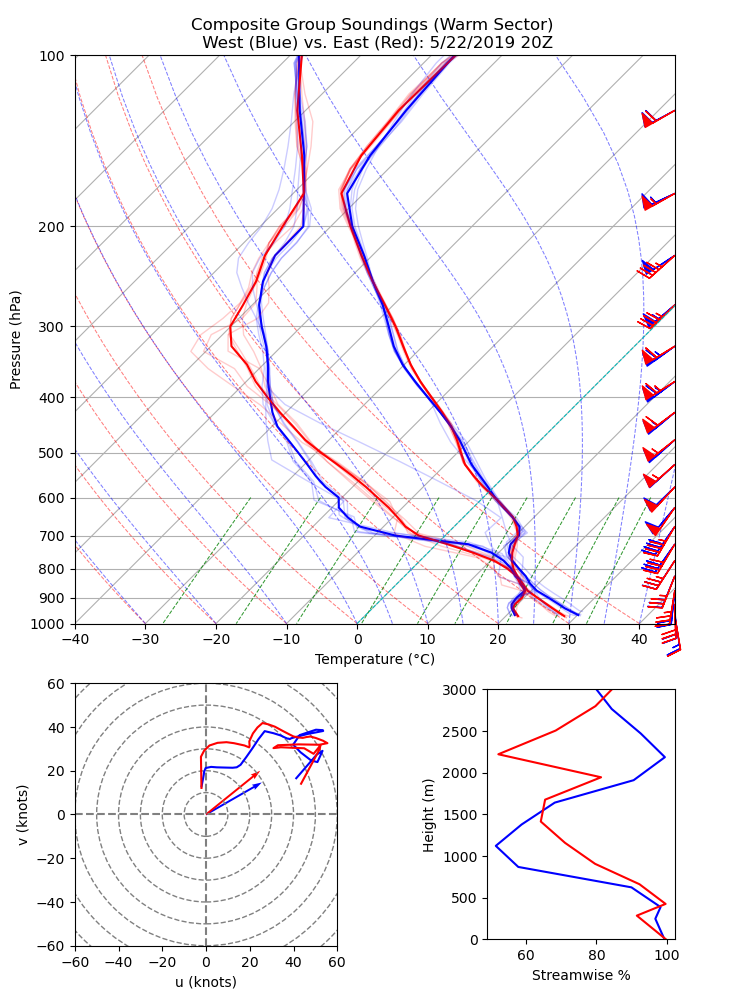

In [20]:
###########################################
#                                         #
#   MEDIAN EAST VS WEST WARM SECTOR   #
#                                         #
###########################################
#df = pd.read_excel("C:/Users/kyled/Desktop/HRRRouts/combined_EW.xlsx")
df = pd.read_csv('D:/THESIS/__UNL MS Thesis (MAIN)__/6 - SkewTs/5_22_VerticalProfs_QC_Grouped_BND.csv')

#D:\THESIS\__UNL MS Thesis (MAIN)__\6 - SkewTs

folder = r"D:\THESIS\__UNL MS Thesis (MAIN)__\6 - SkewTs\Soundings"
col_names = ['pressure', 'temperature', 'dewpoint', 'height', 'uwnd', 'vwnd']

time = 20
day = 22

combinedP_1 = []
combinedT_1 = []
combinedTd_1 = []
combinedH_1 = []
combinedU_1 = []
combinedV_1 = []

combinedP_W = []
combinedT_W = []
combinedTd_W = []
combinedH_W = []
combinedU_W = []
combinedV_W = []

combinedP_E = []
combinedT_E = []
combinedTd_E = []
combinedH_E = []
combinedU_E = []
combinedV_E = []

combinedP_2 = []
combinedT_2 = []
combinedTd_2 = []
combinedH_2 = []
combinedU_2 = []
combinedV_2 = []

interpP_W = []
interpT_W = []
interpTd_W = []
interpH_W = []
interpU_W = []
interpV_W = []

interpP_E = []
interpT_E = []
interpTd_E = []
interpH_E = []
interpU_E = []
interpV_E = []

sfcP_w = []
sfcT_w = []
sfcTd_w = []
sfcH_w = []
sfcU_w = []
sfcV_w = []

sfcP_e = []
sfcT_e = []
sfcTd_e = []
sfcH_e = []
sfcU_e = []
sfcV_e = []

###
combinedP_1sup = []
combinedT_1sup = []
combinedTd_1sup = []
combinedH_1sup = []
combinedU_1sup = []
combinedV_1sup = []

combinedP_Wsup = []
combinedT_Wsup = []
combinedTd_Wsup = []
combinedH_Wsup = []
combinedU_Wsup = []
combinedV_Wsup = []

combinedP_Esup = []
combinedT_Esup = []
combinedTd_Esup = []
combinedH_Esup = []
combinedU_Esup = []
combinedV_Esup = []

combinedP_2sup = []
combinedT_2sup = []
combinedTd_2sup = []
combinedH_2sup = []
combinedU_2sup = []
combinedV_2sup = []

interpP_Wsup = []
interpT_Wsup = []
interpTd_Wsup = []
interpH_Wsup = []
interpU_Wsup = []
interpV_Wsup = []

interpP_Esup = []
interpT_Esup = []
interpTd_Esup = []
interpH_Esup = []
interpU_Esup = []
interpV_Esup = []

sfcP_wsup = []
sfcT_wsup = []
sfcTd_wsup = []
sfcH_wsup = []
sfcU_wsup = []
sfcV_wsup = []

sfcP_esup = []
sfcT_esup = []
sfcTd_esup = []
sfcH_esup = []
sfcU_esup = []
sfcV_esup = []
###

interpP_W = [940.0, 925.0, 900.0, 875.0, 850.0, 825.0, 800.0, 775.0, 750.0, 725.0, 700.0, 675.0,
          650.0, 625.0, 600.0, 575.0, 550.0, 525.0, 500.0, 475.0, 450.0, 425.0, 400.0, 375.0,
          350.0, 325.0, 300.0, 275.0, 250.0, 225.0, 200.0, 175.0, 150.0, 125.0, 100.0]
interpP_E = [940.0, 925.0, 900.0, 875.0, 850.0, 825.0, 800.0, 775.0, 750.0, 725.0, 700.0, 675.0,
          650.0, 625.0, 600.0, 575.0, 550.0, 525.0, 500.0, 475.0, 450.0, 425.0, 400.0, 375.0,
          350.0, 325.0, 300.0, 275.0, 250.0, 225.0, 200.0, 175.0, 150.0, 125.0, 100.0]

interpP_Wsup = [940.0, 925.0, 900.0, 875.0, 850.0, 825.0, 800.0, 775.0, 750.0, 725.0, 700.0, 675.0,
          650.0, 625.0, 600.0, 575.0, 550.0, 525.0, 500.0, 475.0, 450.0, 425.0, 400.0, 375.0,
          350.0, 325.0, 300.0, 275.0, 250.0, 225.0, 200.0, 175.0, 150.0, 125.0, 100.0]
interpP_Esup = [940.0, 925.0, 900.0, 875.0, 850.0, 825.0, 800.0, 775.0, 750.0, 725.0, 700.0, 675.0,
          650.0, 625.0, 600.0, 575.0, 550.0, 525.0, 500.0, 475.0, 450.0, 425.0, 400.0, 375.0,
          350.0, 325.0, 300.0, 275.0, 250.0, 225.0, 200.0, 175.0, 150.0, 125.0, 100.0]

#for i in df[df.Grouping==1][df.Time==20]['Profile_Number']:
for i in df[df.EWB=='OPW'][df.Time==time]['StormID']:
#for i in df[df.EW=='W'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        profW = profile.create_profile(profile='default', pres=sounding_df['pressure'], hght=sounding_df['height'],
                                       tmpc=sounding_df['temperature'], dwpc=sounding_df['dewpoint'],
                                       u=sounding_df['uwnd'], v=sounding_df['vwnd'], missing=-9999)
       
        sfcP_W = sharppy.sharptab.interp.pres(profW, 0)
        sfcT_W = sharppy.sharptab.interp.temp(profW, sfcP_W)
        sfcTd_W = sharppy.sharptab.interp.dwpt(profW, sfcP_W)
        sfcWind_W = sharppy.sharptab.interp.components(profW, sfcP_W)
        sfcU_W = sfcWind_W[0]
        sfcV_W = sfcWind_W[1]
        
        sfcP_w.append(sfcP_W)
        sfcT_w.append(sfcT_W)
        sfcTd_w.append(sfcTd_W)
        sfcU_w.append(sfcU_W)
        sfcV_w.append(sfcV_W)

        interpT_W = []
        interpTd_W = []
        interpH_W = []
        interpU_W = []
        interpV_W = []                
        
        for k in interpP_W:
            H_west = sharppy.sharptab.interp.hght(profW, k)
            T_west = sharppy.sharptab.interp.temp(profW, k)
            Td_west = sharppy.sharptab.interp.dwpt(profW, k)
            Wind_west = sharppy.sharptab.interp.components(profW, k)
            U_west = Wind_west[0]
            V_west = Wind_west[1]
            
            interpT_W.append(T_west)
            interpTd_W.append(Td_west)
            interpH_W.append(H_west)
            interpU_W.append(U_west)
            interpV_W.append(V_west)
        
        combinedP_W.append(np.asarray(interpP_W))
        combinedT_W.append(np.asarray(interpT_W))
        combinedTd_W.append(np.asarray(interpTd_W))
        combinedH_W.append(np.asarray(interpH_W))
        combinedU_W.append(np.asarray(interpU_W))
        combinedV_W.append(np.asarray(interpV_W))

#for i in df[df.Grouping==1][df.Time==20]['Profile_Number']:
for i in df[df.EWB=='OPW'][df.Time==time][df.Supercell=="Y"]['StormID']:
#for i in df[df.EW=='W'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        profWsup = profile.create_profile(profile='default', pres=sounding_df['pressure'], hght=sounding_df['height'],
                                       tmpc=sounding_df['temperature'], dwpc=sounding_df['dewpoint'],
                                       u=sounding_df['uwnd'], v=sounding_df['vwnd'], missing=-9999)
       
        sfcP_Wsup = sharppy.sharptab.interp.pres(profWsup, 0)
        sfcT_Wsup = sharppy.sharptab.interp.temp(profWsup, sfcP_Wsup)
        sfcTd_Wsup = sharppy.sharptab.interp.dwpt(profWsup, sfcP_Wsup)
        sfcWind_Wsup = sharppy.sharptab.interp.components(profWsup, sfcP_Wsup)
        sfcU_Wsup = sfcWind_Wsup[0]
        sfcV_Wsup = sfcWind_Wsup[1]
        
        sfcP_wsup.append(sfcP_Wsup)
        sfcT_wsup.append(sfcT_Wsup)
        sfcTd_wsup.append(sfcTd_Wsup)
        sfcU_wsup.append(sfcU_Wsup)
        sfcV_wsup.append(sfcV_Wsup)

        interpT_Wsup = []
        interpTd_Wsup = []
        interpH_Wsup = []
        interpU_Wsup = []
        interpV_Wsup = []                
        
        for k in interpP_Wsup:
            H_westsup = sharppy.sharptab.interp.hght(profWsup, k)
            T_westsup = sharppy.sharptab.interp.temp(profWsup, k)
            Td_westsup = sharppy.sharptab.interp.dwpt(profWsup, k)
            Wind_westsup = sharppy.sharptab.interp.components(profWsup, k)
            U_westsup = Wind_westsup[0]
            V_westsup = Wind_westsup[1]
            
            interpT_Wsup.append(T_westsup)
            interpTd_Wsup.append(Td_westsup)
            interpH_Wsup.append(H_westsup)
            interpU_Wsup.append(U_westsup)
            interpV_Wsup.append(V_westsup)
        
        combinedP_Wsup.append(np.asarray(interpP_Wsup))
        combinedT_Wsup.append(np.asarray(interpT_Wsup))
        combinedTd_Wsup.append(np.asarray(interpTd_Wsup))
        combinedH_Wsup.append(np.asarray(interpH_Wsup))
        combinedU_Wsup.append(np.asarray(interpU_Wsup))
        combinedV_Wsup.append(np.asarray(interpV_Wsup))
        
for i in df[df.EWB=='OPE'][df.Time==time]['StormID']:
#for i in df[df.EW=='E'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        profE = profile.create_profile(profile='default', pres=sounding_df['pressure'], hght=sounding_df['height'],
                                       tmpc=sounding_df['temperature'], dwpc=sounding_df['dewpoint'],
                                       u=sounding_df['uwnd'], v=sounding_df['vwnd'], missing=-9999)
       
        sfcP_E = sharppy.sharptab.interp.pres(profE, 0)
        sfcT_E = sharppy.sharptab.interp.temp(profE, sfcP_E)
        sfcTd_E = sharppy.sharptab.interp.dwpt(profE, sfcP_E)
        sfcWind_E = sharppy.sharptab.interp.components(profE, sfcP_E)
        sfcU_E = sfcWind_E[0]
        sfcV_E = sfcWind_E[1]
        
        sfcP_e.append(sfcP_E)
        sfcT_e.append(sfcT_E)
        sfcTd_e.append(sfcTd_E)
        sfcU_e.append(sfcU_E)
        sfcV_e.append(sfcV_E)

        interpT_E = []
        interpTd_E = []
        interpH_E = []
        interpU_E = []
        interpV_E = []                
        
        for k in interpP_E:
            H_east = sharppy.sharptab.interp.hght(profE, k)
            T_east = sharppy.sharptab.interp.temp(profE, k)
            Td_east = sharppy.sharptab.interp.dwpt(profE, k)
            Wind_east = sharppy.sharptab.interp.components(profE, k)
            U_east = Wind_east[0]
            V_east = Wind_east[1]
            
            interpT_E.append(T_east)
            interpTd_E.append(Td_east)
            interpH_E.append(H_east)
            interpU_E.append(U_east)
            interpV_E.append(V_east)
                    
        combinedP_E.append(np.asarray(interpP_E))
        combinedT_E.append(np.asarray(interpT_E))
        combinedTd_E.append(np.asarray(interpTd_E))
        combinedH_E.append(np.asarray(interpH_E))
        combinedU_E.append(np.asarray(interpU_E))
        combinedV_E.append(np.asarray(interpV_E))

#for i in df[df.Grouping==1][df.Time==20]['Profile_Number']:
for i in df[df.EWB=='OPE'][df.Time==time][df.Supercell=="Y"]['StormID']:
#for i in df[df.EW=='W'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        profEsup = profile.create_profile(profile='default', pres=sounding_df['pressure'], hght=sounding_df['height'],
                                       tmpc=sounding_df['temperature'], dwpc=sounding_df['dewpoint'],
                                       u=sounding_df['uwnd'], v=sounding_df['vwnd'], missing=-9999)
       
        sfcP_Esup = sharppy.sharptab.interp.pres(profEsup, 0)
        sfcT_Esup = sharppy.sharptab.interp.temp(profEsup, sfcP_Esup)
        sfcTd_Esup = sharppy.sharptab.interp.dwpt(profEsup, sfcP_Esup)
        sfcWind_Esup = sharppy.sharptab.interp.components(profEsup, sfcP_Esup)
        sfcU_Esup = sfcWind_Esup[0]
        sfcV_Esup = sfcWind_Esup[1]
        
        sfcP_esup.append(sfcP_Esup)
        sfcT_esup.append(sfcT_Esup)
        sfcTd_esup.append(sfcTd_Esup)
        sfcU_esup.append(sfcU_Esup)
        sfcV_esup.append(sfcV_Esup)

        interpT_Esup = []
        interpTd_Esup = []
        interpH_Esup = []
        interpU_Esup = []
        interpV_Esup = []                
        
        for k in interpP_Esup:
            H_eastsup = sharppy.sharptab.interp.hght(profEsup, k)
            T_eastsup = sharppy.sharptab.interp.temp(profEsup, k)
            Td_eastsup = sharppy.sharptab.interp.dwpt(profEsup, k)
            Wind_eastsup = sharppy.sharptab.interp.components(profEsup, k)
            U_eastsup = Wind_eastsup[0]
            V_eastsup = Wind_eastsup[1]
            
            interpT_Esup.append(T_eastsup)
            interpTd_Esup.append(Td_eastsup)
            interpH_Esup.append(H_eastsup)
            interpU_Esup.append(U_eastsup)
            interpV_Esup.append(V_eastsup)
        
        combinedP_Esup.append(np.asarray(interpP_Esup))
        combinedT_Esup.append(np.asarray(interpT_Esup))
        combinedTd_Esup.append(np.asarray(interpTd_Esup))
        combinedH_Esup.append(np.asarray(interpH_Esup))
        combinedU_Esup.append(np.asarray(interpU_Esup))
        combinedV_Esup.append(np.asarray(interpV_Esup))
        
combinedP_W=np.asarray(combinedP_W)
combinedT_W=np.asarray(combinedT_W)
combinedTd_W=np.asarray(combinedTd_W)
combinedH_W=np.asarray(combinedH_W)
combinedU_W=np.asarray(combinedU_W)
combinedV_W=np.asarray(combinedV_W)

combinedP_E=np.asarray(combinedP_E)
combinedT_E=np.asarray(combinedT_E)
combinedTd_E=np.asarray(combinedTd_E)
combinedH_E=np.asarray(combinedH_E)
combinedU_E=np.asarray(combinedU_E)
combinedV_E=np.asarray(combinedV_E)

combinedP_Wsup=np.asarray(combinedP_Wsup)
combinedT_Wsup=np.asarray(combinedT_Wsup)
combinedTd_Wsup=np.asarray(combinedTd_Wsup)
combinedH_Wsup=np.asarray(combinedH_Wsup)
combinedU_Wsup=np.asarray(combinedU_Wsup)
combinedV_Wsup=np.asarray(combinedV_Wsup)

combinedP_Esup=np.asarray(combinedP_Esup)
combinedT_Esup=np.asarray(combinedT_Esup)
combinedTd_Esup=np.asarray(combinedTd_Esup)
combinedH_Esup=np.asarray(combinedH_Esup)
combinedU_Esup=np.asarray(combinedU_Esup)
combinedV_Esup=np.asarray(combinedV_Esup)
   
sfcP_w=np.asarray(sfcP_w)
sfcT_w=np.asarray(sfcT_w)
sfcTd_w=np.asarray(sfcTd_w)
sfcU_w=np.asarray(sfcU_w)
sfcV_w=np.asarray(sfcV_w)

sfcP_e=np.asarray(sfcP_e)
sfcT_e=np.asarray(sfcT_e)
sfcTd_e=np.asarray(sfcTd_e)
sfcU_e=np.asarray(sfcU_e)
sfcV_e=np.asarray(sfcV_e)

sfcP_wsup=np.asarray(sfcP_wsup)
sfcT_wsup=np.asarray(sfcT_wsup)
sfcTd_wsup=np.asarray(sfcTd_wsup)
sfcU_wsup=np.asarray(sfcU_wsup)
sfcV_wsup=np.asarray(sfcV_wsup)

sfcP_esup=np.asarray(sfcP_esup)
sfcT_esup=np.asarray(sfcT_esup)
sfcTd_esup=np.asarray(sfcTd_esup)
sfcU_esup=np.asarray(sfcU_esup)
sfcV_esup=np.asarray(sfcV_esup)

PRES_W=[]
TEMP_W=[]
DEWP_W=[]
HGHT_W=[]
UWND_W=[]
VWND_W=[]

PRES_E=[]
TEMP_E=[]
DEWP_E=[]
HGHT_E=[]
UWND_E=[]
VWND_E=[]

PRES_Wsup=[]
TEMP_Wsup=[]
DEWP_Wsup=[]
HGHT_Wsup=[]
UWND_Wsup=[]
VWND_Wsup=[]

PRES_Esup=[]
TEMP_Esup=[]
DEWP_Esup=[]
HGHT_Esup=[]
UWND_Esup=[]
VWND_Esup=[]

for l in range(0,len(sfcP_w)):
    PRES_W.append(np.insert(combinedP_W[l],0,sfcP_w[l]))
    TEMP_W.append(np.insert(combinedT_W[l],0,sfcT_w[l]))
    DEWP_W.append(np.insert(combinedTd_W[l],0,sfcTd_w[l]))
    HGHT_W.append(np.insert(combinedH_W[l],0,0))
    UWND_W.append(np.insert(combinedU_W[l],0,sfcU_w[l]))
    VWND_W.append(np.insert(combinedV_W[l],0,sfcV_w[l]))

for l in range(0,len(sfcP_e)):
    PRES_E.append(np.insert(combinedP_E[l],0,sfcP_e[l]))
    TEMP_E.append(np.insert(combinedT_E[l],0,sfcT_e[l]))
    DEWP_E.append(np.insert(combinedTd_E[l],0,sfcTd_e[l]))
    HGHT_E.append(np.insert(combinedH_E[l],0,0))
    UWND_E.append(np.insert(combinedU_E[l],0,sfcU_e[l]))
    VWND_E.append(np.insert(combinedV_E[l],0,sfcV_e[l]))

for l in range(0,len(sfcP_wsup)):
    PRES_Wsup.append(np.insert(combinedP_Wsup[l],0,sfcP_wsup[l]))
    TEMP_Wsup.append(np.insert(combinedT_Wsup[l],0,sfcT_wsup[l]))
    DEWP_Wsup.append(np.insert(combinedTd_Wsup[l],0,sfcTd_wsup[l]))
    HGHT_Wsup.append(np.insert(combinedH_Wsup[l],0,0))
    UWND_Wsup.append(np.insert(combinedU_Wsup[l],0,sfcU_wsup[l]))
    VWND_Wsup.append(np.insert(combinedV_Wsup[l],0,sfcV_wsup[l]))

for l in range(0,len(sfcP_esup)):
    PRES_Esup.append(np.insert(combinedP_Esup[l],0,sfcP_esup[l]))
    TEMP_Esup.append(np.insert(combinedT_Esup[l],0,sfcT_esup[l]))
    DEWP_Esup.append(np.insert(combinedTd_Esup[l],0,sfcTd_esup[l]))
    HGHT_Esup.append(np.insert(combinedH_Esup[l],0,0))
    UWND_Esup.append(np.insert(combinedU_Esup[l],0,sfcU_esup[l]))
    VWND_Esup.append(np.insert(combinedV_Esup[l],0,sfcV_esup[l]))
    
#PRES_W=np.asarray(PRES_W)        
combinedP_1=pd.DataFrame(PRES_W).T
combinedT_1=pd.DataFrame(TEMP_W).T
combinedTd_1=pd.DataFrame(DEWP_W).T
combinedH_1=pd.DataFrame(HGHT_W).T
combinedU_1=pd.DataFrame(UWND_W).T
combinedV_1=pd.DataFrame(VWND_W).T        

combinedP_2=pd.DataFrame(PRES_E).T
combinedT_2=pd.DataFrame(TEMP_E).T
combinedTd_2=pd.DataFrame(DEWP_E).T
combinedH_2=pd.DataFrame(HGHT_E).T
combinedU_2=pd.DataFrame(UWND_E).T
combinedV_2=pd.DataFrame(VWND_E).T        

combinedP_1sup=pd.DataFrame(PRES_Wsup).T
combinedT_1sup=pd.DataFrame(TEMP_Wsup).T
combinedTd_1sup=pd.DataFrame(DEWP_Wsup).T
combinedH_1sup=pd.DataFrame(HGHT_Wsup).T
combinedU_1sup=pd.DataFrame(UWND_Wsup).T
combinedV_1sup=pd.DataFrame(VWND_Wsup).T        

combinedP_2sup=pd.DataFrame(PRES_Esup).T
combinedT_2sup=pd.DataFrame(TEMP_Esup).T
combinedTd_2sup=pd.DataFrame(DEWP_Esup).T
combinedH_2sup=pd.DataFrame(HGHT_Esup).T
combinedU_2sup=pd.DataFrame(UWND_Esup).T
combinedV_2sup=pd.DataFrame(VWND_Esup).T   

combinedP_1['meanP'] = combinedP_1.median(axis=1)
combinedT_1['meanT'] = combinedT_1.median(axis=1)
combinedTd_1['meanTd'] = combinedTd_1.median(axis=1)
combinedH_1['meanH'] = combinedH_1.median(axis=1)
combinedU_1['meanU'] = combinedU_1.median(axis=1)
combinedV_1['meanV'] = combinedV_1.median(axis=1)
        
combinedP_2['meanP'] = combinedP_2.median(axis=1)
combinedT_2['meanT'] = combinedT_2.median(axis=1)
combinedTd_2['meanTd'] = combinedTd_2.median(axis=1)
combinedH_2['meanH'] = combinedH_2.median(axis=1)
combinedU_2['meanU'] = combinedU_2.median(axis=1)
combinedV_2['meanV'] = combinedV_2.median(axis=1)

combinedP_1sup['meanP'] = combinedP_1sup.median(axis=1)
combinedT_1sup['meanT'] = combinedT_1sup.median(axis=1)
combinedTd_1sup['meanTd'] = combinedTd_1sup.median(axis=1)
combinedH_1sup['meanH'] = combinedH_1sup.median(axis=1)
combinedU_1sup['meanU'] = combinedU_1sup.median(axis=1)
combinedV_1sup['meanV'] = combinedV_1sup.median(axis=1)
        
combinedP_2sup['meanP'] = combinedP_2sup.median(axis=1)
combinedT_2sup['meanT'] = combinedT_2sup.median(axis=1)
combinedTd_2sup['meanTd'] = combinedTd_2sup.median(axis=1)
combinedH_2sup['meanH'] = combinedH_2sup.median(axis=1)
combinedU_2sup['meanU'] = combinedU_2sup.median(axis=1)
combinedV_2sup['meanV'] = combinedV_2sup.median(axis=1)

#######################################################
#Shear Calculations
u_1 = np.asarray(combinedU_1['meanU'])/1.944
v_1 = np.asarray(combinedV_1['meanV'])/1.944
z_1 = np.asarray(combinedH_1['meanH'])

u_2 = np.asarray(combinedU_2['meanU'])/1.944
v_2 = np.asarray(combinedV_2['meanV'])/1.944
z_2 = np.asarray(combinedH_2['meanH'])

profMS_W = profile.create_profile(profile='default', pres=np.asarray(combinedP_1['meanP']), hght=z_1,
                               tmpc=np.asarray(combinedT_1['meanT']), dwpc=np.asarray(combinedTd_1['meanTd']),
                               u=u_1, v=v_1, missing=-9999)
profMS_E = profile.create_profile(profile='default', pres=np.asarray(combinedP_2['meanP']), hght=z_2,
                               tmpc=np.asarray(combinedT_2['meanT']), dwpc=np.asarray(combinedTd_2['meanTd']),
                               u=u_2, v=v_2, missing=-9999)

srwindW = params.bunkers_storm_motion(profMS_W)
srwindE = params.bunkers_storm_motion(profMS_E)

uSR_W = u_1-srwindW[0]
uSR_E = u_2-srwindE[0]

vSR_W = v_1-srwindW[1]
vSR_E = v_2-srwindE[1]

dudz_W=(np.array(u_1[2::])-np.array(u_1[0:-2]))/(np.array(z_1[2::])-np.array(z_1[0:-2]))
dvdz_W=(np.array(v_1[2::])-np.array(v_1[0:-2]))/(np.array(z_1[2::])-np.array(z_1[0:-2]))
dudz_W=np.insert(dudz_W,0,dudz_W[0])
dudz_W=np.insert(dudz_W,-1,dudz_W[-1])
dvdz_W=np.insert(dvdz_W,0,dvdz_W[0])
dvdz_W=np.insert(dvdz_W,-1,dvdz_W[-1])

dudz_E=(np.array(u_2[2::])-np.array(u_2[0:-2]))/(np.array(z_2[2::])-np.array(z_2[0:-2]))
dvdz_E=(np.array(v_2[2::])-np.array(v_2[0:-2]))/(np.array(z_2[2::])-np.array(z_2[0:-2]))
dudz_E=np.insert(dudz_E,0,dudz_E[0])
dudz_E=np.insert(dudz_E,-1,dudz_E[-1])
dvdz_E=np.insert(dvdz_E,0,dvdz_E[0])
dvdz_E=np.insert(dvdz_E,-1,dvdz_E[-1])

shear_W=np.sqrt(dudz_W**2+dvdz_W**2)+0.0000001
# Vorticity components
uvort_W=-dvdz_W
vvort_W=dudz_W
# Streamwise vorticity
strmw_W=abs((uSR_W*uvort_W+vSR_W*vvort_W)/(np.sqrt(uSR_W**2+vSR_W**2)))
# Streamwise fraction
strmwperc_W=strmw_W/shear_W

shear_E=np.sqrt(dudz_E**2+dvdz_E**2)+0.0000001
# Vorticity components
uvort_E=-dvdz_E
vvort_E=dudz_E
# Streamwise vorticity
strmw_E=abs((uSR_E*uvort_E+vSR_E*vvort_E)/(np.sqrt(uSR_E**2+vSR_E**2)))
# Streamwise fraction
strmwperc_E=strmw_E/shear_E

#################################################
#Shear Calculations
if len(df[df.EWB=='OPW'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    u_1sup = np.asarray(combinedU_1sup['meanU'])/1.944
    v_1sup = np.asarray(combinedV_1sup['meanV'])/1.944
    z_1sup = np.asarray(combinedH_1sup['meanH'])

    profMS_Wsup = profile.create_profile(profile='default', pres=np.asarray(combinedP_1sup['meanP']), hght=z_1sup,
                               tmpc=np.asarray(combinedT_1sup['meanT']), dwpc=np.asarray(combinedTd_1sup['meanTd']),
                               u=u_1sup, v=v_1sup, missing=-9999)
    
    srwindWsup = params.bunkers_storm_motion(profMS_Wsup)
    uSR_Wsup = u_1sup-srwindWsup[0]
    vSR_Wsup = v_1sup-srwindWsup[1]
    
    dudz_Wsup=(np.array(u_1sup[2::])-np.array(u_1sup[0:-2]))/(np.array(z_1sup[2::])-np.array(z_1sup[0:-2]))
    dvdz_Wsup=(np.array(v_1sup[2::])-np.array(v_1sup[0:-2]))/(np.array(z_1sup[2::])-np.array(z_1sup[0:-2]))
    dudz_Wsup=np.insert(dudz_Wsup,0,dudz_Wsup[0])
    dudz_Wsup=np.insert(dudz_Wsup,-1,dudz_Wsup[-1])
    dvdz_Wsup=np.insert(dvdz_Wsup,0,dvdz_Wsup[0])
    dvdz_Wsup=np.insert(dvdz_Wsup,-1,dvdz_Wsup[-1])
    
    shear_Wsup=np.sqrt(dudz_Wsup**2+dvdz_Wsup**2)+0.0000001
    # Vorticity components
    uvort_Wsup=-dvdz_Wsup
    vvort_Wsup=dudz_Wsup
    # Streamwise vorticity
    strmw_Wsup=abs((uSR_Wsup*uvort_Wsup+vSR_Wsup*vvort_Wsup)/(np.sqrt(uSR_Wsup**2+vSR_Wsup**2)))
    # Streamwise fraction
    strmwperc_Wsup=strmw_Wsup/shear_Wsup
    
if len(df[df.EWB=='OPE'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    u_2sup = np.asarray(combinedU_2sup['meanU'])/1.944
    v_2sup = np.asarray(combinedV_2sup['meanV'])/1.944
    z_2sup = np.asarray(combinedH_2sup['meanH'])


    profMS_Esup = profile.create_profile(profile='default', pres=np.asarray(combinedP_2sup['meanP']), hght=z_2sup,
                                   tmpc=np.asarray(combinedT_2sup['meanT']), dwpc=np.asarray(combinedTd_2sup['meanTd']),
                                   u=u_2sup, v=v_2sup, missing=-9999)
    
    srwindEsup = params.bunkers_storm_motion(profMS_Esup)
    uSR_Esup = u_2sup-srwindEsup[0]
    vSR_Esup = v_2sup-srwindEsup[1]

    dudz_Esup=(np.array(u_2sup[2::])-np.array(u_2sup[0:-2]))/(np.array(z_2sup[2::])-np.array(z_2sup[0:-2]))
    dvdz_Esup=(np.array(v_2sup[2::])-np.array(v_2sup[0:-2]))/(np.array(z_2sup[2::])-np.array(z_2sup[0:-2]))
    dudz_Esup=np.insert(dudz_Esup,0,dudz_Esup[0])
    dudz_Esup=np.insert(dudz_Esup,-1,dudz_Esup[-1])
    dvdz_Esup=np.insert(dvdz_Esup,0,dvdz_Esup[0])
    dvdz_Esup=np.insert(dvdz_Esup,-1,dvdz_Esup[-1])

    shear_Esup=np.sqrt(dudz_Esup**2+dvdz_Esup**2)+0.0000001
    # Vorticity components
    uvort_Esup=-dvdz_Esup
    vvort_Esup=dudz_Esup
    # Streamwise vorticity
    strmw_Esup=abs((uSR_Esup*uvort_Esup+vSR_Esup*vvort_Esup)/(np.sqrt(uSR_Esup**2+vSR_Esup**2)))
    # Streamwise fraction
    strmwperc_Esup=strmw_Esup/shear_Esup

#######################################################
fig = plt.figure(figsize=(7.5, 10))
#gs=gridspec.GridSpec(nrows=6, ncols=4, figure=fig)

#ax0 = plt.subplot(gs.new_subplotspec((0,0), rowspan=4, colspan=4))

skew = SkewT(fig, rotation=45, rect=(0, 0.25, 0.8, 0.8)) # left, bottom, width, height (range 0 to 1)
#skew = SkewT(ax0, rotation=45)
#skew = SkewT(fig, rotation=45, subplot=gs[0:3, 0:3])

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot.

hpa100 = np.where(combinedP_1['meanP'] >=100)

skew.plot(combinedP_1['meanP'], combinedT_1['meanT'], 'b', linestyle='-', linewidth=1.5)
skew.plot(combinedP_1['meanP'], combinedTd_1['meanTd'], 'b', linestyle='-', linewidth=1.5)
skew.plot_barbs(combinedP_1['meanP'][hpa100[0]][::2], combinedU_1['meanU'][hpa100[0]][::2], combinedV_1['meanV'][hpa100[0]][::2], color='blue')
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 45)
skew.ax.set_ylabel('Pressure (hPa)')
skew.ax.set_xlabel('Temperature (°C)')

skew.plot(combinedP_2['meanP'], combinedT_2['meanT'], 'r', linestyle='-', linewidth=1.5)
skew.plot(combinedP_2['meanP'], combinedTd_2['meanTd'], 'r', linestyle='-', linewidth=1.5)
skew.plot_barbs(combinedP_2['meanP'][hpa100[0]][::2], combinedU_2['meanU'][hpa100[0]][::2], combinedV_2['meanV'][hpa100[0]][::2], color='red')

skew.plot(combinedP_1sup['meanP'], combinedT_1sup['meanT'], 'b', linestyle='--', linewidth=1.5)
skew.plot(combinedP_1sup['meanP'], combinedTd_1sup['meanTd'], 'b', linestyle='--', linewidth=1.5)
skew.plot(combinedP_2sup['meanP'], combinedT_2sup['meanT'], 'r', linestyle='--', linewidth=1.5)
skew.plot(combinedP_2sup['meanP'], combinedTd_2sup['meanTd'], 'r', linestyle='--', linewidth=1.5)

for i in df[df.EWB=='OPE'][df.Time==time]['StormID']:
#for i in df[df.EW=='E'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        skew.plot(np.asarray(sounding_df['pressure']), np.asarray(sounding_df['temperature']), 'r', linewidth=1.0, alpha=0.2)
        skew.plot(np.asarray(sounding_df['pressure']), np.asarray(sounding_df['dewpoint']), 'r', linewidth=1.0, alpha=0.2)

for i in df[df.EWB=='OPW'][df.Time==time]['StormID']:
#for i in df[df.EW=='E'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        skew.plot(np.asarray(sounding_df['pressure']), np.asarray(sounding_df['temperature']), 'b', linewidth=1.0, alpha=0.2)
        skew.plot(np.asarray(sounding_df['pressure']), np.asarray(sounding_df['dewpoint']), 'b', linewidth=1.0, alpha=0.2)

        
#skew.plot(p2, T2, 'b')
#skew.plot(p2, Td2, 'b')
#skew.plot_barbs(p2[::150], u2[::150], v2[::150], color='blue')

# Calculate LCL height and plot as black dot. Because `p`'s first value is
# ~1000 mb and its last value is ~250 mb, the `0` index is selected for
# `p`, `T`, and `Td` to lift the parcel from the surface. If `p` was inverted,
# i.e. start from low value, 250 mb, to a high value, 1000 mb, the `-1` index
# should be selected.

#lcl_pressure, lcl_temperature = lcl(p[0], T[0], Td[0])
#skew.plot(lcl_pressure, lcl_temperature, marker=11, markerfacecolor='black', markers)

# Calculate full parcel profile and add to plot as black line
#prof = parcel_profile(p, T[0], Td[0]).to('degC')

#prof1 = mixed_parcel(p, T, Td)
#prof = parcel_profile(p, prof1[1], prof1[2]).to('degC')
#prof = parcel_profile(p, mlpcl.tmpc*units.degree_Celsius, mlpcl.dwpc*units.degree_Celsius).to('degC')


#mlpcl.tmpc*units.degree_Celsius
#skew.plot(p, prof, 'k', linewidth=1.5, linestyle='--')

# Shade areas of CAPE and CIN
#skew.shade_cin(p, T, prof, Td)
#skew.shade_cape(p, T, prof)

# An example of a slanted line at constant T -- in this case the 0
# isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=0.75)
#skew.ax.axvline(-20, color='c', linestyle='--', linewidth=1)
#skew.ax.axvline(-30, color='c', linestyle='--', linewidth=1)

#hgt0c = (mupcl.hght0c*units.meter).to(units.feet)
#hgtm20c = (mupcl.hghtm20c*units.meter).to(units.feet)
#hgtm30c = (mupcl.hghtm30c*units.meter).to(units.feet)

# Add the relevant special lines
skew.plot_dry_adiabats(linewidth=0.75)
skew.plot_moist_adiabats(linewidth=0.75)
skew.plot_mixing_lines(linewidth=0.75)

#plt.title("Composite Group Soundings \n Boundary (Blue) vs. East Warm Sector (Red): 5/"+str(day)+"/2019 "+str(time)+"Z")

plt.title("Composite Group Soundings (Warm Sector) \n West (Blue) vs. East (Red): 5/"+str(day)+"/2019 "+str(time)+"Z")
#plt.title("Composite Group Soundings (Supercells) \n West (Blue) vs. East (Red): 5/"+str(day)+"/2019 "+str(time)+"Z")
#plt.title("Composite Group Soundings (Supercells) \n West (Blue) vs. East (Red): 5/"+str(day)+"/2019 "+str(time)+"Z")
#plt.title("Composite Group Soundings (Supercells) \n West (Blue) vs. East (Red): 5/23/2019 "+str(time)+"Z")

# Add a secondary axis that automatically converts between pressure and height
# assuming a standard atmosphere. The value of -0.12 puts the secondary axis
# 0.12 normalized (0 to 1) coordinates left of the original axis.
#secax = skew.ax.secondary_yaxis(-0.14,
#    functions=(lambda p: pressure_to_height_std(units.Quantity(p, 'mbar')).m_as('feet'),
#               lambda h: height_to_pressure_std(units.Quantity(h, 'feet')).m))

#fig = plt.figure(figsize=(12, 12))
#gs=gridspec.GridSpec(2,2)


#ax = fig.add_subplot(gs[4,0])
#ax = plt.subplot(gs.new_subplotspec((4,0), rowspan=2, colspan=2))
#ax = fig.add_subplot(gs[1:2,3:])

ax = plt.axes((0, 0, 0.35, 0.35))
h = Hodograph(ax, component_range=60.)
h.add_grid(increment=10)
h.ax.set_xlabel('u (knots)')
h.ax.set_ylabel('v (knots)')

height_scale = combinedH_1['meanH'][hpa100[0]].values
height = combinedH_1['meanH'][hpa100[0]].values * units.m

h.plot(combinedU_1['meanU'][hpa100[0]],combinedV_1['meanV'][hpa100[0]], alpha = 1.0,linewidth=1.5, color='blue')
h.plot(combinedU_2['meanU'][hpa100[0]],combinedV_2['meanV'][hpa100[0]], alpha = 1.0,linewidth=1.5, color='red')

if len(df[df.EWB=='OPW'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    h.plot(combinedU_1sup['meanU'][hpa100[0]],combinedV_1sup['meanV'][hpa100[0]], alpha = 1.0,linewidth=1.5, linestyle="--", color='blue')

if len(df[df.EWB=='OPE'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    h.plot(combinedU_2sup['meanU'][hpa100[0]],combinedV_2sup['meanV'][hpa100[0]], alpha = 1.0,linewidth=1.5, linestyle="--", color='red')

for i in df[df.EWB=='OPE'][df.Time==time]['StormID']:
#for i in df[df.EW=='E'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        #h.plot(np.asarray(sounding_df['uwnd'][hpa100[0]]), np.asarray(sounding_df['vwnd'][hpa100[0]]), linewidth=1.0, alpha=0.3, color='red')

for i in df[df.EWB=='OPW'][df.Time==time]['StormID']:
#for i in df[df.EW=='E'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        #h.plot(np.asarray(sounding_df['uwnd'][hpa100[0]]), np.asarray(sounding_df['vwnd'][hpa100[0]]), linewidth=1.0, alpha=0.3, color='blue')

#cmap_W = plt.cm.winter_r
#cmap_E = plt.cm.autumn_r
#cmap_W = truncate_colormap(cmap_W, 0.35, 0.85)
#cmap_E = truncate_colormap(cmap_E, 0.35, 0.85)

#for i in range(0, v3000E):
    #w_3km = h.plot(combinedU_1['meanU'][hpa100[0]][i:i+2],combinedV_1['meanV'][hpa100[0]][i:i+2], alpha = 0.6, linewidth=180*shear_W[i], color=cmap_W(int(strmwperc_W[i]*255)))
    #e_3km = h.plot(combinedU_2['meanU'][hpa100[0]][i:i+2],combinedV_2['meanV'][hpa100[0]][i:i+2], alpha = 0.6, linewidth=180*shear_E[i], color=cmap_E(int(strmwperc_E[i]*255)))
    #w_3km = h.plot(combinedU_1['meanU'][hpa100[0]][i:i+2],combinedV_1['meanV'][hpa100[0]][i:i+2], linewidth=2.0, color=cmap_W(int(strmwperc_W[i]*255)))
    #e_3km = h.plot(combinedU_2['meanU'][hpa100[0]][i:i+2],combinedV_2['meanV'][hpa100[0]][i:i+2], linewidth=2.0, color=cmap_E(int(strmwperc_E[i]*255)))
#h.plot_colormapped(combinedU_1['meanU'][hpa100[0]],combinedV_1['meanV'][hpa100[0]], height_scale, cmap=plt.cm.Blues,intervals=[10,15,25], linewidth=2)
#h.plot_colormapped(combinedU_2['meanU'][hpa100[0]],combinedV_2['meanV'][hpa100[0]], height_scale, cmap=plt.cm.Reds,intervals=[10,15,25], linewidth=2)

#h.plot(combinedU_1['meanU'][hpa100[0]][13],combinedV_1['meanV'][hpa100[0]][13], marker="s")
#h.ax.text(combinedU_1['meanU'][hpa100[0]][5],combinedV_1['meanV'][hpa100[0]][5],'1',fontsize=24,ha='left',fontweight='bold', color='black')
#h.ax.text(combinedU_2['meanU'][hpa100[0]][5],combinedV_2['meanV'][hpa100[0]][5],'1',fontsize=24,ha='left',fontweight='bold', color='black')

val500W = find_nearest(combinedH_1['meanH'][hpa100[0]], 500)
val500posW = np.where(combinedH_1['meanH'][hpa100[0]] == val500W)
v500W = val500posW[0][0]

val1000W = find_nearest(combinedH_1['meanH'][hpa100[0]], 1000)
val1000posW = np.where(combinedH_1['meanH'][hpa100[0]] == val1000W)
v1000W = val1000posW[0][0]

val3000W = find_nearest(combinedH_1['meanH'][hpa100[0]], 3000)
val3000posW = np.where(combinedH_1['meanH'][hpa100[0]] == val3000W)
v3000W = val3000posW[0][0]

val500E = find_nearest(combinedH_2['meanH'][hpa100[0]], 500)
val500posE = np.where(combinedH_2['meanH'][hpa100[0]] == val500E)
v500E = val500posE[0][0]

val1000E = find_nearest(combinedH_2['meanH'][hpa100[0]], 1000)
val1000posE = np.where(combinedH_2['meanH'][hpa100[0]] == val1000E)
v1000E = val1000posE[0][0]

val3000E = find_nearest(combinedH_2['meanH'][hpa100[0]], 3000)
val3000posE = np.where(combinedH_2['meanH'][hpa100[0]] == val3000E)
v3000E = val3000posE[0][0]

###########
if len(df[df.EWB=='OPW'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    val500Wsup = find_nearest(combinedH_1sup['meanH'][hpa100[0]], 500)
    val500posWsup = np.where(combinedH_1sup['meanH'][hpa100[0]] == val500Wsup)
    v500Wsup = val500posWsup[0][0]

    val1000Wsup = find_nearest(combinedH_1sup['meanH'][hpa100[0]], 1000)
    val1000posWsup = np.where(combinedH_1sup['meanH'][hpa100[0]] == val1000Wsup)
    v1000Wsup = val1000posWsup[0][0]

    val3000Wsup = find_nearest(combinedH_1sup['meanH'][hpa100[0]], 3000)
    val3000posWsup = np.where(combinedH_1sup['meanH'][hpa100[0]] == val3000Wsup)
    v3000Wsup = val3000posWsup[0][0]

if len(df[df.EWB=='OPE'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    val500Esup = find_nearest(combinedH_2sup['meanH'][hpa100[0]], 500)
    val500posEsup = np.where(combinedH_2sup['meanH'][hpa100[0]] == val500Esup)
    v500Esup = val500posEsup[0][0]

    val1000Esup = find_nearest(combinedH_2sup['meanH'][hpa100[0]], 1000)
    val1000posEsup = np.where(combinedH_2sup['meanH'][hpa100[0]] == val1000Esup)
    v1000Esup = val1000posEsup[0][0]

    val3000Esup = find_nearest(combinedH_2sup['meanH'][hpa100[0]], 3000)
    val3000posEsup = np.where(combinedH_2sup['meanH'][hpa100[0]] == val3000Esup)
    v3000Esup = val3000posEsup[0][0]

############
# h.plot(combinedU_1['meanU'][hpa100[0]][v500W],combinedV_1['meanV'][hpa100[0]][v500W], marker="o", color='black', markersize=6)
# h.plot(combinedU_1['meanU'][hpa100[0]][v1000W],combinedV_1['meanV'][hpa100[0]][v1000W], marker="o", color='black', markersize=6)
# h.plot(combinedU_1['meanU'][hpa100[0]][v3000W],combinedV_1['meanV'][hpa100[0]][v3000W], marker="o", color='black', markersize=6)

# h.plot(combinedU_2['meanU'][hpa100[0]][v500E],combinedV_2['meanV'][hpa100[0]][v500E], marker="o", color='black', markersize=6)
# h.plot(combinedU_2['meanU'][hpa100[0]][v1000E],combinedV_2['meanV'][hpa100[0]][v1000E], marker="o", color='black', markersize=6)
# h.plot(combinedU_2['meanU'][hpa100[0]][v3000E],combinedV_2['meanV'][hpa100[0]][v3000E], marker="o", color='black', markersize=6)

# h.plot(combinedU_1['meanU'][hpa100[0]][v500W],combinedV_1['meanV'][hpa100[0]][v500W], marker="o", color='snow', markersize=3)
# h.plot(combinedU_1['meanU'][hpa100[0]][v1000W],combinedV_1['meanV'][hpa100[0]][v1000W], marker="o", color='snow', markersize=3)
# h.plot(combinedU_1['meanU'][hpa100[0]][v3000W],combinedV_1['meanV'][hpa100[0]][v3000W], marker="o", color='snow', markersize=3)

# h.plot(combinedU_2['meanU'][hpa100[0]][v500E],combinedV_2['meanV'][hpa100[0]][v500E], marker="o", color='snow', markersize=3)
# h.plot(combinedU_2['meanU'][hpa100[0]][v1000E],combinedV_2['meanV'][hpa100[0]][v1000E], marker="o", color='snow', markersize=3)
# h.plot(combinedU_2['meanU'][hpa100[0]][v3000E],combinedV_2['meanV'][hpa100[0]][v3000E], marker="o", color='snow', markersize=3)

ax1 = plt.axes((0.55, 0.05, 0.25, 0.25))
ax1.plot(strmwperc_W[0:v3000W+2]*100, z_1[0:v3000W+2], color="blue")
ax1.plot(strmwperc_E[0:v3000E+2]*100, z_2[0:v3000E+2], color="red")

############
if len(df[df.EWB=='OPW'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    h.plot(combinedU_1sup['meanU'][hpa100[0]][v500Wsup],combinedV_1sup['meanV'][hpa100[0]][v500Wsup], marker="o", color='black', markersize=6)
    h.plot(combinedU_1sup['meanU'][hpa100[0]][v1000Wsup],combinedV_1sup['meanV'][hpa100[0]][v1000Wsup], marker="o", color='black', markersize=6)
    h.plot(combinedU_1sup['meanU'][hpa100[0]][v3000Wsup],combinedV_1sup['meanV'][hpa100[0]][v3000Wsup], marker="o", color='black', markersize=6)

    h.plot(combinedU_1sup['meanU'][hpa100[0]][v500Wsup],combinedV_1sup['meanV'][hpa100[0]][v500Wsup], marker="o", color='lime', markersize=3)
    h.plot(combinedU_1sup['meanU'][hpa100[0]][v1000Wsup],combinedV_1sup['meanV'][hpa100[0]][v1000Wsup], marker="o", color='lime', markersize=3)
    h.plot(combinedU_1sup['meanU'][hpa100[0]][v3000Wsup],combinedV_1sup['meanV'][hpa100[0]][v3000Wsup], marker="o", color='lime', markersize=3)

    right1, left1, mean1 = bunkers_storm_motion(np.asarray(combinedP_1sup['meanP'][hpa100[0]])* units.hPa, np.asarray(combinedU_1sup['meanU'][hpa100[0]])* units.knot,np.asarray(combinedV_1sup['meanV'][hpa100[0]])* units.knot, np.asarray(combinedH_1sup['meanH'][hpa100[0]])* units.meter)
    h.wind_vectors(right1[0], right1[1], color='lightblue', linestyle="--")
    #h.ax.text(right1[0], right1[1],'M',fontsize=36,fontweight='bold', color='blue')
    ax1.plot(strmwperc_Wsup[0:v3000Wsup+2]*100, z_1sup[0:v3000Wsup+2], color="blue", linestyle="--")
    
if len(df[df.EWB=='OPE'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    h.plot(combinedU_2sup['meanU'][hpa100[0]][v500Esup],combinedV_2sup['meanV'][hpa100[0]][v500Esup], marker="o", color='black', markersize=6)
    h.plot(combinedU_2sup['meanU'][hpa100[0]][v1000Esup],combinedV_2sup['meanV'][hpa100[0]][v1000Esup], marker="o", color='black', markersize=6)
    h.plot(combinedU_2sup['meanU'][hpa100[0]][v3000Esup],combinedV_2sup['meanV'][hpa100[0]][v3000Esup], marker="o", color='black', markersize=6)

    h.plot(combinedU_2sup['meanU'][hpa100[0]][v500Esup],combinedV_2sup['meanV'][hpa100[0]][v500Esup], marker="o", color='lime', markersize=3)
    h.plot(combinedU_2sup['meanU'][hpa100[0]][v1000Esup],combinedV_2sup['meanV'][hpa100[0]][v1000Esup], marker="o", color='lime', markersize=3)
    h.plot(combinedU_2sup['meanU'][hpa100[0]][v3000Esup],combinedV_2sup['meanV'][hpa100[0]][v3000Esup], marker="o", color='lime', markersize=3)
    
    right2, left2, mean2 = bunkers_storm_motion(np.asarray(combinedP_2sup['meanP'][hpa100[0]])* units.hPa, np.asarray(combinedU_2['meanU'][hpa100[0]])* units.knot,np.asarray(combinedV_2sup['meanV'][hpa100[0]])* units.knot, np.asarray(combinedH_2sup['meanH'][hpa100[0]])* units.meter)
    h.wind_vectors(right2[0], right2[1], color='lightcoral',linestyle="--")
       
    ax1.plot(strmwperc_Esup[0:v3000Esup+2]*100, z_2sup[0:v3000Esup+2], color="red", linestyle="--")
############
#for i in range(0,int(30)):
#    ax.plot(uSR[i:i+2]*1.944,vSR[i:i+2]*1.944,lw=180*shear[i],color=cmap(int(strmwperc[i]*255)))

#colors=['black','black','black','darkgray',[0.6,0.6,0.6]]

# Shear magnitude graphic
#for i in range(0,4):
#    ax.plot([-56+15*i,-48+15*i],[-45,-45],color=colors[2],lw=180*(0.01+0.01*i))

# Shear magnitude labels
#for i in range(0,4):
#    ax.text(-52+15*i,-48,str(0.01+0.01*i),fontsize=8,color=colors[1],ha='center',va='top')  

# Shear magnitude title
#ax.text(-30,-58,'Shear Magnitude (1/s)',fontsize=9,color=colors[1],ha='center')

right1, left1, mean1 = bunkers_storm_motion(np.asarray(combinedP_1['meanP'][hpa100[0]])* units.hPa, np.asarray(combinedU_1['meanU'][hpa100[0]])* units.knot,np.asarray(combinedV_1['meanV'][hpa100[0]])* units.knot, np.asarray(combinedH_1['meanH'][hpa100[0]])* units.meter)
h.wind_vectors(right1[0], right1[1], color='blue')
#h.ax.text(right1[0], right1[1],'M',fontsize=36,fontweight='bold', color='blue')

right2, left2, mean2 = bunkers_storm_motion(np.asarray(combinedP_2['meanP'][hpa100[0]])* units.hPa, np.asarray(combinedU_2['meanU'][hpa100[0]])* units.knot,np.asarray(combinedV_2['meanV'][hpa100[0]])* units.knot, np.asarray(combinedH_2['meanH'][hpa100[0]])* units.meter)
h.wind_vectors(right2[0], right2[1], color='red')
############################

#right_mover_direction = wind_direction(right1[0],right1[1])
#right_mover_speed = wind_speed(right1[0],right1[1])
#print(right_mover_speed, right_mover_direction)

#right_mover_direction = wind_direction(right2[0],right2[1])
#right_mover_speed = wind_speed(right2[0],right2[1])
#print(right_mover_speed, right_mover_direction)

#left_mover_direction = get_wind_dir(left[0],left[1])
#left_mover_speed = get_wind_speed(left[0],left[1])
#print(left_mover_speed, left_mover_direction)

#mean_direction = get_wind_dir(mean[0],mean[1])
#mean_speed = get_wind_speed(mean[0],mean[1])
#print(mean_speed, mean_direction)
#plt.figtext(0.15, 0.38, '0°C Height: '+str(int(hgt0c.magnitude))+' ft', fontsize = 12)

#sm = plt.cm.ScalarMappable(cmap=cmap_E,norm=plt.Normalize(vmin=0,vmax=1))
#cbar=plt.colorbar(sm,orientation='vertical',shrink=0.5,pad=0.03)
#cbar.ax.set_xticklabels(['0%','20%','40%','60%','80%','100%'],fontsize=6,color=colors[1])
#cbar.set_label('Streamwise Percentage', fontsize=7,color=colors[1])
#cbar.outline.set_color(colors[1])
#cbar.outline.set_visible(False)
#cbar.ax.tick_params(color=colors[1])

#sm = plt.cm.ScalarMappable(cmap=cmap_W,norm=plt.Normalize(vmin=0,vmax=1))
#cbar=plt.colorbar(sm,orientation='vertical',shrink=0.5,pad=0.03)
#cbar.ax.set_xticklabels(['0%','20%','40%','60%','80%','100%'],fontsize=6,color=colors[1])
#cbar.set_label('Streamwise Percentage', fontsize=7,color=colors[1])
#cbar.outline.set_color(colors[1])
#cbar.outline.set_visible(False)
#cbar.ax.tick_params(color=colors[1])

#ax1 = fig.add_subplot(gs[4,2])

ax1.set_ylim(bottom=0, top=3000)
ax1.set_xlabel('Streamwise %')
ax1.set_ylabel('Height (m)')

# Show the plot
plt.savefig(r"D:\THESIS\__UNL MS Thesis (MAIN)__\6 - SkewTs\OWS_"+str(time)+"z.png", bbox_inches='tight')
plt.show()

C:\Users\kyled\AppData\Local\Temp\ipykernel_39428\2501230820.py:208: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i in df[df.EWB=='OPW'][df.Time==time]['StormID']:
D:\Anaconda3\envs\THESIS\lib\site-packages\numpy\lib\function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)
D:\Anaconda3\envs\THESIS\lib\site-packages\numpy\lib\function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)
D:\Anaconda3\envs\THESIS\lib\site-packages\numpy\lib\function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)
D:\Anaconda3\envs\THESIS\lib\site-packages\numpy\lib\function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)
D:\Anaconda3\envs\THESIS\lib\site-packages\numpy\lib\function_base.py:1594: UserWar

C:\Users\kyled\AppData\Local\Temp\ipykernel_39428\2501230820.py:883: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if len(df[df.EWB=='OPW'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
C:\Users\kyled\AppData\Local\Temp\ipykernel_39428\2501230820.py:912: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if len(df[df.EWB=='OPE'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
C:\Users\kyled\AppData\Local\Temp\ipykernel_39428\2501230820.py:942: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if len(df[df.EWB=='BND'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
C:\Users\kyled\AppData\Local\Temp\ipykernel_39428\2501230820.py:1013: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i in df[df.EWB=='OPE'][df.Time==time]['StormID']:
C:\Users\kyled\AppData\Local\Temp\ipykernel_39428\2501230820.py:1027: UserWarning: Boolean Series key will be reindexed to mat

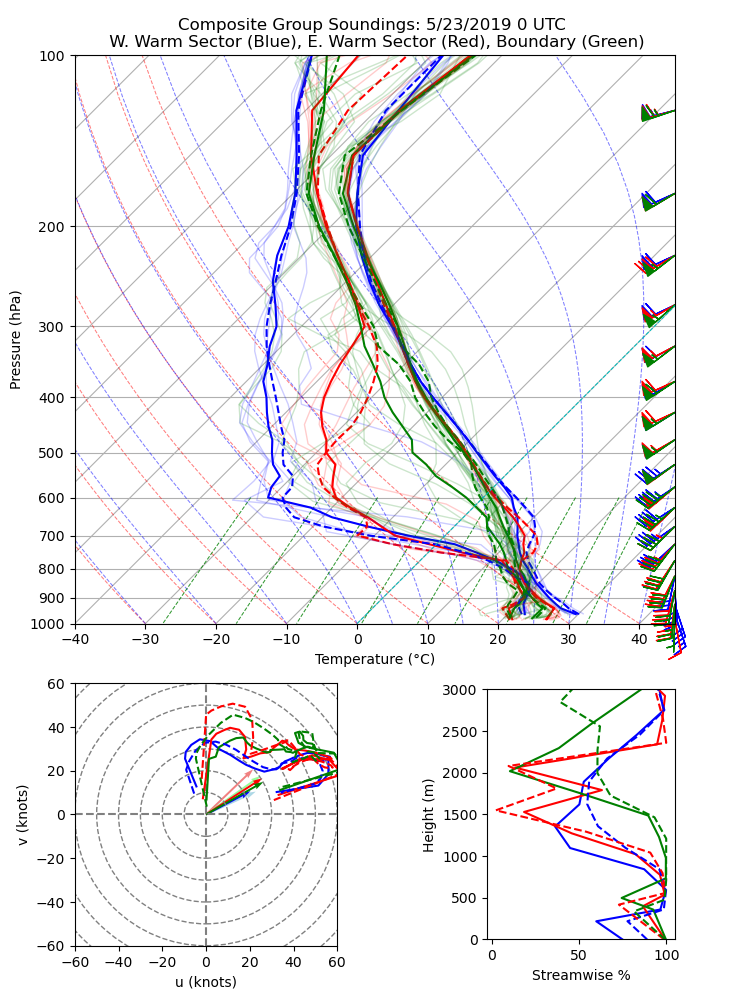

In [28]:
###########################################
#                                         #
#   MEDIAN ALL SECTORS                    #
#                                         #
###########################################
#df = pd.read_excel("C:/Users/kyled/Desktop/HRRRouts/combined_EW.xlsx")
df = pd.read_csv('D:/THESIS/__UNL MS Thesis (MAIN)__/6 - SkewTs/5_22_VerticalProfs_QC_Grouped_BND.csv')

#D:\THESIS\__UNL MS Thesis (MAIN)__\6 - SkewTs

folder = r"D:\THESIS\__UNL MS Thesis (MAIN)__\6 - SkewTs\Soundings"
col_names = ['pressure', 'temperature', 'dewpoint', 'height', 'uwnd', 'vwnd']

time = 0
day = 23

combinedP_1 = []
combinedT_1 = []
combinedTd_1 = []
combinedH_1 = []
combinedU_1 = []
combinedV_1 = []

combinedP_W = []
combinedT_W = []
combinedTd_W = []
combinedH_W = []
combinedU_W = []
combinedV_W = []

combinedP_E = []
combinedT_E = []
combinedTd_E = []
combinedH_E = []
combinedU_E = []
combinedV_E = []

combinedP_B = []
combinedT_B = []
combinedTd_B = []
combinedH_B = []
combinedU_B = []
combinedV_B = []

combinedP_2 = []
combinedT_2 = []
combinedTd_2 = []
combinedH_2 = []
combinedU_2 = []
combinedV_2 = []

combinedP_3 = []
combinedT_3 = []
combinedTd_3 = []
combinedH_3 = []
combinedU_3 = []
combinedV_3 = []

interpP_W = []
interpT_W = []
interpTd_W = []
interpH_W = []
interpU_W = []
interpV_W = []

interpP_E = []
interpT_E = []
interpTd_E = []
interpH_E = []
interpU_E = []
interpV_E = []

interpP_B = []
interpT_B = []
interpTd_B = []
interpH_B = []
interpU_B = []
interpV_B = []

sfcP_w = []
sfcT_w = []
sfcTd_w = []
sfcH_w = []
sfcU_w = []
sfcV_w = []

sfcP_e = []
sfcT_e = []
sfcTd_e = []
sfcH_e = []
sfcU_e = []
sfcV_e = []

sfcP_b = []
sfcT_b = []
sfcTd_b = []
sfcH_b = []
sfcU_b = []
sfcV_b = []

###
combinedP_1sup = []
combinedT_1sup = []
combinedTd_1sup = []
combinedH_1sup = []
combinedU_1sup = []
combinedV_1sup = []

combinedP_Wsup = []
combinedT_Wsup = []
combinedTd_Wsup = []
combinedH_Wsup = []
combinedU_Wsup = []
combinedV_Wsup = []

combinedP_Esup = []
combinedT_Esup = []
combinedTd_Esup = []
combinedH_Esup = []
combinedU_Esup = []
combinedV_Esup = []

combinedP_Bsup = []
combinedT_Bsup = []
combinedTd_Bsup = []
combinedH_Bsup = []
combinedU_Bsup = []
combinedV_Bsup = []

combinedP_2sup = []
combinedT_2sup = []
combinedTd_2sup = []
combinedH_2sup = []
combinedU_2sup = []
combinedV_2sup = []

combinedP_3sup = []
combinedT_3sup = []
combinedTd_3sup = []
combinedH_3sup = []
combinedU_3sup = []
combinedV_3sup = []

interpP_Wsup = []
interpT_Wsup = []
interpTd_Wsup = []
interpH_Wsup = []
interpU_Wsup = []
interpV_Wsup = []

interpP_Esup = []
interpT_Esup = []
interpTd_Esup = []
interpH_Esup = []
interpU_Esup = []
interpV_Esup = []

interpP_Bsup = []
interpT_Bsup = []
interpTd_Bsup = []
interpH_Bsup = []
interpU_Bsup = []
interpV_Bsup = []

sfcP_wsup = []
sfcT_wsup = []
sfcTd_wsup = []
sfcH_wsup = []
sfcU_wsup = []
sfcV_wsup = []

sfcP_esup = []
sfcT_esup = []
sfcTd_esup = []
sfcH_esup = []
sfcU_esup = []
sfcV_esup = []

sfcP_bsup = []
sfcT_bsup = []
sfcTd_bsup = []
sfcH_bsup = []
sfcU_bsup = []
sfcV_bsup = []
###

interpP_W = [940.0, 925.0, 900.0, 875.0, 850.0, 825.0, 800.0, 775.0, 750.0, 725.0, 700.0, 675.0,
          650.0, 625.0, 600.0, 575.0, 550.0, 525.0, 500.0, 475.0, 450.0, 425.0, 400.0, 375.0,
          350.0, 325.0, 300.0, 275.0, 250.0, 225.0, 200.0, 175.0, 150.0, 125.0, 100.0]
interpP_E = [940.0, 925.0, 900.0, 875.0, 850.0, 825.0, 800.0, 775.0, 750.0, 725.0, 700.0, 675.0,
          650.0, 625.0, 600.0, 575.0, 550.0, 525.0, 500.0, 475.0, 450.0, 425.0, 400.0, 375.0,
          350.0, 325.0, 300.0, 275.0, 250.0, 225.0, 200.0, 175.0, 150.0, 125.0, 100.0]
interpP_B = [940.0, 925.0, 900.0, 875.0, 850.0, 825.0, 800.0, 775.0, 750.0, 725.0, 700.0, 675.0,
          650.0, 625.0, 600.0, 575.0, 550.0, 525.0, 500.0, 475.0, 450.0, 425.0, 400.0, 375.0,
          350.0, 325.0, 300.0, 275.0, 250.0, 225.0, 200.0, 175.0, 150.0, 125.0, 100.0]

interpP_Wsup = [940.0, 925.0, 900.0, 875.0, 850.0, 825.0, 800.0, 775.0, 750.0, 725.0, 700.0, 675.0,
          650.0, 625.0, 600.0, 575.0, 550.0, 525.0, 500.0, 475.0, 450.0, 425.0, 400.0, 375.0,
          350.0, 325.0, 300.0, 275.0, 250.0, 225.0, 200.0, 175.0, 150.0, 125.0, 100.0]
interpP_Esup = [940.0, 925.0, 900.0, 875.0, 850.0, 825.0, 800.0, 775.0, 750.0, 725.0, 700.0, 675.0,
          650.0, 625.0, 600.0, 575.0, 550.0, 525.0, 500.0, 475.0, 450.0, 425.0, 400.0, 375.0,
          350.0, 325.0, 300.0, 275.0, 250.0, 225.0, 200.0, 175.0, 150.0, 125.0, 100.0]
interpP_Bsup = [940.0, 925.0, 900.0, 875.0, 850.0, 825.0, 800.0, 775.0, 750.0, 725.0, 700.0, 675.0,
          650.0, 625.0, 600.0, 575.0, 550.0, 525.0, 500.0, 475.0, 450.0, 425.0, 400.0, 375.0,
          350.0, 325.0, 300.0, 275.0, 250.0, 225.0, 200.0, 175.0, 150.0, 125.0, 100.0]

#for i in df[df.Grouping==1][df.Time==20]['Profile_Number']:
for i in df[df.EWB=='OPW'][df.Time==time]['StormID']:
#for i in df[df.EW=='W'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        profW = profile.create_profile(profile='default', pres=sounding_df['pressure'], hght=sounding_df['height'],
                                       tmpc=sounding_df['temperature'], dwpc=sounding_df['dewpoint'],
                                       u=sounding_df['uwnd'], v=sounding_df['vwnd'], missing=-9999)
       
        sfcP_W = sharppy.sharptab.interp.pres(profW, 0)
        sfcT_W = sharppy.sharptab.interp.temp(profW, sfcP_W)
        sfcTd_W = sharppy.sharptab.interp.dwpt(profW, sfcP_W)
        sfcWind_W = sharppy.sharptab.interp.components(profW, sfcP_W)
        sfcU_W = sfcWind_W[0]
        sfcV_W = sfcWind_W[1]
        
        sfcP_w.append(sfcP_W)
        sfcT_w.append(sfcT_W)
        sfcTd_w.append(sfcTd_W)
        sfcU_w.append(sfcU_W)
        sfcV_w.append(sfcV_W)

        interpT_W = []
        interpTd_W = []
        interpH_W = []
        interpU_W = []
        interpV_W = []                
        
        for k in interpP_W:
            H_west = sharppy.sharptab.interp.hght(profW, k)
            T_west = sharppy.sharptab.interp.temp(profW, k)
            Td_west = sharppy.sharptab.interp.dwpt(profW, k)
            Wind_west = sharppy.sharptab.interp.components(profW, k)
            U_west = Wind_west[0]
            V_west = Wind_west[1]
            
            interpT_W.append(T_west)
            interpTd_W.append(Td_west)
            interpH_W.append(H_west)
            interpU_W.append(U_west)
            interpV_W.append(V_west)
        
        combinedP_W.append(np.asarray(interpP_W))
        combinedT_W.append(np.asarray(interpT_W))
        combinedTd_W.append(np.asarray(interpTd_W))
        combinedH_W.append(np.asarray(interpH_W))
        combinedU_W.append(np.asarray(interpU_W))
        combinedV_W.append(np.asarray(interpV_W))

#for i in df[df.Grouping==1][df.Time==20]['Profile_Number']:
for i in df[df.EWB=='OPW'][df.Time==time][df.Supercell=="Y"]['StormID']:
#for i in df[df.EW=='W'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        profWsup = profile.create_profile(profile='default', pres=sounding_df['pressure'], hght=sounding_df['height'],
                                       tmpc=sounding_df['temperature'], dwpc=sounding_df['dewpoint'],
                                       u=sounding_df['uwnd'], v=sounding_df['vwnd'], missing=-9999)
       
        sfcP_Wsup = sharppy.sharptab.interp.pres(profWsup, 0)
        sfcT_Wsup = sharppy.sharptab.interp.temp(profWsup, sfcP_Wsup)
        sfcTd_Wsup = sharppy.sharptab.interp.dwpt(profWsup, sfcP_Wsup)
        sfcWind_Wsup = sharppy.sharptab.interp.components(profWsup, sfcP_Wsup)
        sfcU_Wsup = sfcWind_Wsup[0]
        sfcV_Wsup = sfcWind_Wsup[1]
        
        sfcP_wsup.append(sfcP_Wsup)
        sfcT_wsup.append(sfcT_Wsup)
        sfcTd_wsup.append(sfcTd_Wsup)
        sfcU_wsup.append(sfcU_Wsup)
        sfcV_wsup.append(sfcV_Wsup)

        interpT_Wsup = []
        interpTd_Wsup = []
        interpH_Wsup = []
        interpU_Wsup = []
        interpV_Wsup = []                
        
        for k in interpP_Wsup:
            H_westsup = sharppy.sharptab.interp.hght(profWsup, k)
            T_westsup = sharppy.sharptab.interp.temp(profWsup, k)
            Td_westsup = sharppy.sharptab.interp.dwpt(profWsup, k)
            Wind_westsup = sharppy.sharptab.interp.components(profWsup, k)
            U_westsup = Wind_westsup[0]
            V_westsup = Wind_westsup[1]
            
            interpT_Wsup.append(T_westsup)
            interpTd_Wsup.append(Td_westsup)
            interpH_Wsup.append(H_westsup)
            interpU_Wsup.append(U_westsup)
            interpV_Wsup.append(V_westsup)
        
        combinedP_Wsup.append(np.asarray(interpP_Wsup))
        combinedT_Wsup.append(np.asarray(interpT_Wsup))
        combinedTd_Wsup.append(np.asarray(interpTd_Wsup))
        combinedH_Wsup.append(np.asarray(interpH_Wsup))
        combinedU_Wsup.append(np.asarray(interpU_Wsup))
        combinedV_Wsup.append(np.asarray(interpV_Wsup))
        
for i in df[df.EWB=='OPE'][df.Time==time]['StormID']:
#for i in df[df.EW=='E'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        profE = profile.create_profile(profile='default', pres=sounding_df['pressure'], hght=sounding_df['height'],
                                       tmpc=sounding_df['temperature'], dwpc=sounding_df['dewpoint'],
                                       u=sounding_df['uwnd'], v=sounding_df['vwnd'], missing=-9999)
       
        sfcP_E = sharppy.sharptab.interp.pres(profE, 0)
        sfcT_E = sharppy.sharptab.interp.temp(profE, sfcP_E)
        sfcTd_E = sharppy.sharptab.interp.dwpt(profE, sfcP_E)
        sfcWind_E = sharppy.sharptab.interp.components(profE, sfcP_E)
        sfcU_E = sfcWind_E[0]
        sfcV_E = sfcWind_E[1]
        
        sfcP_e.append(sfcP_E)
        sfcT_e.append(sfcT_E)
        sfcTd_e.append(sfcTd_E)
        sfcU_e.append(sfcU_E)
        sfcV_e.append(sfcV_E)

        interpT_E = []
        interpTd_E = []
        interpH_E = []
        interpU_E = []
        interpV_E = []                
        
        for k in interpP_E:
            H_east = sharppy.sharptab.interp.hght(profE, k)
            T_east = sharppy.sharptab.interp.temp(profE, k)
            Td_east = sharppy.sharptab.interp.dwpt(profE, k)
            Wind_east = sharppy.sharptab.interp.components(profE, k)
            U_east = Wind_east[0]
            V_east = Wind_east[1]
            
            interpT_E.append(T_east)
            interpTd_E.append(Td_east)
            interpH_E.append(H_east)
            interpU_E.append(U_east)
            interpV_E.append(V_east)
                    
        combinedP_E.append(np.asarray(interpP_E))
        combinedT_E.append(np.asarray(interpT_E))
        combinedTd_E.append(np.asarray(interpTd_E))
        combinedH_E.append(np.asarray(interpH_E))
        combinedU_E.append(np.asarray(interpU_E))
        combinedV_E.append(np.asarray(interpV_E))

#for i in df[df.Grouping==1][df.Time==20]['Profile_Number']:
for i in df[df.EWB=='OPE'][df.Time==time][df.Supercell=="Y"]['StormID']:
#for i in df[df.EW=='W'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        profEsup = profile.create_profile(profile='default', pres=sounding_df['pressure'], hght=sounding_df['height'],
                                       tmpc=sounding_df['temperature'], dwpc=sounding_df['dewpoint'],
                                       u=sounding_df['uwnd'], v=sounding_df['vwnd'], missing=-9999)
       
        sfcP_Esup = sharppy.sharptab.interp.pres(profEsup, 0)
        sfcT_Esup = sharppy.sharptab.interp.temp(profEsup, sfcP_Esup)
        sfcTd_Esup = sharppy.sharptab.interp.dwpt(profEsup, sfcP_Esup)
        sfcWind_Esup = sharppy.sharptab.interp.components(profEsup, sfcP_Esup)
        sfcU_Esup = sfcWind_Esup[0]
        sfcV_Esup = sfcWind_Esup[1]
        
        sfcP_esup.append(sfcP_Esup)
        sfcT_esup.append(sfcT_Esup)
        sfcTd_esup.append(sfcTd_Esup)
        sfcU_esup.append(sfcU_Esup)
        sfcV_esup.append(sfcV_Esup)

        interpT_Esup = []
        interpTd_Esup = []
        interpH_Esup = []
        interpU_Esup = []
        interpV_Esup = []                
        
        for k in interpP_Esup:
            H_eastsup = sharppy.sharptab.interp.hght(profEsup, k)
            T_eastsup = sharppy.sharptab.interp.temp(profEsup, k)
            Td_eastsup = sharppy.sharptab.interp.dwpt(profEsup, k)
            Wind_eastsup = sharppy.sharptab.interp.components(profEsup, k)
            U_eastsup = Wind_eastsup[0]
            V_eastsup = Wind_eastsup[1]
            
            interpT_Esup.append(T_eastsup)
            interpTd_Esup.append(Td_eastsup)
            interpH_Esup.append(H_eastsup)
            interpU_Esup.append(U_eastsup)
            interpV_Esup.append(V_eastsup)
        
        combinedP_Esup.append(np.asarray(interpP_Esup))
        combinedT_Esup.append(np.asarray(interpT_Esup))
        combinedTd_Esup.append(np.asarray(interpTd_Esup))
        combinedH_Esup.append(np.asarray(interpH_Esup))
        combinedU_Esup.append(np.asarray(interpU_Esup))
        combinedV_Esup.append(np.asarray(interpV_Esup))


##################################################################
for i in df[df.EWB=='BND'][df.Time==time]['StormID']:
#for i in df[df.EW=='E'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        profB = profile.create_profile(profile='default', pres=sounding_df['pressure'], hght=sounding_df['height'],
                                       tmpc=sounding_df['temperature'], dwpc=sounding_df['dewpoint'],
                                       u=sounding_df['uwnd'], v=sounding_df['vwnd'], missing=-9999)
       
        sfcP_B = sharppy.sharptab.interp.pres(profB, 0)
        sfcT_B = sharppy.sharptab.interp.temp(profB, sfcP_B)
        sfcTd_B = sharppy.sharptab.interp.dwpt(profB, sfcP_B)
        sfcWind_B = sharppy.sharptab.interp.components(profB, sfcP_B)
        sfcU_B = sfcWind_B[0]
        sfcV_B = sfcWind_B[1]
        
        sfcP_b.append(sfcP_B)
        sfcT_b.append(sfcT_B)
        sfcTd_b.append(sfcTd_B)
        sfcU_b.append(sfcU_B)
        sfcV_b.append(sfcV_B)

        interpT_B = []
        interpTd_B = []
        interpH_B = []
        interpU_B = []
        interpV_B = []                
        
        for k in interpP_B:
            H_bdy = sharppy.sharptab.interp.hght(profB, k)
            T_bdy = sharppy.sharptab.interp.temp(profB, k)
            Td_bdy = sharppy.sharptab.interp.dwpt(profB, k)
            Wind_bdy = sharppy.sharptab.interp.components(profB, k)
            U_bdy = Wind_bdy[0]
            V_bdy = Wind_bdy[1]
            
            interpT_B.append(T_bdy)
            interpTd_B.append(Td_bdy)
            interpH_B.append(H_bdy)
            interpU_B.append(U_bdy)
            interpV_B.append(V_bdy)
                    
        combinedP_B.append(np.asarray(interpP_B))
        combinedT_B.append(np.asarray(interpT_B))
        combinedTd_B.append(np.asarray(interpTd_B))
        combinedH_B.append(np.asarray(interpH_B))
        combinedU_B.append(np.asarray(interpU_B))
        combinedV_B.append(np.asarray(interpV_B))

#for i in df[df.Grouping==1][df.Time==20]['Profile_Number']:
for i in df[df.EWB=='BND'][df.Time==time][df.Supercell=="Y"]['StormID']:
#for i in df[df.EW=='W'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        profBsup = profile.create_profile(profile='default', pres=sounding_df['pressure'], hght=sounding_df['height'],
                                       tmpc=sounding_df['temperature'], dwpc=sounding_df['dewpoint'],
                                       u=sounding_df['uwnd'], v=sounding_df['vwnd'], missing=-9999)
       
        sfcP_Bsup = sharppy.sharptab.interp.pres(profBsup, 0)
        sfcT_Bsup = sharppy.sharptab.interp.temp(profBsup, sfcP_Bsup)
        sfcTd_Bsup = sharppy.sharptab.interp.dwpt(profBsup, sfcP_Bsup)
        sfcWind_Bsup = sharppy.sharptab.interp.components(profBsup, sfcP_Bsup)
        sfcU_Bsup = sfcWind_Bsup[0]
        sfcV_Bsup = sfcWind_Bsup[1]
        
        sfcP_bsup.append(sfcP_Bsup)
        sfcT_bsup.append(sfcT_Bsup)
        sfcTd_bsup.append(sfcTd_Bsup)
        sfcU_bsup.append(sfcU_Bsup)
        sfcV_bsup.append(sfcV_Bsup)

        interpT_Bsup = []
        interpTd_Bsup = []
        interpH_Bsup = []
        interpU_Bsup = []
        interpV_Bsup = []                
        
        for k in interpP_Bsup:
            H_bndsup = sharppy.sharptab.interp.hght(profBsup, k)
            T_bndsup = sharppy.sharptab.interp.temp(profBsup, k)
            Td_bndsup = sharppy.sharptab.interp.dwpt(profBsup, k)
            Wind_bndsup = sharppy.sharptab.interp.components(profBsup, k)
            U_bndsup = Wind_bndsup[0]
            V_bndsup = Wind_bndsup[1]
            
            interpT_Bsup.append(T_bndsup)
            interpTd_Bsup.append(Td_bndsup)
            interpH_Bsup.append(H_bndsup)
            interpU_Bsup.append(U_bndsup)
            interpV_Bsup.append(V_bndsup)
        
        combinedP_Bsup.append(np.asarray(interpP_Bsup))
        combinedT_Bsup.append(np.asarray(interpT_Bsup))
        combinedTd_Bsup.append(np.asarray(interpTd_Bsup))
        combinedH_Bsup.append(np.asarray(interpH_Bsup))
        combinedU_Bsup.append(np.asarray(interpU_Bsup))
        combinedV_Bsup.append(np.asarray(interpV_Bsup))

##################################################################        
combinedP_W=np.asarray(combinedP_W)
combinedT_W=np.asarray(combinedT_W)
combinedTd_W=np.asarray(combinedTd_W)
combinedH_W=np.asarray(combinedH_W)
combinedU_W=np.asarray(combinedU_W)
combinedV_W=np.asarray(combinedV_W)

combinedP_E=np.asarray(combinedP_E)
combinedT_E=np.asarray(combinedT_E)
combinedTd_E=np.asarray(combinedTd_E)
combinedH_E=np.asarray(combinedH_E)
combinedU_E=np.asarray(combinedU_E)
combinedV_E=np.asarray(combinedV_E)

combinedP_B=np.asarray(combinedP_B)
combinedT_B=np.asarray(combinedT_B)
combinedTd_B=np.asarray(combinedTd_B)
combinedH_B=np.asarray(combinedH_B)
combinedU_B=np.asarray(combinedU_B)
combinedV_B=np.asarray(combinedV_B)

combinedP_Wsup=np.asarray(combinedP_Wsup)
combinedT_Wsup=np.asarray(combinedT_Wsup)
combinedTd_Wsup=np.asarray(combinedTd_Wsup)
combinedH_Wsup=np.asarray(combinedH_Wsup)
combinedU_Wsup=np.asarray(combinedU_Wsup)
combinedV_Wsup=np.asarray(combinedV_Wsup)

combinedP_Esup=np.asarray(combinedP_Esup)
combinedT_Esup=np.asarray(combinedT_Esup)
combinedTd_Esup=np.asarray(combinedTd_Esup)
combinedH_Esup=np.asarray(combinedH_Esup)
combinedU_Esup=np.asarray(combinedU_Esup)
combinedV_Esup=np.asarray(combinedV_Esup)

combinedP_Bsup=np.asarray(combinedP_Bsup)
combinedT_Bsup=np.asarray(combinedT_Bsup)
combinedTd_Bsup=np.asarray(combinedTd_Bsup)
combinedH_Bsup=np.asarray(combinedH_Bsup)
combinedU_Bsup=np.asarray(combinedU_Bsup)
combinedV_Bsup=np.asarray(combinedV_Bsup)
   
sfcP_w=np.asarray(sfcP_w)
sfcT_w=np.asarray(sfcT_w)
sfcTd_w=np.asarray(sfcTd_w)
sfcU_w=np.asarray(sfcU_w)
sfcV_w=np.asarray(sfcV_w)

sfcP_e=np.asarray(sfcP_e)
sfcT_e=np.asarray(sfcT_e)
sfcTd_e=np.asarray(sfcTd_e)
sfcU_e=np.asarray(sfcU_e)
sfcV_e=np.asarray(sfcV_e)

sfcP_b=np.asarray(sfcP_b)
sfcT_b=np.asarray(sfcT_b)
sfcTd_b=np.asarray(sfcTd_b)
sfcU_b=np.asarray(sfcU_b)
sfcV_b=np.asarray(sfcV_b)

sfcP_wsup=np.asarray(sfcP_wsup)
sfcT_wsup=np.asarray(sfcT_wsup)
sfcTd_wsup=np.asarray(sfcTd_wsup)
sfcU_wsup=np.asarray(sfcU_wsup)
sfcV_wsup=np.asarray(sfcV_wsup)

sfcP_esup=np.asarray(sfcP_esup)
sfcT_esup=np.asarray(sfcT_esup)
sfcTd_esup=np.asarray(sfcTd_esup)
sfcU_esup=np.asarray(sfcU_esup)
sfcV_esup=np.asarray(sfcV_esup)

sfcP_bsup=np.asarray(sfcP_bsup)
sfcT_bsup=np.asarray(sfcT_bsup)
sfcTd_bsup=np.asarray(sfcTd_bsup)
sfcU_bsup=np.asarray(sfcU_bsup)
sfcV_bsup=np.asarray(sfcV_bsup)

PRES_W=[]
TEMP_W=[]
DEWP_W=[]
HGHT_W=[]
UWND_W=[]
VWND_W=[]

PRES_E=[]
TEMP_E=[]
DEWP_E=[]
HGHT_E=[]
UWND_E=[]
VWND_E=[]

PRES_B=[]
TEMP_B=[]
DEWP_B=[]
HGHT_B=[]
UWND_B=[]
VWND_B=[]

PRES_Wsup=[]
TEMP_Wsup=[]
DEWP_Wsup=[]
HGHT_Wsup=[]
UWND_Wsup=[]
VWND_Wsup=[]

PRES_Esup=[]
TEMP_Esup=[]
DEWP_Esup=[]
HGHT_Esup=[]
UWND_Esup=[]
VWND_Esup=[]

PRES_Bsup=[]
TEMP_Bsup=[]
DEWP_Bsup=[]
HGHT_Bsup=[]
UWND_Bsup=[]
VWND_Bsup=[]

for l in range(0,len(sfcP_w)):
    PRES_W.append(np.insert(combinedP_W[l],0,sfcP_w[l]))
    TEMP_W.append(np.insert(combinedT_W[l],0,sfcT_w[l]))
    DEWP_W.append(np.insert(combinedTd_W[l],0,sfcTd_w[l]))
    HGHT_W.append(np.insert(combinedH_W[l],0,0))
    UWND_W.append(np.insert(combinedU_W[l],0,sfcU_w[l]))
    VWND_W.append(np.insert(combinedV_W[l],0,sfcV_w[l]))

for l in range(0,len(sfcP_e)):
    PRES_E.append(np.insert(combinedP_E[l],0,sfcP_e[l]))
    TEMP_E.append(np.insert(combinedT_E[l],0,sfcT_e[l]))
    DEWP_E.append(np.insert(combinedTd_E[l],0,sfcTd_e[l]))
    HGHT_E.append(np.insert(combinedH_E[l],0,0))
    UWND_E.append(np.insert(combinedU_E[l],0,sfcU_e[l]))
    VWND_E.append(np.insert(combinedV_E[l],0,sfcV_e[l]))

for l in range(0,len(sfcP_b)):
    PRES_B.append(np.insert(combinedP_B[l],0,sfcP_b[l]))
    TEMP_B.append(np.insert(combinedT_B[l],0,sfcT_b[l]))
    DEWP_B.append(np.insert(combinedTd_B[l],0,sfcTd_b[l]))
    HGHT_B.append(np.insert(combinedH_B[l],0,0))
    UWND_B.append(np.insert(combinedU_B[l],0,sfcU_b[l]))
    VWND_B.append(np.insert(combinedV_B[l],0,sfcV_b[l]))

for l in range(0,len(sfcP_wsup)):
    PRES_Wsup.append(np.insert(combinedP_Wsup[l],0,sfcP_wsup[l]))
    TEMP_Wsup.append(np.insert(combinedT_Wsup[l],0,sfcT_wsup[l]))
    DEWP_Wsup.append(np.insert(combinedTd_Wsup[l],0,sfcTd_wsup[l]))
    HGHT_Wsup.append(np.insert(combinedH_Wsup[l],0,0))
    UWND_Wsup.append(np.insert(combinedU_Wsup[l],0,sfcU_wsup[l]))
    VWND_Wsup.append(np.insert(combinedV_Wsup[l],0,sfcV_wsup[l]))

for l in range(0,len(sfcP_esup)):
    PRES_Esup.append(np.insert(combinedP_Esup[l],0,sfcP_esup[l]))
    TEMP_Esup.append(np.insert(combinedT_Esup[l],0,sfcT_esup[l]))
    DEWP_Esup.append(np.insert(combinedTd_Esup[l],0,sfcTd_esup[l]))
    HGHT_Esup.append(np.insert(combinedH_Esup[l],0,0))
    UWND_Esup.append(np.insert(combinedU_Esup[l],0,sfcU_esup[l]))
    VWND_Esup.append(np.insert(combinedV_Esup[l],0,sfcV_esup[l]))

for l in range(0,len(sfcP_bsup)):
    PRES_Bsup.append(np.insert(combinedP_Bsup[l],0,sfcP_bsup[l]))
    TEMP_Bsup.append(np.insert(combinedT_Bsup[l],0,sfcT_bsup[l]))
    DEWP_Bsup.append(np.insert(combinedTd_Bsup[l],0,sfcTd_bsup[l]))
    HGHT_Bsup.append(np.insert(combinedH_Bsup[l],0,0))
    UWND_Bsup.append(np.insert(combinedU_Bsup[l],0,sfcU_bsup[l]))
    VWND_Bsup.append(np.insert(combinedV_Bsup[l],0,sfcV_bsup[l]))
    
#PRES_W=np.asarray(PRES_W)        
combinedP_1=pd.DataFrame(PRES_W).T
combinedT_1=pd.DataFrame(TEMP_W).T
combinedTd_1=pd.DataFrame(DEWP_W).T
combinedH_1=pd.DataFrame(HGHT_W).T
combinedU_1=pd.DataFrame(UWND_W).T
combinedV_1=pd.DataFrame(VWND_W).T        

combinedP_2=pd.DataFrame(PRES_E).T
combinedT_2=pd.DataFrame(TEMP_E).T
combinedTd_2=pd.DataFrame(DEWP_E).T
combinedH_2=pd.DataFrame(HGHT_E).T
combinedU_2=pd.DataFrame(UWND_E).T
combinedV_2=pd.DataFrame(VWND_E).T

combinedP_3=pd.DataFrame(PRES_B).T
combinedT_3=pd.DataFrame(TEMP_B).T
combinedTd_3=pd.DataFrame(DEWP_B).T
combinedH_3=pd.DataFrame(HGHT_B).T
combinedU_3=pd.DataFrame(UWND_B).T
combinedV_3=pd.DataFrame(VWND_B).T        

combinedP_1sup=pd.DataFrame(PRES_Wsup).T
combinedT_1sup=pd.DataFrame(TEMP_Wsup).T
combinedTd_1sup=pd.DataFrame(DEWP_Wsup).T
combinedH_1sup=pd.DataFrame(HGHT_Wsup).T
combinedU_1sup=pd.DataFrame(UWND_Wsup).T
combinedV_1sup=pd.DataFrame(VWND_Wsup).T        

combinedP_2sup=pd.DataFrame(PRES_Esup).T
combinedT_2sup=pd.DataFrame(TEMP_Esup).T
combinedTd_2sup=pd.DataFrame(DEWP_Esup).T
combinedH_2sup=pd.DataFrame(HGHT_Esup).T
combinedU_2sup=pd.DataFrame(UWND_Esup).T
combinedV_2sup=pd.DataFrame(VWND_Esup).T

combinedP_3sup=pd.DataFrame(PRES_Bsup).T
combinedT_3sup=pd.DataFrame(TEMP_Bsup).T
combinedTd_3sup=pd.DataFrame(DEWP_Bsup).T
combinedH_3sup=pd.DataFrame(HGHT_Bsup).T
combinedU_3sup=pd.DataFrame(UWND_Bsup).T
combinedV_3sup=pd.DataFrame(VWND_Bsup).T  

combinedP_1['medP'] = combinedP_1.median(axis=1)
combinedT_1['medT'] = combinedT_1.median(axis=1)
combinedTd_1['medTd'] = combinedTd_1.median(axis=1)
combinedH_1['medH'] = combinedH_1.median(axis=1)
combinedU_1['medU'] = combinedU_1.median(axis=1)
combinedV_1['medV'] = combinedV_1.median(axis=1)
        
combinedP_2['medP'] = combinedP_2.median(axis=1)
combinedT_2['medT'] = combinedT_2.median(axis=1)
combinedTd_2['medTd'] = combinedTd_2.median(axis=1)
combinedH_2['medH'] = combinedH_2.median(axis=1)
combinedU_2['medU'] = combinedU_2.median(axis=1)
combinedV_2['medV'] = combinedV_2.median(axis=1)

combinedP_3['medP'] = combinedP_3.median(axis=1)
combinedT_3['medT'] = combinedT_3.median(axis=1)
combinedTd_3['medTd'] = combinedTd_3.median(axis=1)
combinedH_3['medH'] = combinedH_3.median(axis=1)
combinedU_3['medU'] = combinedU_3.median(axis=1)
combinedV_3['medV'] = combinedV_3.median(axis=1)

combinedP_1sup['medP'] = combinedP_1sup.median(axis=1)
combinedT_1sup['medT'] = combinedT_1sup.median(axis=1)
combinedTd_1sup['medTd'] = combinedTd_1sup.median(axis=1)
combinedH_1sup['medH'] = combinedH_1sup.median(axis=1)
combinedU_1sup['medU'] = combinedU_1sup.median(axis=1)
combinedV_1sup['medV'] = combinedV_1sup.median(axis=1)
        
combinedP_2sup['medP'] = combinedP_2sup.median(axis=1)
combinedT_2sup['medT'] = combinedT_2sup.median(axis=1)
combinedTd_2sup['medTd'] = combinedTd_2sup.median(axis=1)
combinedH_2sup['medH'] = combinedH_2sup.median(axis=1)
combinedU_2sup['medU'] = combinedU_2sup.median(axis=1)
combinedV_2sup['medV'] = combinedV_2sup.median(axis=1)

combinedP_3sup['medP'] = combinedP_3sup.median(axis=1)
combinedT_3sup['medT'] = combinedT_3sup.median(axis=1)
combinedTd_3sup['medTd'] = combinedTd_3sup.median(axis=1)
combinedH_3sup['medH'] = combinedH_3sup.median(axis=1)
combinedU_3sup['medU'] = combinedU_3sup.median(axis=1)
combinedV_3sup['medV'] = combinedV_3sup.median(axis=1)

#######################################################
#Shear Calculations
u_1 = np.asarray(combinedU_1['medU'])/1.944
v_1 = np.asarray(combinedV_1['medV'])/1.944
z_1 = np.asarray(combinedH_1['medH'])

u_2 = np.asarray(combinedU_2['medU'])/1.944
v_2 = np.asarray(combinedV_2['medV'])/1.944
z_2 = np.asarray(combinedH_2['medH'])

u_3 = np.asarray(combinedU_3['medU'])/1.944
v_3 = np.asarray(combinedV_3['medV'])/1.944
z_3 = np.asarray(combinedH_3['medH'])

profMS_W = profile.create_profile(profile='default', pres=np.asarray(combinedP_1['medP']), hght=z_1,
                               tmpc=np.asarray(combinedT_1['medT']), dwpc=np.asarray(combinedTd_1['medTd']),
                               u=u_1, v=v_1, missing=-9999)
profMS_E = profile.create_profile(profile='default', pres=np.asarray(combinedP_2['medP']), hght=z_2,
                               tmpc=np.asarray(combinedT_2['medT']), dwpc=np.asarray(combinedTd_2['medTd']),
                               u=u_2, v=v_2, missing=-9999)
profMS_B = profile.create_profile(profile='default', pres=np.asarray(combinedP_3['medP']), hght=z_3,
                               tmpc=np.asarray(combinedT_3['medT']), dwpc=np.asarray(combinedTd_3['medTd']),
                               u=u_3, v=v_3, missing=-9999)

srwindW = params.bunkers_storm_motion(profMS_W)
srwindE = params.bunkers_storm_motion(profMS_E)
srwindB = params.bunkers_storm_motion(profMS_B)

uSR_W = u_1-srwindW[0]
uSR_E = u_2-srwindE[0]
uSR_B = u_3-srwindB[0]

vSR_W = v_1-srwindW[1]
vSR_E = v_2-srwindE[1]
vSR_B = v_3-srwindB[1]

dudz_W=(np.array(u_1[2::])-np.array(u_1[0:-2]))/(np.array(z_1[2::])-np.array(z_1[0:-2]))
dvdz_W=(np.array(v_1[2::])-np.array(v_1[0:-2]))/(np.array(z_1[2::])-np.array(z_1[0:-2]))
dudz_W=np.insert(dudz_W,0,dudz_W[0])
dudz_W=np.insert(dudz_W,-1,dudz_W[-1])
dvdz_W=np.insert(dvdz_W,0,dvdz_W[0])
dvdz_W=np.insert(dvdz_W,-1,dvdz_W[-1])

dudz_E=(np.array(u_2[2::])-np.array(u_2[0:-2]))/(np.array(z_2[2::])-np.array(z_2[0:-2]))
dvdz_E=(np.array(v_2[2::])-np.array(v_2[0:-2]))/(np.array(z_2[2::])-np.array(z_2[0:-2]))
dudz_E=np.insert(dudz_E,0,dudz_E[0])
dudz_E=np.insert(dudz_E,-1,dudz_E[-1])
dvdz_E=np.insert(dvdz_E,0,dvdz_E[0])
dvdz_E=np.insert(dvdz_E,-1,dvdz_E[-1])

dudz_B=(np.array(u_3[2::])-np.array(u_3[0:-2]))/(np.array(z_3[2::])-np.array(z_3[0:-2]))
dvdz_B=(np.array(v_3[2::])-np.array(v_3[0:-2]))/(np.array(z_3[2::])-np.array(z_3[0:-2]))
dudz_B=np.insert(dudz_B,0,dudz_B[0])
dudz_B=np.insert(dudz_B,-1,dudz_B[-1])
dvdz_B=np.insert(dvdz_B,0,dvdz_B[0])
dvdz_B=np.insert(dvdz_B,-1,dvdz_B[-1])

shear_W=np.sqrt(dudz_W**2+dvdz_W**2)+0.0000001
# Vorticity components
uvort_W=-dvdz_W
vvort_W=dudz_W
# Streamwise vorticity
strmw_W=abs((uSR_W*uvort_W+vSR_W*vvort_W)/(np.sqrt(uSR_W**2+vSR_W**2)))
# Streamwise fraction
strmwperc_W=strmw_W/shear_W

shear_E=np.sqrt(dudz_E**2+dvdz_E**2)+0.0000001
# Vorticity components
uvort_E=-dvdz_E
vvort_E=dudz_E
# Streamwise vorticity
strmw_E=abs((uSR_E*uvort_E+vSR_E*vvort_E)/(np.sqrt(uSR_E**2+vSR_E**2)))
# Streamwise fraction
strmwperc_E=strmw_E/shear_E

shear_B=np.sqrt(dudz_B**2+dvdz_B**2)+0.0000001
# Vorticity components
uvort_B=-dvdz_B
vvort_B=dudz_B
# Streamwise vorticity
strmw_B=abs((uSR_B*uvort_B+vSR_B*vvort_B)/(np.sqrt(uSR_B**2+vSR_B**2)))
# Streamwise fraction
strmwperc_B=strmw_B/shear_B

#################################################
#Shear Calculations
if len(df[df.EWB=='OPW'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    u_1sup = np.asarray(combinedU_1sup['medU'])/1.944
    v_1sup = np.asarray(combinedV_1sup['medV'])/1.944
    z_1sup = np.asarray(combinedH_1sup['medH'])

    profMS_Wsup = profile.create_profile(profile='default', pres=np.asarray(combinedP_1sup['medP']), hght=z_1sup,
                               tmpc=np.asarray(combinedT_1sup['medT']), dwpc=np.asarray(combinedTd_1sup['medTd']),
                               u=u_1sup, v=v_1sup, missing=-9999)
    
    srwindWsup = params.bunkers_storm_motion(profMS_Wsup)
    uSR_Wsup = u_1sup-srwindWsup[0]
    vSR_Wsup = v_1sup-srwindWsup[1]
    
    dudz_Wsup=(np.array(u_1sup[2::])-np.array(u_1sup[0:-2]))/(np.array(z_1sup[2::])-np.array(z_1sup[0:-2]))
    dvdz_Wsup=(np.array(v_1sup[2::])-np.array(v_1sup[0:-2]))/(np.array(z_1sup[2::])-np.array(z_1sup[0:-2]))
    dudz_Wsup=np.insert(dudz_Wsup,0,dudz_Wsup[0])
    dudz_Wsup=np.insert(dudz_Wsup,-1,dudz_Wsup[-1])
    dvdz_Wsup=np.insert(dvdz_Wsup,0,dvdz_Wsup[0])
    dvdz_Wsup=np.insert(dvdz_Wsup,-1,dvdz_Wsup[-1])
    
    shear_Wsup=np.sqrt(dudz_Wsup**2+dvdz_Wsup**2)+0.0000001
    # Vorticity components
    uvort_Wsup=-dvdz_Wsup
    vvort_Wsup=dudz_Wsup
    # Streamwise vorticity
    strmw_Wsup=abs((uSR_Wsup*uvort_Wsup+vSR_Wsup*vvort_Wsup)/(np.sqrt(uSR_Wsup**2+vSR_Wsup**2)))
    # Streamwise fraction
    strmwperc_Wsup=strmw_Wsup/shear_Wsup
    
if len(df[df.EWB=='OPE'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    u_2sup = np.asarray(combinedU_2sup['medU'])/1.944
    v_2sup = np.asarray(combinedV_2sup['medV'])/1.944
    z_2sup = np.asarray(combinedH_2sup['medH'])


    profMS_Esup = profile.create_profile(profile='default', pres=np.asarray(combinedP_2sup['medP']), hght=z_2sup,
                                   tmpc=np.asarray(combinedT_2sup['medT']), dwpc=np.asarray(combinedTd_2sup['medTd']),
                                   u=u_2sup, v=v_2sup, missing=-9999)
    
    srwindEsup = params.bunkers_storm_motion(profMS_Esup)
    uSR_Esup = u_2sup-srwindEsup[0]
    vSR_Esup = v_2sup-srwindEsup[1]

    dudz_Esup=(np.array(u_2sup[2::])-np.array(u_2sup[0:-2]))/(np.array(z_2sup[2::])-np.array(z_2sup[0:-2]))
    dvdz_Esup=(np.array(v_2sup[2::])-np.array(v_2sup[0:-2]))/(np.array(z_2sup[2::])-np.array(z_2sup[0:-2]))
    dudz_Esup=np.insert(dudz_Esup,0,dudz_Esup[0])
    dudz_Esup=np.insert(dudz_Esup,-1,dudz_Esup[-1])
    dvdz_Esup=np.insert(dvdz_Esup,0,dvdz_Esup[0])
    dvdz_Esup=np.insert(dvdz_Esup,-1,dvdz_Esup[-1])

    shear_Esup=np.sqrt(dudz_Esup**2+dvdz_Esup**2)+0.0000001
    # Vorticity components
    uvort_Esup=-dvdz_Esup
    vvort_Esup=dudz_Esup
    # Streamwise vorticity
    strmw_Esup=abs((uSR_Esup*uvort_Esup+vSR_Esup*vvort_Esup)/(np.sqrt(uSR_Esup**2+vSR_Esup**2)))
    # Streamwise fraction
    strmwperc_Esup=strmw_Esup/shear_Esup

if len(df[df.EWB=='BND'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    u_3sup = np.asarray(combinedU_3sup['medU'])/1.944
    v_3sup = np.asarray(combinedV_3sup['medV'])/1.944
    z_3sup = np.asarray(combinedH_3sup['medH'])


    profMS_Bsup = profile.create_profile(profile='default', pres=np.asarray(combinedP_3sup['medP']), hght=z_3sup,
                                   tmpc=np.asarray(combinedT_3sup['medT']), dwpc=np.asarray(combinedTd_3sup['medTd']),
                                   u=u_3sup, v=v_3sup, missing=-9999)
    
    srwindBsup = params.bunkers_storm_motion(profMS_Bsup)
    uSR_Bsup = u_3sup-srwindBsup[0]
    vSR_Bsup = v_3sup-srwindBsup[1]

    dudz_Bsup=(np.array(u_3sup[2::])-np.array(u_3sup[0:-2]))/(np.array(z_3sup[2::])-np.array(z_3sup[0:-2]))
    dvdz_Bsup=(np.array(v_3sup[2::])-np.array(v_3sup[0:-2]))/(np.array(z_3sup[2::])-np.array(z_3sup[0:-2]))
    dudz_Bsup=np.insert(dudz_Bsup,0,dudz_Bsup[0])
    dudz_Bsup=np.insert(dudz_Bsup,-1,dudz_Bsup[-1])
    dvdz_Bsup=np.insert(dvdz_Bsup,0,dvdz_Bsup[0])
    dvdz_Bsup=np.insert(dvdz_Bsup,-1,dvdz_Bsup[-1])

    shear_Bsup=np.sqrt(dudz_Bsup**2+dvdz_Bsup**2)+0.0000001
    # Vorticity components
    uvort_Bsup=-dvdz_Bsup
    vvort_Bsup=dudz_Bsup
    # Streamwise vorticity
    strmw_Bsup=abs((uSR_Bsup*uvort_Bsup+vSR_Bsup*vvort_Bsup)/(np.sqrt(uSR_Bsup**2+vSR_Bsup**2)))
    # Streamwise fraction
    strmwperc_Bsup=strmw_Bsup/shear_Bsup

#######################################################
fig = plt.figure(figsize=(7.5, 10))
#gs=gridspec.GridSpec(nrows=6, ncols=4, figure=fig)

#ax0 = plt.subplot(gs.new_subplotspec((0,0), rowspan=4, colspan=4))

skew = SkewT(fig, rotation=45, rect=(0, 0.25, 0.8, 0.8)) # left, bottom, width, height (range 0 to 1)
#skew = SkewT(ax0, rotation=45)
#skew = SkewT(fig, rotation=45, subplot=gs[0:3, 0:3])

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot.

hpa100 = np.where(combinedP_1['medP'] >=100)

skew.plot(combinedP_1['medP'], combinedT_1['medT'], 'b', linestyle='-', linewidth=1.5)
skew.plot(combinedP_1['medP'], combinedTd_1['medTd'], 'b', linestyle='-', linewidth=1.5)
skew.plot_barbs(combinedP_1['medP'][hpa100[0]][::2], combinedU_1['medU'][hpa100[0]][::2], combinedV_1['medV'][hpa100[0]][::2], color='blue')

skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 45)
skew.ax.set_ylabel('Pressure (hPa)')
skew.ax.set_xlabel('Temperature (°C)')

skew.plot(combinedP_2['medP'], combinedT_2['medT'], 'r', linestyle='-', linewidth=1.5)
skew.plot(combinedP_2['medP'], combinedTd_2['medTd'], 'r', linestyle='-', linewidth=1.5)
skew.plot_barbs(combinedP_2['medP'][hpa100[0]][::2], combinedU_2['medU'][hpa100[0]][::2], combinedV_2['medV'][hpa100[0]][::2], color='red')

skew.plot(combinedP_3['medP'], combinedT_3['medT'], 'g', linestyle='-', linewidth=1.5)
skew.plot(combinedP_3['medP'], combinedTd_3['medTd'], 'g', linestyle='-', linewidth=1.5)
skew.plot_barbs(combinedP_3['medP'][hpa100[0]][::2], combinedU_3['medU'][hpa100[0]][::2], combinedV_3['medV'][hpa100[0]][::2], color='green')

skew.plot(combinedP_1sup['medP'], combinedT_1sup['medT'], 'b', linestyle='--', linewidth=1.5)
skew.plot(combinedP_1sup['medP'], combinedTd_1sup['medTd'], 'b', linestyle='--', linewidth=1.5)

skew.plot(combinedP_2sup['medP'], combinedT_2sup['medT'], 'r', linestyle='--', linewidth=1.5)
skew.plot(combinedP_2sup['medP'], combinedTd_2sup['medTd'], 'r', linestyle='--', linewidth=1.5)

skew.plot(combinedP_3sup['medP'], combinedT_3sup['medT'], 'g', linestyle='--', linewidth=1.5)
skew.plot(combinedP_3sup['medP'], combinedTd_3sup['medTd'], 'g', linestyle='--', linewidth=1.5)

for i in df[df.EWB=='OPE'][df.Time==time]['StormID']:
#for i in df[df.EW=='E'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        skew.plot(np.asarray(sounding_df['pressure']), np.asarray(sounding_df['temperature']), 'r', linewidth=1.0, alpha=0.2)
        skew.plot(np.asarray(sounding_df['pressure']), np.asarray(sounding_df['dewpoint']), 'r', linewidth=1.0, alpha=0.2)

for i in df[df.EWB=='OPW'][df.Time==time]['StormID']:
#for i in df[df.EW=='E'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        skew.plot(np.asarray(sounding_df['pressure']), np.asarray(sounding_df['temperature']), 'b', linewidth=1.0, alpha=0.2)
        skew.plot(np.asarray(sounding_df['pressure']), np.asarray(sounding_df['dewpoint']), 'b', linewidth=1.0, alpha=0.2)

for i in df[df.EWB=='BND'][df.Time==time]['StormID']:
#for i in df[df.EW=='E'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        skew.plot(np.asarray(sounding_df['pressure']), np.asarray(sounding_df['temperature']), 'g', linewidth=1.0, alpha=0.2)
        skew.plot(np.asarray(sounding_df['pressure']), np.asarray(sounding_df['dewpoint']), 'g', linewidth=1.0, alpha=0.2)

#skew.plot(p2, T2, 'b')
#skew.plot(p2, Td2, 'b')
#skew.plot_barbs(p2[::150], u2[::150], v2[::150], color='blue')

# Calculate LCL height and plot as black dot. Because `p`'s first value is
# ~1000 mb and its last value is ~250 mb, the `0` index is selected for
# `p`, `T`, and `Td` to lift the parcel from the surface. If `p` was inverted,
# i.e. start from low value, 250 mb, to a high value, 1000 mb, the `-1` index
# should be selected.

#lcl_pressure, lcl_temperature = lcl(p[0], T[0], Td[0])
#skew.plot(lcl_pressure, lcl_temperature, marker=11, markerfacecolor='black', markers)

# Calculate full parcel profile and add to plot as black line
#prof = parcel_profile(p, T[0], Td[0]).to('degC')

#prof1 = mixed_parcel(p, T, Td)
#prof = parcel_profile(p, prof1[1], prof1[2]).to('degC')
#prof = parcel_profile(p, mlpcl.tmpc*units.degree_Celsius, mlpcl.dwpc*units.degree_Celsius).to('degC')


#mlpcl.tmpc*units.degree_Celsius
#skew.plot(p, prof, 'k', linewidth=1.5, linestyle='--')

# Shade areas of CAPE and CIN
#skew.shade_cin(p, T, prof, Td)
#skew.shade_cape(p, T, prof)

# An example of a slanted line at constant T -- in this case the 0
# isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=0.75)
#skew.ax.axvline(-20, color='c', linestyle='--', linewidth=1)
#skew.ax.axvline(-30, color='c', linestyle='--', linewidth=1)

#hgt0c = (mupcl.hght0c*units.meter).to(units.feet)
#hgtm20c = (mupcl.hghtm20c*units.meter).to(units.feet)
#hgtm30c = (mupcl.hghtm30c*units.meter).to(units.feet)

# Add the relevant special lines
skew.plot_dry_adiabats(linewidth=0.75)
skew.plot_moist_adiabats(linewidth=0.75)
skew.plot_mixing_lines(linewidth=0.75)

#plt.title("Composite Group Soundings \n Boundary (Blue) vs. East Warm Sector (Red): 5/"+str(day)+"/2019 "+str(time)+"Z")

plt.title("Composite Group Soundings: 5/"+str(day)+"/2019 "+str(time)+" UTC \n W. Warm Sector (Blue), E. Warm Sector (Red), Boundary (Green)")
#plt.title("Composite Group Soundings (Supercells) \n West (Blue) vs. East (Red): 5/"+str(day)+"/2019 "+str(time)+"Z")
#plt.title("Composite Group Soundings (Supercells) \n West (Blue) vs. East (Red): 5/"+str(day)+"/2019 "+str(time)+"Z")
#plt.title("Composite Group Soundings (Supercells) \n West (Blue) vs. East (Red): 5/23/2019 "+str(time)+"Z")

# Add a secondary axis that automatically converts between pressure and height
# assuming a standard atmosphere. The value of -0.12 puts the secondary axis
# 0.12 normalized (0 to 1) coordinates left of the original axis.
#secax = skew.ax.secondary_yaxis(-0.14,
#    functions=(lambda p: pressure_to_height_std(units.Quantity(p, 'mbar')).m_as('feet'),
#               lambda h: height_to_pressure_std(units.Quantity(h, 'feet')).m))

#fig = plt.figure(figsize=(12, 12))
#gs=gridspec.GridSpec(2,2)


#ax = fig.add_subplot(gs[4,0])
#ax = plt.subplot(gs.new_subplotspec((4,0), rowspan=2, colspan=2))
#ax = fig.add_subplot(gs[1:2,3:])

ax = plt.axes((0, 0, 0.35, 0.35))
h = Hodograph(ax, component_range=60.)
h.add_grid(increment=10)
h.ax.set_xlabel('u (knots)')
h.ax.set_ylabel('v (knots)')

height_scale = combinedH_1['medH'][hpa100[0]].values
height = combinedH_1['medH'][hpa100[0]].values * units.m

h.plot(combinedU_1['medU'][hpa100[0]],combinedV_1['medV'][hpa100[0]], alpha = 1.0,linewidth=1.5, color='blue')
h.plot(combinedU_2['medU'][hpa100[0]],combinedV_2['medV'][hpa100[0]], alpha = 1.0,linewidth=1.5, color='red')
h.plot(combinedU_3['medU'][hpa100[0]],combinedV_3['medV'][hpa100[0]], alpha = 1.0,linewidth=1.5, color='green')

if len(df[df.EWB=='OPW'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    h.plot(combinedU_1sup['medU'][hpa100[0]],combinedV_1sup['medV'][hpa100[0]], alpha = 1.0,linewidth=1.5, linestyle="--", color='blue')

if len(df[df.EWB=='OPE'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    h.plot(combinedU_2sup['medU'][hpa100[0]],combinedV_2sup['medV'][hpa100[0]], alpha = 1.0,linewidth=1.5, linestyle="--", color='red')

if len(df[df.EWB=='BND'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    h.plot(combinedU_3sup['medU'][hpa100[0]],combinedV_3sup['medV'][hpa100[0]], alpha = 1.0,linewidth=1.5, linestyle="--", color='green')

for i in df[df.EWB=='OPE'][df.Time==time]['StormID']:
#for i in df[df.EW=='E'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        #h.plot(np.asarray(sounding_df['uwnd'][hpa100[0]]), np.asarray(sounding_df['vwnd'][hpa100[0]]), linewidth=1.0, alpha=0.3, color='red')

for i in df[df.EWB=='OPW'][df.Time==time]['StormID']:
#for i in df[df.EW=='E'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        #h.plot(np.asarray(sounding_df['uwnd'][hpa100[0]]), np.asarray(sounding_df['vwnd'][hpa100[0]]), linewidth=1.0, alpha=0.3, color='blue')

for i in df[df.EWB=='BND'][df.Time==time]['StormID']:
#for i in df[df.EW=='E'][df.Time==time][df.Supercell=='Y']['Profile_Number']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        #h.plot(np.asarray(sounding_df['uwnd'][hpa100[0]]), np.asarray(sounding_df['vwnd'][hpa100[0]]), linewidth=1.0, alpha=0.3, color='green')

#cmap_W = plt.cm.winter_r
#cmap_E = plt.cm.autumn_r
#cmap_W = truncate_colormap(cmap_W, 0.35, 0.85)
#cmap_E = truncate_colormap(cmap_E, 0.35, 0.85)

#for i in range(0, v3000E):
    #w_3km = h.plot(combinedU_1['medU'][hpa100[0]][i:i+2],combinedV_1['medV'][hpa100[0]][i:i+2], alpha = 0.6, linewidth=180*shear_W[i], color=cmap_W(int(strmwperc_W[i]*255)))
    #e_3km = h.plot(combinedU_2['medU'][hpa100[0]][i:i+2],combinedV_2['medV'][hpa100[0]][i:i+2], alpha = 0.6, linewidth=180*shear_E[i], color=cmap_E(int(strmwperc_E[i]*255)))
    #w_3km = h.plot(combinedU_1['medU'][hpa100[0]][i:i+2],combinedV_1['medV'][hpa100[0]][i:i+2], linewidth=2.0, color=cmap_W(int(strmwperc_W[i]*255)))
    #e_3km = h.plot(combinedU_2['medU'][hpa100[0]][i:i+2],combinedV_2['medV'][hpa100[0]][i:i+2], linewidth=2.0, color=cmap_E(int(strmwperc_E[i]*255)))
#h.plot_colormapped(combinedU_1['medU'][hpa100[0]],combinedV_1['medV'][hpa100[0]], height_scale, cmap=plt.cm.Blues,intervals=[10,15,25], linewidth=2)
#h.plot_colormapped(combinedU_2['medU'][hpa100[0]],combinedV_2['medV'][hpa100[0]], height_scale, cmap=plt.cm.Reds,intervals=[10,15,25], linewidth=2)

#h.plot(combinedU_1['medU'][hpa100[0]][13],combinedV_1['medV'][hpa100[0]][13], marker="s")
#h.ax.text(combinedU_1['medU'][hpa100[0]][5],combinedV_1['medV'][hpa100[0]][5],'1',fontsize=24,ha='left',fontweight='bold', color='black')
#h.ax.text(combinedU_2['medU'][hpa100[0]][5],combinedV_2['medV'][hpa100[0]][5],'1',fontsize=24,ha='left',fontweight='bold', color='black')

val500W = find_nearest(combinedH_1['medH'][hpa100[0]], 500)
val500posW = np.where(combinedH_1['medH'][hpa100[0]] == val500W)
v500W = val500posW[0][0]

val1000W = find_nearest(combinedH_1['medH'][hpa100[0]], 1000)
val1000posW = np.where(combinedH_1['medH'][hpa100[0]] == val1000W)
v1000W = val1000posW[0][0]

val3000W = find_nearest(combinedH_1['medH'][hpa100[0]], 3000)
val3000posW = np.where(combinedH_1['medH'][hpa100[0]] == val3000W)
v3000W = val3000posW[0][0]

val500E = find_nearest(combinedH_2['medH'][hpa100[0]], 500)
val500posE = np.where(combinedH_2['medH'][hpa100[0]] == val500E)
v500E = val500posE[0][0]

val1000E = find_nearest(combinedH_2['medH'][hpa100[0]], 1000)
val1000posE = np.where(combinedH_2['medH'][hpa100[0]] == val1000E)
v1000E = val1000posE[0][0]

val3000E = find_nearest(combinedH_2['medH'][hpa100[0]], 3000)
val3000posE = np.where(combinedH_2['medH'][hpa100[0]] == val3000E)
v3000E = val3000posE[0][0]

val500B = find_nearest(combinedH_3['medH'][hpa100[0]], 500)
val500posB = np.where(combinedH_3['medH'][hpa100[0]] == val500B)
v500B = val500posB[0][0]

val1000B = find_nearest(combinedH_3['medH'][hpa100[0]], 1000)
val1000posB = np.where(combinedH_3['medH'][hpa100[0]] == val1000B)
v1000B = val1000posB[0][0]

val3000B = find_nearest(combinedH_3['medH'][hpa100[0]], 3000)
val3000posB = np.where(combinedH_3['medH'][hpa100[0]] == val3000B)
v3000B = val3000posB[0][0]

###########
if len(df[df.EWB=='OPW'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    val500Wsup = find_nearest(combinedH_1sup['medH'][hpa100[0]], 500)
    val500posWsup = np.where(combinedH_1sup['medH'][hpa100[0]] == val500Wsup)
    v500Wsup = val500posWsup[0][0]

    val1000Wsup = find_nearest(combinedH_1sup['medH'][hpa100[0]], 1000)
    val1000posWsup = np.where(combinedH_1sup['medH'][hpa100[0]] == val1000Wsup)
    v1000Wsup = val1000posWsup[0][0]

    val3000Wsup = find_nearest(combinedH_1sup['medH'][hpa100[0]], 3000)
    val3000posWsup = np.where(combinedH_1sup['medH'][hpa100[0]] == val3000Wsup)
    v3000Wsup = val3000posWsup[0][0]

if len(df[df.EWB=='OPE'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    val500Esup = find_nearest(combinedH_2sup['medH'][hpa100[0]], 500)
    val500posEsup = np.where(combinedH_2sup['medH'][hpa100[0]] == val500Esup)
    v500Esup = val500posEsup[0][0]

    val1000Esup = find_nearest(combinedH_2sup['medH'][hpa100[0]], 1000)
    val1000posEsup = np.where(combinedH_2sup['medH'][hpa100[0]] == val1000Esup)
    v1000Esup = val1000posEsup[0][0]

    val3000Esup = find_nearest(combinedH_2sup['medH'][hpa100[0]], 3000)
    val3000posEsup = np.where(combinedH_2sup['medH'][hpa100[0]] == val3000Esup)
    v3000Esup = val3000posEsup[0][0]

if len(df[df.EWB=='BND'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
    val500Bsup = find_nearest(combinedH_3sup['medH'][hpa100[0]], 500)
    val500posBsup = np.where(combinedH_3sup['medH'][hpa100[0]] == val500Bsup)
    v500Bsup = val500posBsup[0][0]

    val1000Bsup = find_nearest(combinedH_3sup['medH'][hpa100[0]], 1000)
    val1000posBsup = np.where(combinedH_3sup['medH'][hpa100[0]] == val1000Bsup)
    v1000Bsup = val1000posBsup[0][0]

    val3000Bsup = find_nearest(combinedH_3sup['medH'][hpa100[0]], 3000)
    val3000posBsup = np.where(combinedH_3sup['medH'][hpa100[0]] == val3000Bsup)
    v3000Bsup = val3000posBsup[0][0]

############
# h.plot(combinedU_1['medU'][hpa100[0]][v500W],combinedV_1['medV'][hpa100[0]][v500W], marker="o", color='black', markersize=6)
# h.plot(combinedU_1['medU'][hpa100[0]][v1000W],combinedV_1['medV'][hpa100[0]][v1000W], marker="o", color='black', markersize=6)
# h.plot(combinedU_1['medU'][hpa100[0]][v3000W],combinedV_1['medV'][hpa100[0]][v3000W], marker="o", color='black', markersize=6)

# h.plot(combinedU_2['medU'][hpa100[0]][v500E],combinedV_2['medV'][hpa100[0]][v500E], marker="o", color='black', markersize=6)
# h.plot(combinedU_2['medU'][hpa100[0]][v1000E],combinedV_2['medV'][hpa100[0]][v1000E], marker="o", color='black', markersize=6)
# h.plot(combinedU_2['medU'][hpa100[0]][v3000E],combinedV_2['medV'][hpa100[0]][v3000E], marker="o", color='black', markersize=6)

# h.plot(combinedU_3['medU'][hpa100[0]][v500B],combinedV_3['medV'][hpa100[0]][v500B], marker="o", color='black', markersize=6)
# h.plot(combinedU_3['medU'][hpa100[0]][v1000B],combinedV_3['medV'][hpa100[0]][v1000B], marker="o", color='black', markersize=6)
# h.plot(combinedU_3['medU'][hpa100[0]][v3000B],combinedV_3['medV'][hpa100[0]][v3000B], marker="o", color='black', markersize=6)

# h.plot(combinedU_1['medU'][hpa100[0]][v500W],combinedV_1['medV'][hpa100[0]][v500W], marker="o", color='snow', markersize=3)
# h.plot(combinedU_1['medU'][hpa100[0]][v1000W],combinedV_1['medV'][hpa100[0]][v1000W], marker="o", color='snow', markersize=3)
# h.plot(combinedU_1['medU'][hpa100[0]][v3000W],combinedV_1['medV'][hpa100[0]][v3000W], marker="o", color='snow', markersize=3)

# h.plot(combinedU_2['medU'][hpa100[0]][v500E],combinedV_2['medV'][hpa100[0]][v500E], marker="o", color='snow', markersize=3)
# h.plot(combinedU_2['medU'][hpa100[0]][v1000E],combinedV_2['medV'][hpa100[0]][v1000E], marker="o", color='snow', markersize=3)
# h.plot(combinedU_2['medU'][hpa100[0]][v3000E],combinedV_2['medV'][hpa100[0]][v3000E], marker="o", color='snow', markersize=3)

# h.plot(combinedU_3['medU'][hpa100[0]][v500B],combinedV_3['medV'][hpa100[0]][v500B], marker="o", color='snow', markersize=3)
# h.plot(combinedU_3['medU'][hpa100[0]][v1000B],combinedV_3['medV'][hpa100[0]][v1000B], marker="o", color='snow', markersize=3)
# h.plot(combinedU_3['medU'][hpa100[0]][v3000B],combinedV_3['medV'][hpa100[0]][v3000B], marker="o", color='snow', markersize=3)

ax1 = plt.axes((0.55, 0.05, 0.25, 0.25))
ax1.plot(strmwperc_W[0:v3000W+2]*100, z_1[0:v3000W+2], color="blue")
ax1.plot(strmwperc_E[0:v3000E+2]*100, z_2[0:v3000E+2], color="red")
ax1.plot(strmwperc_B[0:v3000B+2]*100, z_3[0:v3000B+2], color="green")

############
if len(df[df.EWB=='OPW'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
#     h.plot(combinedU_1sup['medU'][hpa100[0]][v500Wsup],combinedV_1sup['medV'][hpa100[0]][v500Wsup], marker="o", color='black', markersize=6)
#     h.plot(combinedU_1sup['medU'][hpa100[0]][v1000Wsup],combinedV_1sup['medV'][hpa100[0]][v1000Wsup], marker="o", color='black', markersize=6)
#     h.plot(combinedU_1sup['medU'][hpa100[0]][v3000Wsup],combinedV_1sup['medV'][hpa100[0]][v3000Wsup], marker="o", color='black', markersize=6)

#     h.plot(combinedU_1sup['medU'][hpa100[0]][v500Wsup],combinedV_1sup['medV'][hpa100[0]][v500Wsup], marker="o", color='lime', markersize=3)
#     h.plot(combinedU_1sup['medU'][hpa100[0]][v1000Wsup],combinedV_1sup['medV'][hpa100[0]][v1000Wsup], marker="o", color='lime', markersize=3)
#     h.plot(combinedU_1sup['medU'][hpa100[0]][v3000Wsup],combinedV_1sup['medV'][hpa100[0]][v3000Wsup], marker="o", color='lime', markersize=3)

    right1, left1, mean1 = bunkers_storm_motion(np.asarray(combinedP_1sup['medP'][hpa100[0]])* units.hPa, np.asarray(combinedU_1sup['medU'][hpa100[0]])* units.knot,np.asarray(combinedV_1sup['medV'][hpa100[0]])* units.knot, np.asarray(combinedH_1sup['medH'][hpa100[0]])* units.meter)
    h.wind_vectors(right1[0], right1[1], color='lightblue', linestyle="--")
    #h.ax.text(right1[0], right1[1],'M',fontsize=36,fontweight='bold', color='blue')
    ax1.plot(strmwperc_Wsup[0:v3000Wsup+2]*100, z_1sup[0:v3000Wsup+2], color="blue", linestyle="--")
    
if len(df[df.EWB=='OPE'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
#     h.plot(combinedU_2sup['medU'][hpa100[0]][v500Esup],combinedV_2sup['medV'][hpa100[0]][v500Esup], marker="o", color='black', markersize=6)
#     h.plot(combinedU_2sup['medU'][hpa100[0]][v1000Esup],combinedV_2sup['medV'][hpa100[0]][v1000Esup], marker="o", color='black', markersize=6)
#     h.plot(combinedU_2sup['medU'][hpa100[0]][v3000Esup],combinedV_2sup['medV'][hpa100[0]][v3000Esup], marker="o", color='black', markersize=6)

#     h.plot(combinedU_2sup['medU'][hpa100[0]][v500Esup],combinedV_2sup['medV'][hpa100[0]][v500Esup], marker="o", color='lime', markersize=3)
#     h.plot(combinedU_2sup['medU'][hpa100[0]][v1000Esup],combinedV_2sup['medV'][hpa100[0]][v1000Esup], marker="o", color='lime', markersize=3)
#     h.plot(combinedU_2sup['medU'][hpa100[0]][v3000Esup],combinedV_2sup['medV'][hpa100[0]][v3000Esup], marker="o", color='lime', markersize=3)
    
    right2, left2, mean2 = bunkers_storm_motion(np.asarray(combinedP_2sup['medP'][hpa100[0]])* units.hPa, np.asarray(combinedU_2['medU'][hpa100[0]])* units.knot,np.asarray(combinedV_2sup['medV'][hpa100[0]])* units.knot, np.asarray(combinedH_2sup['medH'][hpa100[0]])* units.meter)
    h.wind_vectors(right2[0], right2[1], color='lightcoral',linestyle="--")
       
    ax1.plot(strmwperc_Esup[0:v3000Esup+2]*100, z_2sup[0:v3000Esup+2], color="red", linestyle="--")

if len(df[df.EWB=='BND'][df.Time==time][df.Supercell=="Y"]['StormID']) != 0:
#     h.plot(combinedU_3sup['medU'][hpa100[0]][v500Bsup],combinedV_3sup['medV'][hpa100[0]][v500Bsup], marker="o", color='black', markersize=6)
#     h.plot(combinedU_3sup['medU'][hpa100[0]][v1000Bsup],combinedV_3sup['medV'][hpa100[0]][v1000Bsup], marker="o", color='black', markersize=6)
#     h.plot(combinedU_3sup['medU'][hpa100[0]][v3000Bsup],combinedV_3sup['medV'][hpa100[0]][v3000Bsup], marker="o", color='black', markersize=6)

#     h.plot(combinedU_3sup['medU'][hpa100[0]][v500Bsup],combinedV_3sup['medV'][hpa100[0]][v500Bsup], marker="o", color='lime', markersize=3)
#     h.plot(combinedU_3sup['medU'][hpa100[0]][v1000Bsup],combinedV_3sup['medV'][hpa100[0]][v1000Bsup], marker="o", color='lime', markersize=3)
#     h.plot(combinedU_3sup['medU'][hpa100[0]][v3000Bsup],combinedV_3sup['medV'][hpa100[0]][v3000Bsup], marker="o", color='lime', markersize=3)
    
    right3, left3, mean3 = bunkers_storm_motion(np.asarray(combinedP_3sup['medP'][hpa100[0]])* units.hPa, np.asarray(combinedU_3['medU'][hpa100[0]])* units.knot,np.asarray(combinedV_3sup['medV'][hpa100[0]])* units.knot, np.asarray(combinedH_3sup['medH'][hpa100[0]])* units.meter)
    h.wind_vectors(right3[0], right3[1], color='palegreen',linestyle="--")
       
    ax1.plot(strmwperc_Bsup[0:v3000Bsup+2]*100, z_3sup[0:v3000Bsup+2], color="green", linestyle="--")
############
#for i in range(0,int(30)):
#    ax.plot(uSR[i:i+2]*1.944,vSR[i:i+2]*1.944,lw=180*shear[i],color=cmap(int(strmwperc[i]*255)))

#colors=['black','black','black','darkgray',[0.6,0.6,0.6]]

# Shear magnitude graphic
#for i in range(0,4):
#    ax.plot([-56+15*i,-48+15*i],[-45,-45],color=colors[2],lw=180*(0.01+0.01*i))

# Shear magnitude labels
#for i in range(0,4):
#    ax.text(-52+15*i,-48,str(0.01+0.01*i),fontsize=8,color=colors[1],ha='center',va='top')  

# Shear magnitude title
#ax.text(-30,-58,'Shear Magnitude (1/s)',fontsize=9,color=colors[1],ha='center')

right1, left1, mean1 = bunkers_storm_motion(np.asarray(combinedP_1['medP'][hpa100[0]])* units.hPa, np.asarray(combinedU_1['medU'][hpa100[0]])* units.knot,np.asarray(combinedV_1['medV'][hpa100[0]])* units.knot, np.asarray(combinedH_1['medH'][hpa100[0]])* units.meter)
h.wind_vectors(right1[0], right1[1], color='blue')
#h.ax.text(right1[0], right1[1],'M',fontsize=36,fontweight='bold', color='blue')

right2, left2, mean2 = bunkers_storm_motion(np.asarray(combinedP_2['medP'][hpa100[0]])* units.hPa, np.asarray(combinedU_2['medU'][hpa100[0]])* units.knot,np.asarray(combinedV_2['medV'][hpa100[0]])* units.knot, np.asarray(combinedH_2['medH'][hpa100[0]])* units.meter)
h.wind_vectors(right2[0], right2[1], color='red')

right3, left3, mean3 = bunkers_storm_motion(np.asarray(combinedP_3['medP'][hpa100[0]])* units.hPa, np.asarray(combinedU_3['medU'][hpa100[0]])* units.knot,np.asarray(combinedV_3['medV'][hpa100[0]])* units.knot, np.asarray(combinedH_3['medH'][hpa100[0]])* units.meter)
h.wind_vectors(right3[0], right3[1], color='green')
############################

#right_mover_direction = wind_direction(right1[0],right1[1])
#right_mover_speed = wind_speed(right1[0],right1[1])
#print(right_mover_speed, right_mover_direction)

#right_mover_direction = wind_direction(right2[0],right2[1])
#right_mover_speed = wind_speed(right2[0],right2[1])
#print(right_mover_speed, right_mover_direction)

#left_mover_direction = get_wind_dir(left[0],left[1])
#left_mover_speed = get_wind_speed(left[0],left[1])
#print(left_mover_speed, left_mover_direction)

#mean_direction = get_wind_dir(mean[0],mean[1])
#mean_speed = get_wind_speed(mean[0],mean[1])
#print(mean_speed, mean_direction)
#plt.figtext(0.15, 0.38, '0°C Height: '+str(int(hgt0c.magnitude))+' ft', fontsize = 12)

#sm = plt.cm.ScalarMappable(cmap=cmap_E,norm=plt.Normalize(vmin=0,vmax=1))
#cbar=plt.colorbar(sm,orientation='vertical',shrink=0.5,pad=0.03)
#cbar.ax.set_xticklabels(['0%','20%','40%','60%','80%','100%'],fontsize=6,color=colors[1])
#cbar.set_label('Streamwise Percentage', fontsize=7,color=colors[1])
#cbar.outline.set_color(colors[1])
#cbar.outline.set_visible(False)
#cbar.ax.tick_params(color=colors[1])

#sm = plt.cm.ScalarMappable(cmap=cmap_W,norm=plt.Normalize(vmin=0,vmax=1))
#cbar=plt.colorbar(sm,orientation='vertical',shrink=0.5,pad=0.03)
#cbar.ax.set_xticklabels(['0%','20%','40%','60%','80%','100%'],fontsize=6,color=colors[1])
#cbar.set_label('Streamwise Percentage', fontsize=7,color=colors[1])
#cbar.outline.set_color(colors[1])
#cbar.outline.set_visible(False)
#cbar.ax.tick_params(color=colors[1])

#ax1 = fig.add_subplot(gs[4,2])

ax1.set_ylim(bottom=0, top=3000)
ax1.set_xlabel('Streamwise %')
ax1.set_ylabel('Height (m)')

# Show the plot
plt.savefig(r"D:\THESIS\__UNL MS Thesis (MAIN)__\6 - SkewTs\NEW_COMPOSITES\_"+str(time)+"z.png", bbox_inches='tight')
plt.show()

C:\Users\kyled\AppData\Local\Temp\ipykernel_12484\3078429202.py:202: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i in df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE1']['StormID']:
D:\Anaconda3\envs\THESIS\lib\site-packages\numpy\lib\function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)
C:\Users\kyled\AppData\Local\Temp\ipykernel_12484\3078429202.py:259: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i in df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE2']['StormID']:
D:\Anaconda3\envs\THESIS\lib\site-packages\numpy\lib\function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)
D:\Anaconda3\envs\THESIS\lib\site-packages\numpy\lib\function_base.py:1594: UserWarning: Warning: converting a masked element to nan.
  return interp_func(x, xp, fp, left, right)
D:\Anaconda3\envs\T

C:\Users\kyled\AppData\Local\Temp\ipykernel_12484\3078429202.py:1293: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE2']['StormID']) != 0:
C:\Users\kyled\AppData\Local\Temp\ipykernel_12484\3078429202.py:1307: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE3']['StormID']) != 0:
C:\Users\kyled\AppData\Local\Temp\ipykernel_12484\3078429202.py:1322: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE1'][df.Supercell=="Y"]['StormID']) != 0:
C:\Users\kyled\AppData\Local\Temp\ipykernel_12484\3078429202.py:1337: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE2'][df.Supercell=="Y"]['StormID']) != 0:
C:\Users\kyled\AppData\Local\Temp\ipykernel_12484\3078

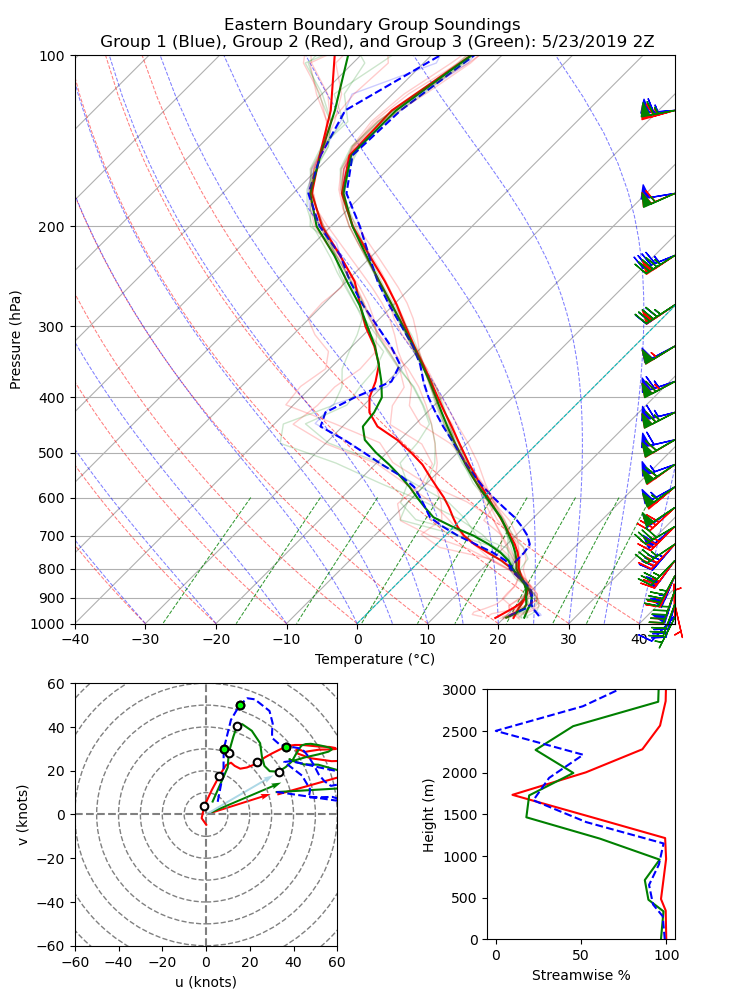

In [4]:
#df = pd.read_excel("C:/Users/kyled/Desktop/HRRRouts/combined_EW.xlsx")
df = pd.read_csv('C:/Users/kyled/Desktop/UNL MS Thesis/6 - SkewTs/5_22_VerticalProfs_QC_Grouped.csv')

folder = r"C:\Users\kyled\Desktop\UNL MS Thesis\6 - SkewTs\Soundings"
col_names = ['pressure', 'temperature', 'dewpoint', 'height', 'uwnd', 'vwnd']

time = 2
day = 23

combP_1 = []
combT_1 = []
combTd_1 = []
combH_1 = []
combU_1 = []
combV_1 = []

combP_2 = []
combT_2 = []
combTd_2 = []
combH_2 = []
combU_2 = []
combV_2 = []

combP_3 = []
combT_3 = []
combTd_3 = []
combH_3 = []
combU_3 = []
combV_3 = []

combinedP_1 = []
combinedT_1 = []
combinedTd_1 = []
combinedH_1 = []
combinedU_1 = []
combinedV_1 = []

combinedP_2 = []
combinedT_2 = []
combinedTd_2 = []
combinedH_2 = []
combinedU_2 = []
combinedV_2 = []

combinedP_3 = []
combinedT_3 = []
combinedTd_3 = []
combinedH_3 = []
combinedU_3 = []
combinedV_3 = []

interpP_1 = []
interpT_1 = []
interpTd_1 = []
interpH_1 = []
interpU_1 = []
interpV_1 = []

interpP_2 = []
interpT_2 = []
interpTd_2 = []
interpH_2 = []
interpU_2 = []
interpV_2 = []

interpP_3 = []
interpT_3 = []
interpTd_3 = []
interpH_3 = []
interpU_3 = []
interpV_3 = []

sfcP_1 = []
sfcT_1 = []
sfcTd_1 = []
sfcH_1 = []
sfcU_1 = []
sfcV_1 = []

sfcP_2 = []
sfcT_2 = []
sfcTd_2 = []
sfcH_2 = []
sfcU_2 = []
sfcV_2 = []

sfcP_3 = []
sfcT_3 = []
sfcTd_3 = []
sfcH_3 = []
sfcU_3 = []
sfcV_3 = []

###
combP_1sup = []
combT_1sup = []
combTd_1sup = []
combH_1sup = []
combU_1sup = []
combV_1sup = []

combP_2sup = []
combT_2sup = []
combTd_2sup = []
combH_2sup = []
combU_2sup = []
combV_2sup = []

combP_3sup = []
combT_3sup = []
combTd_3sup = []
combH_3sup = []
combU_3sup = []
combV_3sup = []

combinedP_1sup = []
combinedT_1sup = []
combinedTd_1sup = []
combinedH_1sup = []
combinedU_1sup = []
combinedV_1sup = []

combinedP_2sup = []
combinedT_2sup = []
combinedTd_2sup = []
combinedH_2sup = []
combinedU_2sup = []
combinedV_2sup = []

combinedP_3sup = []
combinedT_3sup = []
combinedTd_3sup = []
combinedH_3sup = []
combinedU_3sup = []
combinedV_3sup = []

interpP_1sup = []
interpT_1sup = []
interpTd_1sup = []
interpH_1sup = []
interpU_1sup = []
interpV_1sup = []

interpP_2sup = []
interpT_2sup = []
interpTd_2sup = []
interpH_2sup = []
interpU_2sup = []
interpV_2sup = []

interpP_3sup = []
interpT_3sup = []
interpTd_3sup = []
interpH_3sup = []
interpU_3sup = []
interpV_3sup = []

sfcP_1sup = []
sfcT_1sup = []
sfcTd_1sup = []
sfcH_1sup = []
sfcU_1sup = []
sfcV_1sup = []

sfcP_2sup = []
sfcT_2sup = []
sfcTd_2sup = []
sfcH_2sup = []
sfcU_2sup = []
sfcV_2sup = []

sfcP_3sup = []
sfcT_3sup = []
sfcTd_3sup = []
sfcH_3sup = []
sfcU_3sup = []
sfcV_3sup = []
###

interpP_1 = [940.0, 925.0, 900.0, 875.0, 850.0, 825.0, 800.0, 775.0, 750.0, 725.0, 700.0, 675.0,
          650.0, 625.0, 600.0, 575.0, 550.0, 525.0, 500.0, 475.0, 450.0, 425.0, 400.0, 375.0,
          350.0, 325.0, 300.0, 275.0, 250.0, 225.0, 200.0, 175.0, 150.0, 125.0, 100.0]
interpP_2 = [940.0, 925.0, 900.0, 875.0, 850.0, 825.0, 800.0, 775.0, 750.0, 725.0, 700.0, 675.0,
          650.0, 625.0, 600.0, 575.0, 550.0, 525.0, 500.0, 475.0, 450.0, 425.0, 400.0, 375.0,
          350.0, 325.0, 300.0, 275.0, 250.0, 225.0, 200.0, 175.0, 150.0, 125.0, 100.0]
interpP_3 = [940.0, 925.0, 900.0, 875.0, 850.0, 825.0, 800.0, 775.0, 750.0, 725.0, 700.0, 675.0,
          650.0, 625.0, 600.0, 575.0, 550.0, 525.0, 500.0, 475.0, 450.0, 425.0, 400.0, 375.0,
          350.0, 325.0, 300.0, 275.0, 250.0, 225.0, 200.0, 175.0, 150.0, 125.0, 100.0]

interpP_1sup = [940.0, 925.0, 900.0, 875.0, 850.0, 825.0, 800.0, 775.0, 750.0, 725.0, 700.0, 675.0,
          650.0, 625.0, 600.0, 575.0, 550.0, 525.0, 500.0, 475.0, 450.0, 425.0, 400.0, 375.0,
          350.0, 325.0, 300.0, 275.0, 250.0, 225.0, 200.0, 175.0, 150.0, 125.0, 100.0]
interpP_2sup = [940.0, 925.0, 900.0, 875.0, 850.0, 825.0, 800.0, 775.0, 750.0, 725.0, 700.0, 675.0,
          650.0, 625.0, 600.0, 575.0, 550.0, 525.0, 500.0, 475.0, 450.0, 425.0, 400.0, 375.0,
          350.0, 325.0, 300.0, 275.0, 250.0, 225.0, 200.0, 175.0, 150.0, 125.0, 100.0]
interpP_3sup = [940.0, 925.0, 900.0, 875.0, 850.0, 825.0, 800.0, 775.0, 750.0, 725.0, 700.0, 675.0,
          650.0, 625.0, 600.0, 575.0, 550.0, 525.0, 500.0, 475.0, 450.0, 425.0, 400.0, 375.0,
          350.0, 325.0, 300.0, 275.0, 250.0, 225.0, 200.0, 175.0, 150.0, 125.0, 100.0]

#########################################################################################
#for i in df[df.Grouping==1][df.Time==20]['StormID']:
for i in df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE1']['StormID']:
#for i in df[df.EWB=='W'][df.Time==time][df.Supercell=='Y']['StormID']:   
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        prof1 = profile.create_profile(profile='default', pres=sounding_df['pressure'], hght=sounding_df['height'],
                                       tmpc=sounding_df['temperature'], dwpc=sounding_df['dewpoint'],
                                       u=sounding_df['uwnd'], v=sounding_df['vwnd'], missing=-9999)
       
        sfcP_one = sharppy.sharptab.interp.pres(prof1, 0)
        sfcT_one = sharppy.sharptab.interp.temp(prof1, sfcP_one)
        sfcTd_one = sharppy.sharptab.interp.dwpt(prof1, sfcP_one)
        sfcWind_one = sharppy.sharptab.interp.components(prof1, sfcP_one)
        sfcU_one = sfcWind_one[0]
        sfcV_one = sfcWind_one[1]
        
        sfcP_1.append(sfcP_one)
        sfcT_1.append(sfcT_one)
        sfcTd_1.append(sfcTd_one)
        sfcU_1.append(sfcU_one)
        sfcV_1.append(sfcV_one)

        interpT_1 = []
        interpTd_1 = []
        interpH_1 = []
        interpU_1 = []
        interpV_1 = []                
        
        for k in interpP_1:
            H_1 = sharppy.sharptab.interp.hght(prof1, k)
            T_1 = sharppy.sharptab.interp.temp(prof1, k)
            Td_1 = sharppy.sharptab.interp.dwpt(prof1, k)
            Wind_1 = sharppy.sharptab.interp.components(prof1, k)
            U_1 = Wind_1[0]
            V_1 = Wind_1[1]
            
            interpT_1.append(T_1)
            interpTd_1.append(Td_1)
            interpH_1.append(H_1)
            interpU_1.append(U_1)
            interpV_1.append(V_1)
        
        combP_1.append(np.asarray(interpP_1))
        combT_1.append(np.asarray(interpT_1))
        combTd_1.append(np.asarray(interpTd_1))
        combH_1.append(np.asarray(interpH_1))
        combU_1.append(np.asarray(interpU_1))
        combV_1.append(np.asarray(interpV_1))

#########################################################################################
#for i in df[df.Grouping==1][df.Time==20]['StormID']:
for i in df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE2']['StormID']:
#for i in df[df.EWB=='W'][df.Time==time][df.Supercell=='Y']['StormID']:    
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        prof2 = profile.create_profile(profile='default', pres=sounding_df['pressure'], hght=sounding_df['height'],
                                       tmpc=sounding_df['temperature'], dwpc=sounding_df['dewpoint'],
                                       u=sounding_df['uwnd'], v=sounding_df['vwnd'], missing=-9999)
       
        sfcP_two = sharppy.sharptab.interp.pres(prof2, 0)
        sfcT_two = sharppy.sharptab.interp.temp(prof2, sfcP_two)
        sfcTd_two = sharppy.sharptab.interp.dwpt(prof2, sfcP_two)
        sfcWind_two = sharppy.sharptab.interp.components(prof2, sfcP_two)
        sfcU_two = sfcWind_two[0]
        sfcV_two = sfcWind_two[1]
        
        sfcP_2.append(sfcP_two)
        sfcT_2.append(sfcT_two)
        sfcTd_2.append(sfcTd_two)
        sfcU_2.append(sfcU_two)
        sfcV_2.append(sfcV_two)

        interpT_2 = []
        interpTd_2 = []
        interpH_2 = []
        interpU_2 = []
        interpV_2 = []                
        
        for k in interpP_2:
            H_2 = sharppy.sharptab.interp.hght(prof2, k)
            T_2 = sharppy.sharptab.interp.temp(prof2, k)
            Td_2 = sharppy.sharptab.interp.dwpt(prof2, k)
            Wind_2 = sharppy.sharptab.interp.components(prof2, k)
            U_2 = Wind_2[0]
            V_2 = Wind_2[1]
            
            interpT_2.append(T_2)
            interpTd_2.append(Td_2)
            interpH_2.append(H_2)
            interpU_2.append(U_2)
            interpV_2.append(V_2)
        
        combP_2.append(np.asarray(interpP_2))
        combT_2.append(np.asarray(interpT_2))
        combTd_2.append(np.asarray(interpTd_2))
        combH_2.append(np.asarray(interpH_2))
        combU_2.append(np.asarray(interpU_2))
        combV_2.append(np.asarray(interpV_2))

#########################################################################################
#for i in df[df.Grouping==1][df.Time==20]['StormID']:
for i in df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE3']['StormID']:
#for i in df[df.EWB=='W'][df.Time==time][df.Supercell=='Y']['StormID']:   
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        prof3 = profile.create_profile(profile='default', pres=sounding_df['pressure'], hght=sounding_df['height'],
                                       tmpc=sounding_df['temperature'], dwpc=sounding_df['dewpoint'],
                                       u=sounding_df['uwnd'], v=sounding_df['vwnd'], missing=-9999)
       
        sfcP_three = sharppy.sharptab.interp.pres(prof3, 0)
        sfcT_three = sharppy.sharptab.interp.temp(prof3, sfcP_three)
        sfcTd_three = sharppy.sharptab.interp.dwpt(prof3, sfcP_three)
        sfcWind_three = sharppy.sharptab.interp.components(prof3, sfcP_three)
        sfcU_three = sfcWind_three[0]
        sfcV_three = sfcWind_three[1]
        
        sfcP_3.append(sfcP_three)
        sfcT_3.append(sfcT_three)
        sfcTd_3.append(sfcTd_three)
        sfcU_3.append(sfcU_three)
        sfcV_3.append(sfcV_three)

        interpT_3 = []
        interpTd_3 = []
        interpH_3 = []
        interpU_3 = []
        interpV_3 = []                
        
        for k in interpP_3:
            H_3 = sharppy.sharptab.interp.hght(prof3, k)
            T_3 = sharppy.sharptab.interp.temp(prof3, k)
            Td_3 = sharppy.sharptab.interp.dwpt(prof3, k)
            Wind_3 = sharppy.sharptab.interp.components(prof3, k)
            U_3 = Wind_3[0]
            V_3 = Wind_3[1]
            
            interpT_3.append(T_3)
            interpTd_3.append(Td_3)
            interpH_3.append(H_3)
            interpU_3.append(U_3)
            interpV_3.append(V_3)
        
        combP_3.append(np.asarray(interpP_3))
        combT_3.append(np.asarray(interpT_3))
        combTd_3.append(np.asarray(interpTd_3))
        combH_3.append(np.asarray(interpH_3))
        combU_3.append(np.asarray(interpU_3))
        combV_3.append(np.asarray(interpV_3))

#########################################################################################
#for i in df[df.Grouping==1][df.Time==20]['StormID']:
for i in df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE1'][df.Supercell=="Y"]['StormID']:
#for i in df[df.EWB=='W'][df.Time==time][df.Supercell=='Y']['StormID']:    
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        prof1sup = profile.create_profile(profile='default', pres=sounding_df['pressure'], hght=sounding_df['height'],
                                       tmpc=sounding_df['temperature'], dwpc=sounding_df['dewpoint'],
                                       u=sounding_df['uwnd'], v=sounding_df['vwnd'], missing=-9999)
       
        sfcP_1Sup = sharppy.sharptab.interp.pres(prof1sup, 0)
        sfcT_1Sup = sharppy.sharptab.interp.temp(prof1sup, sfcP_1Sup)
        sfcTd_1Sup = sharppy.sharptab.interp.dwpt(prof1sup, sfcP_1Sup)
        sfcWind_1Sup = sharppy.sharptab.interp.components(prof1sup, sfcP_1Sup)
        sfcU_1Sup = sfcWind_1Sup[0]
        sfcV_1Sup = sfcWind_1Sup[1]
        
        sfcP_1sup.append(sfcP_1Sup)
        sfcT_1sup.append(sfcT_1Sup)
        sfcTd_1sup.append(sfcTd_1Sup)
        sfcU_1sup.append(sfcU_1Sup)
        sfcV_1sup.append(sfcV_1Sup)

        interpT_1sup = []
        interpTd_1sup = []
        interpH_1sup = []
        interpU_1sup = []
        interpV_1sup = []                
        
        for k in interpP_1sup:
            H_1sup = sharppy.sharptab.interp.hght(prof1sup, k)
            T_1sup = sharppy.sharptab.interp.temp(prof1sup, k)
            Td_1sup = sharppy.sharptab.interp.dwpt(prof1sup, k)
            Wind_1sup = sharppy.sharptab.interp.components(prof1sup, k)
            U_1sup = Wind_1sup[0]
            V_1sup = Wind_1sup[1]
            
            interpT_1sup.append(T_1sup)
            interpTd_1sup.append(Td_1sup)
            interpH_1sup.append(H_1sup)
            interpU_1sup.append(U_1sup)
            interpV_1sup.append(V_1sup)
        
        combP_1sup.append(np.asarray(interpP_1sup))
        combT_1sup.append(np.asarray(interpT_1sup))
        combTd_1sup.append(np.asarray(interpTd_1sup))
        combH_1sup.append(np.asarray(interpH_1sup))
        combU_1sup.append(np.asarray(interpU_1sup))
        combV_1sup.append(np.asarray(interpV_1sup))

##########################################################################################
#for i in df[df.Grouping==1][df.Time==20]['StormID']:
for i in df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE2'][df.Supercell=="Y"]['StormID']:
#for i in df[df.EWB=='W'][df.Time==time][df.Supercell=='Y']['StormID']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        prof2sup = profile.create_profile(profile='default', pres=sounding_df['pressure'], hght=sounding_df['height'],
                                       tmpc=sounding_df['temperature'], dwpc=sounding_df['dewpoint'],
                                       u=sounding_df['uwnd'], v=sounding_df['vwnd'], missing=-9999)
       
        sfcP_2Sup = sharppy.sharptab.interp.pres(prof2sup, 0)
        sfcT_2Sup = sharppy.sharptab.interp.temp(prof2sup, sfcP_2Sup)
        sfcTd_2Sup = sharppy.sharptab.interp.dwpt(prof2sup, sfcP_2Sup)
        sfcWind_2Sup = sharppy.sharptab.interp.components(prof2sup, sfcP_2Sup)
        sfcU_2Sup = sfcWind_2Sup[0]
        sfcV_2Sup = sfcWind_2Sup[1]
        
        sfcP_2sup.append(sfcP_2Sup)
        sfcT_2sup.append(sfcT_2Sup)
        sfcTd_2sup.append(sfcTd_2Sup)
        sfcU_2sup.append(sfcU_2Sup)
        sfcV_2sup.append(sfcV_2Sup)

        interpT_2sup = []
        interpTd_2sup = []
        interpH_2sup = []
        interpU_2sup = []
        interpV_2sup = []                
        
        for k in interpP_2sup:
            H_2sup = sharppy.sharptab.interp.hght(prof2sup, k)
            T_2sup = sharppy.sharptab.interp.temp(prof2sup, k)
            Td_2sup = sharppy.sharptab.interp.dwpt(prof2sup, k)
            Wind_2sup = sharppy.sharptab.interp.components(prof2sup, k)
            U_2sup = Wind_2sup[0]
            V_2sup = Wind_2sup[1]
            
            interpT_2sup.append(T_2sup)
            interpTd_2sup.append(Td_2sup)
            interpH_2sup.append(H_2sup)
            interpU_2sup.append(U_2sup)
            interpV_2sup.append(V_2sup)
        
        combP_2sup.append(np.asarray(interpP_2sup))
        combT_2sup.append(np.asarray(interpT_2sup))
        combTd_2sup.append(np.asarray(interpTd_2sup))
        combH_2sup.append(np.asarray(interpH_2sup))
        combU_2sup.append(np.asarray(interpU_2sup))
        combV_2sup.append(np.asarray(interpV_2sup))

##########################################################################################
#for i in df[df.Grouping==1][df.Time==20]['StormID']:
for i in df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE3'][df.Supercell=="Y"]['StormID']:
#for i in df[df.EWB=='W'][df.Time==time][df.Supercell=='Y']['StormID']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        prof3sup = profile.create_profile(profile='default', pres=sounding_df['pressure'], hght=sounding_df['height'],
                                       tmpc=sounding_df['temperature'], dwpc=sounding_df['dewpoint'],
                                       u=sounding_df['uwnd'], v=sounding_df['vwnd'], missing=-9999)
       
        sfcP_3Sup = sharppy.sharptab.interp.pres(prof3sup, 0)
        sfcT_3Sup = sharppy.sharptab.interp.temp(prof3sup, sfcP_3Sup)
        sfcTd_3Sup = sharppy.sharptab.interp.dwpt(prof3sup, sfcP_3Sup)
        sfcWind_3Sup = sharppy.sharptab.interp.components(prof3sup, sfcP_3Sup)
        sfcU_3Sup = sfcWind_3Sup[0]
        sfcV_3Sup = sfcWind_3Sup[1]
        
        sfcP_3sup.append(sfcP_3Sup)
        sfcT_3sup.append(sfcT_3Sup)
        sfcTd_3sup.append(sfcTd_3Sup)
        sfcU_3sup.append(sfcU_3Sup)
        sfcV_3sup.append(sfcV_3Sup)

        interpT_3sup = []
        interpTd_3sup = []
        interpH_3sup = []
        interpU_3sup = []
        interpV_3sup = []                
        
        for k in interpP_3sup:
            H_3sup = sharppy.sharptab.interp.hght(prof3sup, k)
            T_3sup = sharppy.sharptab.interp.temp(prof3sup, k)
            Td_3sup = sharppy.sharptab.interp.dwpt(prof3sup, k)
            Wind_3sup = sharppy.sharptab.interp.components(prof3sup, k)
            U_3sup = Wind_3sup[0]
            V_3sup = Wind_3sup[1]
            
            interpT_3sup.append(T_3sup)
            interpTd_3sup.append(Td_3sup)
            interpH_3sup.append(H_3sup)
            interpU_3sup.append(U_3sup)
            interpV_3sup.append(V_3sup)
        
        combP_3sup.append(np.asarray(interpP_3sup))
        combT_3sup.append(np.asarray(interpT_3sup))
        combTd_3sup.append(np.asarray(interpTd_3sup))
        combH_3sup.append(np.asarray(interpH_3sup))
        combU_3sup.append(np.asarray(interpU_3sup))
        combV_3sup.append(np.asarray(interpV_3sup))
##########################################################################################      
combP_1=np.asarray(combP_1)
combT_1=np.asarray(combT_1)
combTd_1=np.asarray(combTd_1)
combH_1=np.asarray(combH_1)
combU_1=np.asarray(combU_1)
combV_1=np.asarray(combV_1)

combP_2=np.asarray(combP_2)
combT_2=np.asarray(combT_2)
combTd_2=np.asarray(combTd_2)
combH_2=np.asarray(combH_2)
combU_2=np.asarray(combU_2)
combV_2=np.asarray(combV_2)

combP_3=np.asarray(combP_3)
combT_3=np.asarray(combT_3)
combTd_3=np.asarray(combTd_3)
combH_3=np.asarray(combH_3)
combU_3=np.asarray(combU_3)
combV_3=np.asarray(combV_3)

combP_1sup=np.asarray(combP_1sup)
combT_1sup=np.asarray(combT_1sup)
combTd_1sup=np.asarray(combTd_1sup)
combH_1sup=np.asarray(combH_1sup)
combU_1sup=np.asarray(combU_1sup)
combV_1sup=np.asarray(combV_1sup)

combP_2sup=np.asarray(combP_2sup)
combT_2sup=np.asarray(combT_2sup)
combTd_2sup=np.asarray(combTd_2sup)
combH_2sup=np.asarray(combH_2sup)
combU_2sup=np.asarray(combU_2sup)
combV_2sup=np.asarray(combV_2sup)
   
combP_3sup=np.asarray(combP_3sup)
combT_3sup=np.asarray(combT_3sup)
combTd_3sup=np.asarray(combTd_3sup)
combH_3sup=np.asarray(combH_3sup)
combU_3sup=np.asarray(combU_3sup)
combV_3sup=np.asarray(combV_3sup)

##########################################################################################  
sfcP_1=np.asarray(sfcP_1)
sfcT_1=np.asarray(sfcT_1)
sfcTd_1=np.asarray(sfcTd_1)
sfcU_1=np.asarray(sfcU_1)
sfcV_1=np.asarray(sfcV_1)

sfcP_2=np.asarray(sfcP_2)
sfcT_2=np.asarray(sfcT_2)
sfcTd_2=np.asarray(sfcTd_2)
sfcU_2=np.asarray(sfcU_2)
sfcV_2=np.asarray(sfcV_2)

sfcP_3=np.asarray(sfcP_3)
sfcT_3=np.asarray(sfcT_3)
sfcTd_3=np.asarray(sfcTd_3)
sfcU_3=np.asarray(sfcU_3)
sfcV_3=np.asarray(sfcV_3)

sfcP_1sup=np.asarray(sfcP_1sup)
sfcT_1sup=np.asarray(sfcT_1sup)
sfcTd_1sup=np.asarray(sfcTd_1sup)
sfcU_1sup=np.asarray(sfcU_1sup)
sfcV_1sup=np.asarray(sfcV_1sup)

sfcP_2sup=np.asarray(sfcP_2sup)
sfcT_2sup=np.asarray(sfcT_2sup)
sfcTd_2sup=np.asarray(sfcTd_2sup)
sfcU_2sup=np.asarray(sfcU_2sup)
sfcV_2sup=np.asarray(sfcV_2sup)

sfcP_3sup=np.asarray(sfcP_3sup)
sfcT_3sup=np.asarray(sfcT_3sup)
sfcTd_3sup=np.asarray(sfcTd_3sup)
sfcU_3sup=np.asarray(sfcU_3sup)
sfcV_3sup=np.asarray(sfcV_3sup)

##########################################################################################  
PRES_1=[]
TEMP_1=[]
DEWP_1=[]
HGHT_1=[]
UWND_1=[]
VWND_1=[]

PRES_2=[]
TEMP_2=[]
DEWP_2=[]
HGHT_2=[]
UWND_2=[]
VWND_2=[]

PRES_3=[]
TEMP_3=[]
DEWP_3=[]
HGHT_3=[]
UWND_3=[]
VWND_3=[]

PRES_1sup=[]
TEMP_1sup=[]
DEWP_1sup=[]
HGHT_1sup=[]
UWND_1sup=[]
VWND_1sup=[]

PRES_2sup=[]
TEMP_2sup=[]
DEWP_2sup=[]
HGHT_2sup=[]
UWND_2sup=[]
VWND_2sup=[]

PRES_3sup=[]
TEMP_3sup=[]
DEWP_3sup=[]
HGHT_3sup=[]
UWND_3sup=[]
VWND_3sup=[]

##########################################################################################  
for l in range(0,len(sfcP_1)):
    PRES_1.append(np.insert(combP_1[l],0,sfcP_1[l]))
    TEMP_1.append(np.insert(combT_1[l],0,sfcT_1[l]))
    DEWP_1.append(np.insert(combTd_1[l],0,sfcTd_1[l]))
    HGHT_1.append(np.insert(combH_1[l],0,0))
    UWND_1.append(np.insert(combU_1[l],0,sfcU_1[l]))
    VWND_1.append(np.insert(combV_1[l],0,sfcV_1[l]))
    
for l in range(0,len(sfcP_2)):
    PRES_2.append(np.insert(combP_2[l],0,sfcP_2[l]))
    TEMP_2.append(np.insert(combT_2[l],0,sfcT_2[l]))
    DEWP_2.append(np.insert(combTd_2[l],0,sfcTd_2[l]))
    HGHT_2.append(np.insert(combH_2[l],0,0))
    UWND_2.append(np.insert(combU_2[l],0,sfcU_2[l]))
    VWND_2.append(np.insert(combV_2[l],0,sfcV_2[l]))
    
for l in range(0,len(sfcP_3)):
    PRES_3.append(np.insert(combP_3[l],0,sfcP_3[l]))
    TEMP_3.append(np.insert(combT_3[l],0,sfcT_3[l]))
    DEWP_3.append(np.insert(combTd_3[l],0,sfcTd_3[l]))
    HGHT_3.append(np.insert(combH_3[l],0,0))
    UWND_3.append(np.insert(combU_3[l],0,sfcU_3[l]))
    VWND_3.append(np.insert(combV_3[l],0,sfcV_3[l]))

for l in range(0,len(sfcP_1sup)):
    PRES_1sup.append(np.insert(combP_1sup[l],0,sfcP_1sup[l]))
    TEMP_1sup.append(np.insert(combT_1sup[l],0,sfcT_1sup[l]))
    DEWP_1sup.append(np.insert(combTd_1sup[l],0,sfcTd_1sup[l]))
    HGHT_1sup.append(np.insert(combH_1sup[l],0,0))
    UWND_1sup.append(np.insert(combU_1sup[l],0,sfcU_1sup[l]))
    VWND_1sup.append(np.insert(combV_1sup[l],0,sfcV_1sup[l]))
    
for l in range(0,len(sfcP_2sup)):
    PRES_2sup.append(np.insert(combP_2sup[l],0,sfcP_2sup[l]))
    TEMP_2sup.append(np.insert(combT_2sup[l],0,sfcT_2sup[l]))
    DEWP_2sup.append(np.insert(combTd_2sup[l],0,sfcTd_2sup[l]))
    HGHT_2sup.append(np.insert(combH_2sup[l],0,0))
    UWND_2sup.append(np.insert(combU_2sup[l],0,sfcU_2sup[l]))
    VWND_2sup.append(np.insert(combV_2sup[l],0,sfcV_2sup[l]))

for l in range(0,len(sfcP_3sup)):
    PRES_3sup.append(np.insert(combP_3sup[l],0,sfcP_3sup[l]))
    TEMP_3sup.append(np.insert(combT_3sup[l],0,sfcT_3sup[l]))
    DEWP_3sup.append(np.insert(combTd_3sup[l],0,sfcTd_3sup[l]))
    HGHT_3sup.append(np.insert(combH_3sup[l],0,0))
    UWND_3sup.append(np.insert(combU_3sup[l],0,sfcU_3sup[l]))
    VWND_3sup.append(np.insert(combV_3sup[l],0,sfcV_3sup[l]))

##########################################################################################  
#PRES_W=np.asarray(PRES_W)        
combinedP_1=pd.DataFrame(PRES_1).T
combinedT_1=pd.DataFrame(TEMP_1).T
combinedTd_1=pd.DataFrame(DEWP_1).T
combinedH_1=pd.DataFrame(HGHT_1).T
combinedU_1=pd.DataFrame(UWND_1).T
combinedV_1=pd.DataFrame(VWND_1).T        

combinedP_2=pd.DataFrame(PRES_2).T
combinedT_2=pd.DataFrame(TEMP_2).T
combinedTd_2=pd.DataFrame(DEWP_2).T
combinedH_2=pd.DataFrame(HGHT_2).T
combinedU_2=pd.DataFrame(UWND_2).T
combinedV_2=pd.DataFrame(VWND_2).T    

combinedP_3=pd.DataFrame(PRES_3).T
combinedT_3=pd.DataFrame(TEMP_3).T
combinedTd_3=pd.DataFrame(DEWP_3).T
combinedH_3=pd.DataFrame(HGHT_3).T
combinedU_3=pd.DataFrame(UWND_3).T
combinedV_3=pd.DataFrame(VWND_3).T  

combinedP_1sup=pd.DataFrame(PRES_1sup).T
combinedT_1sup=pd.DataFrame(TEMP_1sup).T
combinedTd_1sup=pd.DataFrame(DEWP_1sup).T
combinedH_1sup=pd.DataFrame(HGHT_1sup).T
combinedU_1sup=pd.DataFrame(UWND_1sup).T
combinedV_1sup=pd.DataFrame(VWND_1sup).T        

combinedP_2sup=pd.DataFrame(PRES_2sup).T
combinedT_2sup=pd.DataFrame(TEMP_2sup).T
combinedTd_2sup=pd.DataFrame(DEWP_2sup).T
combinedH_2sup=pd.DataFrame(HGHT_2sup).T
combinedU_2sup=pd.DataFrame(UWND_2sup).T
combinedV_2sup=pd.DataFrame(VWND_2sup).T   

combinedP_3sup=pd.DataFrame(PRES_3sup).T
combinedT_3sup=pd.DataFrame(TEMP_3sup).T
combinedTd_3sup=pd.DataFrame(DEWP_3sup).T
combinedH_3sup=pd.DataFrame(HGHT_3sup).T
combinedU_3sup=pd.DataFrame(UWND_3sup).T
combinedV_3sup=pd.DataFrame(VWND_3sup).T 

combinedP_1['meanP'] = combinedP_1.mean(axis=1)
combinedT_1['meanT'] = combinedT_1.mean(axis=1)
combinedTd_1['meanTd'] = combinedTd_1.mean(axis=1)
combinedH_1['meanH'] = combinedH_1.mean(axis=1)
combinedU_1['meanU'] = combinedU_1.mean(axis=1)
combinedV_1['meanV'] = combinedV_1.mean(axis=1)
        
combinedP_2['meanP'] = combinedP_2.mean(axis=1)
combinedT_2['meanT'] = combinedT_2.mean(axis=1)
combinedTd_2['meanTd'] = combinedTd_2.mean(axis=1)
combinedH_2['meanH'] = combinedH_2.mean(axis=1)
combinedU_2['meanU'] = combinedU_2.mean(axis=1)
combinedV_2['meanV'] = combinedV_2.mean(axis=1)

combinedP_3['meanP'] = combinedP_3.mean(axis=1)
combinedT_3['meanT'] = combinedT_3.mean(axis=1)
combinedTd_3['meanTd'] = combinedTd_3.mean(axis=1)
combinedH_3['meanH'] = combinedH_3.mean(axis=1)
combinedU_3['meanU'] = combinedU_3.mean(axis=1)
combinedV_3['meanV'] = combinedV_3.mean(axis=1)

combinedP_1sup['meanP'] = combinedP_1sup.mean(axis=1)
combinedT_1sup['meanT'] = combinedT_1sup.mean(axis=1)
combinedTd_1sup['meanTd'] = combinedTd_1sup.mean(axis=1)
combinedH_1sup['meanH'] = combinedH_1sup.mean(axis=1)
combinedU_1sup['meanU'] = combinedU_1sup.mean(axis=1)
combinedV_1sup['meanV'] = combinedV_1sup.mean(axis=1)
        
combinedP_2sup['meanP'] = combinedP_2sup.mean(axis=1)
combinedT_2sup['meanT'] = combinedT_2sup.mean(axis=1)
combinedTd_2sup['meanTd'] = combinedTd_2sup.mean(axis=1)
combinedH_2sup['meanH'] = combinedH_2sup.mean(axis=1)
combinedU_2sup['meanU'] = combinedU_2sup.mean(axis=1)
combinedV_2sup['meanV'] = combinedV_2sup.mean(axis=1)

combinedP_3sup['meanP'] = combinedP_3sup.mean(axis=1)
combinedT_3sup['meanT'] = combinedT_3sup.mean(axis=1)
combinedTd_3sup['meanTd'] = combinedTd_3sup.mean(axis=1)
combinedH_3sup['meanH'] = combinedH_3sup.mean(axis=1)
combinedU_3sup['meanU'] = combinedU_3sup.mean(axis=1)
combinedV_3sup['meanV'] = combinedV_3sup.mean(axis=1)

#######################################################
#Shear Calculations
if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE1']['StormID']) != 0:
    u_1 = np.asarray(combinedU_1['meanU'])/1.944
    v_1 = np.asarray(combinedV_1['meanV'])/1.944
    z_1 = np.asarray(combinedH_1['meanH'])
    
    profMS_W = profile.create_profile(profile='default', pres=np.asarray(combinedP_1['meanP']), hght=z_1,
                               tmpc=np.asarray(combinedT_1['meanT']), dwpc=np.asarray(combinedTd_1['meanTd']),
                               u=u_1, v=v_1, missing=-9999)
    
    srwindW = params.bunkers_storm_motion(profMS_W)
    uSR_W = u_1-srwindW[0]
    vSR_W = v_1-srwindW[1]
    
    dudz_W=(np.array(u_1[2::])-np.array(u_1[0:-2]))/(np.array(z_1[2::])-np.array(z_1[0:-2]))
    dvdz_W=(np.array(v_1[2::])-np.array(v_1[0:-2]))/(np.array(z_1[2::])-np.array(z_1[0:-2]))
    dudz_W=np.insert(dudz_W,0,dudz_W[0])
    dudz_W=np.insert(dudz_W,-1,dudz_W[-1])
    dvdz_W=np.insert(dvdz_W,0,dvdz_W[0])
    dvdz_W=np.insert(dvdz_W,-1,dvdz_W[-1])
    
    shear_W=np.sqrt(dudz_W**2+dvdz_W**2)+0.0000001
    # Vorticity components
    uvort_W=-dvdz_W
    vvort_W=dudz_W
    # Streamwise vorticity
    strmw_W=abs((uSR_W*uvort_W+vSR_W*vvort_W)/(np.sqrt(uSR_W**2+vSR_W**2)))
    # Streamwise fraction
    strmwperc_W=strmw_W/shear_W


if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE2']['StormID']) != 0:
    u_2 = np.asarray(combinedU_2['meanU'])/1.944
    v_2 = np.asarray(combinedV_2['meanV'])/1.944
    z_2 = np.asarray(combinedH_2['meanH'])
    
    profMS_E = profile.create_profile(profile='default', pres=np.asarray(combinedP_2['meanP']), hght=z_2,
                               tmpc=np.asarray(combinedT_2['meanT']), dwpc=np.asarray(combinedTd_2['meanTd']),
                               u=u_2, v=v_2, missing=-9999)
    
    srwindE = params.bunkers_storm_motion(profMS_E)
    uSR_E = u_2-srwindE[0]
    vSR_E = v_2-srwindE[1]
    
    dudz_E=(np.array(u_2[2::])-np.array(u_2[0:-2]))/(np.array(z_2[2::])-np.array(z_2[0:-2]))
    dvdz_E=(np.array(v_2[2::])-np.array(v_2[0:-2]))/(np.array(z_2[2::])-np.array(z_2[0:-2]))
    dudz_E=np.insert(dudz_E,0,dudz_E[0])
    dudz_E=np.insert(dudz_E,-1,dudz_E[-1])
    dvdz_E=np.insert(dvdz_E,0,dvdz_E[0])
    dvdz_E=np.insert(dvdz_E,-1,dvdz_E[-1])
    
    shear_E=np.sqrt(dudz_E**2+dvdz_E**2)+0.0000001
    # Vorticity components
    uvort_E=-dvdz_E
    vvort_E=dudz_E
    # Streamwise vorticity
    strmw_E=abs((uSR_E*uvort_E+vSR_E*vvort_E)/(np.sqrt(uSR_E**2+vSR_E**2)))
    # Streamwise fraction
    strmwperc_E=strmw_E/shear_E


if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE3']['StormID']) != 0:
    u_3 = np.asarray(combinedU_3['meanU'])/1.944
    v_3 = np.asarray(combinedV_3['meanV'])/1.944
    z_3 = np.asarray(combinedH_3['meanH'])
    
    profMS_3 = profile.create_profile(profile='default', pres=np.asarray(combinedP_3['meanP']), hght=z_3,
                               tmpc=np.asarray(combinedT_3['meanT']), dwpc=np.asarray(combinedTd_3['meanTd']),
                               u=u_3, v=v_3, missing=-9999)
    
    srwind3 = params.bunkers_storm_motion(profMS_3)
    uSR_3 = u_3-srwind3[0]
    vSR_3 = v_3-srwind3[1]

    dudz_3=(np.array(u_3[2::])-np.array(u_3[0:-2]))/(np.array(z_3[2::])-np.array(z_3[0:-2]))
    dvdz_3=(np.array(v_3[2::])-np.array(v_3[0:-2]))/(np.array(z_3[2::])-np.array(z_3[0:-2]))
    dudz_3=np.insert(dudz_3,0,dudz_3[0])
    dudz_3=np.insert(dudz_3,-1,dudz_3[-1])
    dvdz_3=np.insert(dvdz_3,0,dvdz_3[0])
    dvdz_3=np.insert(dvdz_3,-1,dvdz_3[-1])

    shear_3=np.sqrt(dudz_3**2+dvdz_3**2)+0.0000001
    # Vorticity components
    uvort_3=-dvdz_3
    vvort_3=dudz_3
    # Streamwise vorticity
    strmw_3=abs((uSR_3*uvort_3+vSR_3*vvort_3)/(np.sqrt(uSR_3**2+vSR_3**2)))
    # Streamwise fraction
    strmwperc_3=strmw_3/shear_3

#################################################
#Shear Calculations
if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE1'][df.Supercell=="Y"]['StormID']) != 0:
    u_1sup = np.asarray(combinedU_1sup['meanU'])/1.944
    v_1sup = np.asarray(combinedV_1sup['meanV'])/1.944
    z_1sup = np.asarray(combinedH_1sup['meanH'])

    profMS_Wsup = profile.create_profile(profile='default', pres=np.asarray(combinedP_1sup['meanP']), hght=z_1sup,
                               tmpc=np.asarray(combinedT_1sup['meanT']), dwpc=np.asarray(combinedTd_1sup['meanTd']),
                               u=u_1sup, v=v_1sup, missing=-9999)

    srwindWsup = params.bunkers_storm_motion(profMS_Wsup)
    uSR_Wsup = u_1sup-srwindWsup[0]
    vSR_Wsup = v_1sup-srwindWsup[1]
    
    dudz_Wsup=(np.array(u_1sup[2::])-np.array(u_1sup[0:-2]))/(np.array(z_1sup[2::])-np.array(z_1sup[0:-2]))
    dvdz_Wsup=(np.array(v_1sup[2::])-np.array(v_1sup[0:-2]))/(np.array(z_1sup[2::])-np.array(z_1sup[0:-2]))
    dudz_Wsup=np.insert(dudz_Wsup,0,dudz_Wsup[0])
    dudz_Wsup=np.insert(dudz_Wsup,-1,dudz_Wsup[-1])
    dvdz_Wsup=np.insert(dvdz_Wsup,0,dvdz_Wsup[0])
    dvdz_Wsup=np.insert(dvdz_Wsup,-1,dvdz_Wsup[-1])

    shear_Wsup=np.sqrt(dudz_Wsup**2+dvdz_Wsup**2)+0.0000001
    # Vorticity components
    uvort_Wsup=-dvdz_Wsup
    vvort_Wsup=dudz_Wsup
    # Streamwise vorticity
    strmw_Wsup=abs((uSR_Wsup*uvort_Wsup+vSR_Wsup*vvort_Wsup)/(np.sqrt(uSR_Wsup**2+vSR_Wsup**2)))
    # Streamwise fraction
    strmwperc_Wsup=strmw_Wsup/shear_Wsup
    
    
if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE2'][df.Supercell=="Y"]['StormID']) != 0:
    u_2sup = np.asarray(combinedU_2sup['meanU'])/1.944
    v_2sup = np.asarray(combinedV_2sup['meanV'])/1.944
    z_2sup = np.asarray(combinedH_2sup['meanH'])

    profMS_Esup = profile.create_profile(profile='default', pres=np.asarray(combinedP_2sup['meanP']), hght=z_2sup,
                               tmpc=np.asarray(combinedT_2sup['meanT']), dwpc=np.asarray(combinedTd_2sup['meanTd']),
                               u=u_2sup, v=v_2sup, missing=-9999)
    
    srwindEsup = params.bunkers_storm_motion(profMS_Esup)
    uSR_Esup = u_2sup-srwindEsup[0]
    vSR_Esup = v_2sup-srwindEsup[1]
    
    dudz_Esup=(np.array(u_2sup[2::])-np.array(u_2sup[0:-2]))/(np.array(z_2sup[2::])-np.array(z_2sup[0:-2]))
    dvdz_Esup=(np.array(v_2sup[2::])-np.array(v_2sup[0:-2]))/(np.array(z_2sup[2::])-np.array(z_2sup[0:-2]))
    dudz_Esup=np.insert(dudz_Esup,0,dudz_Esup[0])
    dudz_Esup=np.insert(dudz_Esup,-1,dudz_Esup[-1])
    dvdz_Esup=np.insert(dvdz_Esup,0,dvdz_Esup[0])
    dvdz_Esup=np.insert(dvdz_Esup,-1,dvdz_Esup[-1])
    
    shear_Esup=np.sqrt(dudz_Esup**2+dvdz_Esup**2)+0.0000001
    # Vorticity components
    uvort_Esup=-dvdz_Esup
    vvort_Esup=dudz_Esup
    # Streamwise vorticity
    strmw_Esup=abs((uSR_Esup*uvort_Esup+vSR_Esup*vvort_Esup)/(np.sqrt(uSR_Esup**2+vSR_Esup**2)))
    # Streamwise fraction
    strmwperc_Esup=strmw_Esup/shear_Esup
    
    
if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE3'][df.Supercell=="Y"]['StormID']) != 0:
    u_3sup = np.asarray(combinedU_3sup['meanU'])/1.944
    v_3sup = np.asarray(combinedV_3sup['meanV'])/1.944
    z_3sup = np.asarray(combinedH_3sup['meanH'])

    profMS_3sup = profile.create_profile(profile='default', pres=np.asarray(combinedP_3sup['meanP']), hght=z_3sup,
                                   tmpc=np.asarray(combinedT_3sup['meanT']), dwpc=np.asarray(combinedTd_3sup['meanTd']),
                                   u=u_3sup, v=v_3sup, missing=-9999)
    
    srwind3sup = params.bunkers_storm_motion(profMS_3sup)
    uSR_3sup = u_3sup-srwind3sup[0]
    vSR_3sup = v_3sup-srwind3sup[1]  

    dudz_3sup=(np.array(u_3sup[2::])-np.array(u_3sup[0:-2]))/(np.array(z_3sup[2::])-np.array(z_3sup[0:-2]))
    dvdz_3sup=(np.array(v_3sup[2::])-np.array(v_3sup[0:-2]))/(np.array(z_3sup[2::])-np.array(z_3sup[0:-2]))
    dudz_3sup=np.insert(dudz_3sup,0,dudz_3sup[0])
    dudz_3sup=np.insert(dudz_3sup,-1,dudz_3sup[-1])
    dvdz_3sup=np.insert(dvdz_3sup,0,dvdz_3sup[0])
    dvdz_3sup=np.insert(dvdz_3sup,-1,dvdz_3sup[-1])

    shear_3sup=np.sqrt(dudz_3sup**2+dvdz_3sup**2)+0.0000001
    # Vorticity components
    uvort_3sup=-dvdz_3sup
    vvort_3sup=dudz_3sup
    # Streamwise vorticity
    strmw_3sup=abs((uSR_3sup*uvort_3sup+vSR_3sup*vvort_3sup)/(np.sqrt(uSR_3sup**2+vSR_3sup**2)))
    # Streamwise fraction
    strmwperc_3sup=strmw_3sup/shear_3sup

#######################################################
fig = plt.figure(figsize=(7.5, 10))
#gs=gridspec.GridSpec(nrows=6, ncols=4, figure=fig)

#ax0 = plt.subplot(gs.new_subplotspec((0,0), rowspan=4, colspan=4))

skew = SkewT(fig, rotation=45, rect=(0, 0.25, 0.8, 0.8)) # left, bottom, width, height (range 0 to 1)
#skew = SkewT(ax0, rotation=45)
#skew = SkewT(fig, rotation=45, subplot=gs[0:3, 0:3])

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot.

hpa1001 = np.where(combinedP_1['meanP'] >=100)
hpa1002 = np.where(combinedP_2['meanP'] >=100)
hpa1003 = np.where(combinedP_3['meanP'] >=100)

skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 45)
skew.ax.set_ylabel('Pressure (hPa)')
skew.ax.set_xlabel('Temperature (°C)')

if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE1']['StormID']) != 0:
    #skew.plot(combinedP_1['meanP'], combinedT_1['meanT'], 'b', linestyle='-', linewidth=1.5)
    #skew.plot(combinedP_1['meanP'], combinedTd_1['meanTd'], 'b', linestyle='-', linewidth=1.5)
    skew.plot_barbs(combinedP_1['meanP'][hpa1001[0]][::2], combinedU_1['meanU'][hpa1001[0]][::2], combinedV_1['meanV'][hpa1001[0]][::2], color='blue')

if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE2']['StormID']) != 0:
    skew.plot(combinedP_2['meanP'], combinedT_2['meanT'], 'r', linestyle='-', linewidth=1.5)
    skew.plot(combinedP_2['meanP'], combinedTd_2['meanTd'], 'r', linestyle='-', linewidth=1.5)
    skew.plot_barbs(combinedP_2['meanP'][hpa1002[0]][::2], combinedU_2['meanU'][hpa1002[0]][::2], combinedV_2['meanV'][hpa1002[0]][::2], color='red')

if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE3']['StormID']) != 0:
    skew.plot(combinedP_3['meanP'], combinedT_3['meanT'], 'g', linestyle='-', linewidth=1.5)
    skew.plot(combinedP_3['meanP'], combinedTd_3['meanTd'], 'g', linestyle='-', linewidth=1.5)
    skew.plot_barbs(combinedP_3['meanP'][hpa1003[0]][::2], combinedU_3['meanU'][hpa1003[0]][::2], combinedV_3['meanV'][hpa1003[0]][::2], color='green')

if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE1'][df.Supercell=="Y"]['StormID']) != 0:
    skew.plot(combinedP_1sup['meanP'], combinedT_1sup['meanT'], 'b', linestyle='--', linewidth=1.5)
    skew.plot(combinedP_1sup['meanP'], combinedTd_1sup['meanTd'], 'b', linestyle='--', linewidth=1.5)

if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE2'][df.Supercell=="Y"]['StormID']) != 0:
    skew.plot(combinedP_2sup['meanP'], combinedT_2sup['meanT'], 'r', linestyle='--', linewidth=1.5)
    skew.plot(combinedP_2sup['meanP'], combinedTd_2sup['meanTd'], 'r', linestyle='--', linewidth=1.5)

if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE3'][df.Supercell=="Y"]['StormID']) != 0:
    skew.plot(combinedP_3sup['meanP'], combinedT_3sup['meanT'], 'g', linestyle='--', linewidth=1.5)
    skew.plot(combinedP_3sup['meanP'], combinedTd_3sup['meanTd'], 'g', linestyle='--', linewidth=1.5)

for i in df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE1']['StormID']:
#for i in df[df.EWB=='BDE'][df.Time==time][df.Supercell=='Y']['StormID']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        skew.plot(np.asarray(sounding_df['pressure']), np.asarray(sounding_df['temperature']), 'b', linewidth=1.0, alpha=0.2)
        skew.plot(np.asarray(sounding_df['pressure']), np.asarray(sounding_df['dewpoint']), 'b', linewidth=1.0, alpha=0.2)

for i in df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE2']['StormID']:
#for i in df[df.EWB=='BDE'][df.Time==time][df.Supercell=='Y']['StormID']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        skew.plot(np.asarray(sounding_df['pressure']), np.asarray(sounding_df['temperature']), 'r', linewidth=1.0, alpha=0.2)
        skew.plot(np.asarray(sounding_df['pressure']), np.asarray(sounding_df['dewpoint']), 'r', linewidth=1.0, alpha=0.2)
        
for i in df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE3']['StormID']:
#for i in df[df.EWB=='BDE'][df.Time==time][df.Supercell=='Y']['StormID']:
    if time <10:
        timej = '0'+str(time)
    else:
        timej=time
    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_'+str(timej)+'_*.txt')
    
    #print(groupfiles)
    for j in range(0, len(groupfiles)):
        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        skew.plot(np.asarray(sounding_df['pressure']), np.asarray(sounding_df['temperature']), 'g', linewidth=1.0, alpha=0.2)
        skew.plot(np.asarray(sounding_df['pressure']), np.asarray(sounding_df['dewpoint']), 'g', linewidth=1.0, alpha=0.2)

        
#skew.plot(p2, T2, 'b')
#skew.plot(p2, Td2, 'b')
#skew.plot_barbs(p2[::150], u2[::150], v2[::150], color='blue')

# Calculate LCL height and plot as black dot. Because `p`'s first value is
# ~1000 mb and its last value is ~250 mb, the `0` index is selected for
# `p`, `T`, and `Td` to lift the parcel from the surface. If `p` was inverted,
# i.e. start from low value, 250 mb, to a high value, 1000 mb, the `-1` index
# should be selected.

#lcl_pressure, lcl_temperature = lcl(p[0], T[0], Td[0])
#skew.plot(lcl_pressure, lcl_temperature, marker=11, markerfacecolor='black', markers)

# Calculate full parcel profile and add to plot as black line
#prof = parcel_profile(p, T[0], Td[0]).to('degC')

#prof1 = mixed_parcel(p, T, Td)
#prof = parcel_profile(p, prof1[1], prof1[2]).to('degC')
#prof = parcel_profile(p, mlpcl.tmpc*units.degree_Celsius, mlpcl.dwpc*units.degree_Celsius).to('degC')


#mlpcl.tmpc*units.degree_Celsius
#skew.plot(p, prof, 'k', linewidth=1.5, linestyle='--')

# Shade areas of CAPE and CIN
#skew.shade_cin(p, T, prof, Td)
#skew.shade_cape(p, T, prof)

# An example of a slanted line at constant T -- in this case the 0
# isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=0.75)
#skew.ax.axvline(-20, color='c', linestyle='--', linewidth=1)
#skew.ax.axvline(-30, color='c', linestyle='--', linewidth=1)

#hgt0c = (mupcl.hght0c*units.meter).to(units.feet)
#hgtm20c = (mupcl.hghtm20c*units.meter).to(units.feet)
#hgtm30c = (mupcl.hghtm30c*units.meter).to(units.feet)

# Add the relevant special lines
skew.plot_dry_adiabats(linewidth=0.75)
skew.plot_moist_adiabats(linewidth=0.75)
skew.plot_mixing_lines(linewidth=0.75)

plt.title("Eastern Boundary Group Soundings \n Group 1 (Blue), Group 2 (Red), and Group 3 (Green): 5/"+str(day)+"/2019 "+str(time)+"Z")

# Add a secondary axis that automatically converts between pressure and height
# assuming a standard atmosphere. The value of -0.12 puts the secondary axis
# 0.12 normalized (0 to 1) coordinates left of the original axis.
#secax = skew.ax.secondary_yaxis(-0.14,
#    functions=(lambda p: pressure_to_height_std(units.Quantity(p, 'mbar')).m_as('feet'),
#               lambda h: height_to_pressure_std(units.Quantity(h, 'feet')).m))

#fig = plt.figure(figsize=(12, 12))
#gs=gridspec.GridSpec(2,2)


#ax = fig.add_subplot(gs[4,0])
#ax = plt.subplot(gs.new_subplotspec((4,0), rowspan=2, colspan=2))
#ax = fig.add_subplot(gs[1:2,3:])

ax = plt.axes((0, 0, 0.35, 0.35))
h = Hodograph(ax, component_range=60.)
h.add_grid(increment=10)
h.ax.set_xlabel('u (knots)')
h.ax.set_ylabel('v (knots)')

height_scale = combinedH_2['meanH'][hpa1002[0]].values
height = combinedH_2['meanH'][hpa1002[0]].values * units.m

#if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE1']['StormID']) != 0:
    #h.plot(combinedU_1['meanU'][hpa1001[0]],combinedV_1['meanV'][hpa1001[0]], alpha = 1.0,linewidth=1.5, color='blue')
if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE2']['StormID']) != 0:
    h.plot(combinedU_2['meanU'][hpa1002[0]],combinedV_2['meanV'][hpa1002[0]], alpha = 1.0,linewidth=1.5, color='red')
if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE3']['StormID']) != 0:
    h.plot(combinedU_3['meanU'][hpa1003[0]],combinedV_3['meanV'][hpa1003[0]], alpha = 1.0,linewidth=1.5, color='green')

if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE1'][df.Supercell=="Y"]['StormID']) != 0:
    h.plot(combinedU_1sup['meanU'][hpa1001[0]],combinedV_1sup['meanV'][hpa1001[0]], alpha = 1.0,linewidth=1.5, linestyle="--", color='blue')
if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE2'][df.Supercell=="Y"]['StormID']) != 0:
    h.plot(combinedU_2sup['meanU'][hpa1002[0]],combinedV_2sup['meanV'][hpa1002[0]], alpha = 1.0,linewidth=1.5, linestyle="--", color='red')
if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE3'][df.Supercell=="Y"]['StormID']) != 0:
    h.plot(combinedU_3sup['meanU'][hpa1003[0]],combinedV_3sup['meanV'][hpa1003[0]], alpha = 1.0,linewidth=1.5, linestyle="--", color='green')

#for i in df[df.EWB=='BDE'][df.Time==time]['StormID']:
#for i in df[df.EWB=='BDE'][df.Time==time][df.Supercell=='Y']['StormID']:
#    if i <10: ########### REPLACE ##########################################################
#        i = '0'+str(i)
#    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_*.txt')
    
    #print(groupfiles)
#    for j in range(0, len(groupfiles)):
#        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        #h.plot(np.asarray(sounding_df['uwnd'][hpa100[0]]), np.asarray(sounding_df['vwnd'][hpa100[0]]), linewidth=1.0, alpha=0.3, color='red')

#for i in df[df.EWB=='W'][df.Time==time]['StormID']:
#for i in df[df.EWB=='BDE'][df.Time==time][df.Supercell=='Y']['StormID']:
#    if i <10: ########### REPLACE ##########################################################
#        i = '0'+str(i)
#    groupfiles = glob.glob(folder+'\HRRR_'+str(i)+'_*.txt')
    
    #print(groupfiles)
#    for j in range(0, len(groupfiles)):
#        sounding_df = pd.read_csv(groupfiles[j], header = None, names = col_names, delim_whitespace=True)
        #h.plot(np.asarray(sounding_df['uwnd'][hpa100[0]]), np.asarray(sounding_df['vwnd'][hpa100[0]]), linewidth=1.0, alpha=0.3, color='blue')


#cmap_W = plt.cm.winter_r
#cmap_E = plt.cm.autumn_r
#cmap_W = truncate_colormap(cmap_W, 0.35, 0.85)
#cmap_E = truncate_colormap(cmap_E, 0.35, 0.85)

#for i in range(0, v3000E):
    #w_3km = h.plot(combinedU_1['meanU'][hpa100[0]][i:i+2],combinedV_1['meanV'][hpa100[0]][i:i+2], alpha = 0.6, linewidth=180*shear_W[i], color=cmap_W(int(strmwperc_W[i]*255)))
    #e_3km = h.plot(combinedU_2['meanU'][hpa100[0]][i:i+2],combinedV_2['meanV'][hpa100[0]][i:i+2], alpha = 0.6, linewidth=180*shear_E[i], color=cmap_E(int(strmwperc_E[i]*255)))
    #w_3km = h.plot(combinedU_1['meanU'][hpa100[0]][i:i+2],combinedV_1['meanV'][hpa100[0]][i:i+2], linewidth=2.0, color=cmap_W(int(strmwperc_W[i]*255)))
    #e_3km = h.plot(combinedU_2['meanU'][hpa100[0]][i:i+2],combinedV_2['meanV'][hpa100[0]][i:i+2], linewidth=2.0, color=cmap_E(int(strmwperc_E[i]*255)))
#h.plot_colormapped(combinedU_1['meanU'][hpa100[0]],combinedV_1['meanV'][hpa100[0]], height_scale, cmap=plt.cm.Blues,intervals=[10,15,25], linewidth=2)
#h.plot_colormapped(combinedU_2['meanU'][hpa100[0]],combinedV_2['meanV'][hpa100[0]], height_scale, cmap=plt.cm.Reds,intervals=[10,15,25], linewidth=2)

#h.plot(combinedU_1['meanU'][hpa100[0]][13],combinedV_1['meanV'][hpa100[0]][13], marker="s")
#h.ax.text(combinedU_1['meanU'][hpa100[0]][5],combinedV_1['meanV'][hpa100[0]][5],'1',fontsize=24,ha='left',fontweight='bold', color='black')
#h.ax.text(combinedU_2['meanU'][hpa100[0]][5],combinedV_2['meanV'][hpa100[0]][5],'1',fontsize=24,ha='left',fontweight='bold', color='black')

if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE1']['StormID']) != 0:
    val500W = find_nearest(combinedH_1['meanH'][hpa1001[0]], 500)
    val500posW = np.where(combinedH_1['meanH'][hpa1001[0]] == val500W)
    v500W = val500posW[0][0]

    val1000W = find_nearest(combinedH_1['meanH'][hpa1001[0]], 1000)
    val1000posW = np.where(combinedH_1['meanH'][hpa1001[0]] == val1000W)
    v1000W = val1000posW[0][0]

    val3000W = find_nearest(combinedH_1['meanH'][hpa1001[0]], 3000)
    val3000posW = np.where(combinedH_1['meanH'][hpa1001[0]] == val3000W)
    v3000W = val3000posW[0][0]

if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE2']['StormID']) != 0:
    val500E = find_nearest(combinedH_2['meanH'][hpa1002[0]], 500)
    val500posE = np.where(combinedH_2['meanH'][hpa1002[0]] == val500E)
    v500E = val500posE[0][0]

    val1000E = find_nearest(combinedH_2['meanH'][hpa1002[0]], 1000)
    val1000posE = np.where(combinedH_2['meanH'][hpa1002[0]] == val1000E)
    v1000E = val1000posE[0][0]

    val3000E = find_nearest(combinedH_2['meanH'][hpa1002[0]], 3000)
    val3000posE = np.where(combinedH_2['meanH'][hpa1002[0]] == val3000E)
    v3000E = val3000posE[0][0]

if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE3']['StormID']) != 0:
    val5003 = find_nearest(combinedH_3['meanH'][hpa1003[0]], 500)
    val500pos3 = np.where(combinedH_3['meanH'][hpa1003[0]] == val5003)
    v5003 = val500pos3[0][0]

    val10003 = find_nearest(combinedH_3['meanH'][hpa1003[0]], 1000)
    val1000pos3 = np.where(combinedH_3['meanH'][hpa1003[0]] == val10003)
    v10003 = val1000pos3[0][0]

    val30003 = find_nearest(combinedH_3['meanH'][hpa1003[0]], 3000)
    val3000pos3 = np.where(combinedH_3['meanH'][hpa1003[0]] == val30003)
    v30003 = val3000pos3[0][0]

###########
if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE1'][df.Supercell=="Y"]['StormID']) != 0:
    val500Wsup = find_nearest(combinedH_1sup['meanH'][hpa1001[0]], 500)
    val500posWsup = np.where(combinedH_1sup['meanH'][hpa1001[0]] == val500Wsup)
    v500Wsup = val500posWsup[0][0]

    val1000Wsup = find_nearest(combinedH_1sup['meanH'][hpa1001[0]], 1000)
    val1000posWsup = np.where(combinedH_1sup['meanH'][hpa1001[0]] == val1000Wsup)
    v1000Wsup = val1000posWsup[0][0]

    val3000Wsup = find_nearest(combinedH_1sup['meanH'][hpa1001[0]], 3000)
    val3000posWsup = np.where(combinedH_1sup['meanH'][hpa1001[0]] == val3000Wsup)
    v3000Wsup = val3000posWsup[0][0]

if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE2'][df.Supercell=="Y"]['StormID']) != 0:
    val500Esup = find_nearest(combinedH_2sup['meanH'][hpa1002[0]], 500)
    val500posEsup = np.where(combinedH_2sup['meanH'][hpa1002[0]] == val500Esup)
    v500Esup = val500posEsup[0][0]

    val1000Esup = find_nearest(combinedH_2sup['meanH'][hpa1002[0]], 1000)
    val1000posEsup = np.where(combinedH_2sup['meanH'][hpa1002[0]] == val1000Esup)
    v1000Esup = val1000posEsup[0][0]

    val3000Esup = find_nearest(combinedH_2sup['meanH'][hpa1002[0]], 3000)
    val3000posEsup = np.where(combinedH_2sup['meanH'][hpa1002[0]] == val3000Esup)
    v3000Esup = val3000posEsup[0][0]

if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE3'][df.Supercell=="Y"]['StormID']) != 0:
    val5003sup = find_nearest(combinedH_3sup['meanH'][hpa1003[0]], 500)
    val500pos3sup = np.where(combinedH_3sup['meanH'][hpa1003[0]] == val5003sup)
    v5003sup = val500pos3sup[0][0]

    val10003sup = find_nearest(combinedH_3sup['meanH'][hpa1003[0]], 1000)
    val1000pos3sup = np.where(combinedH_3sup['meanH'][hpa1003[0]] == val10003sup)
    v10003sup = val1000pos3sup[0][0]

    val30003sup = find_nearest(combinedH_3sup['meanH'][hpa1003[0]], 3000)
    val3000pos3sup = np.where(combinedH_3sup['meanH'][hpa1003[0]] == val30003sup)
    v30003sup = val3000pos3sup[0][0]

#######################
ax1 = plt.axes((0.55, 0.05, 0.25, 0.25))
############
if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE1']['StormID']) != 0:
    h.plot(combinedU_1['meanU'][hpa1001[0]][v500W],combinedV_1['meanV'][hpa1001[0]][v500W], marker="o", color='black', markersize=6)
    h.plot(combinedU_1['meanU'][hpa1001[0]][v1000W],combinedV_1['meanV'][hpa1001[0]][v1000W], marker="o", color='black', markersize=6)
    h.plot(combinedU_1['meanU'][hpa1001[0]][v3000W],combinedV_1['meanV'][hpa1001[0]][v3000W], marker="o", color='black', markersize=6)

    h.plot(combinedU_1['meanU'][hpa1001[0]][v500W],combinedV_1['meanV'][hpa1001[0]][v500W], marker="o", color='snow', markersize=3)
    h.plot(combinedU_1['meanU'][hpa1001[0]][v1000W],combinedV_1['meanV'][hpa1001[0]][v1000W], marker="o", color='snow', markersize=3)
    h.plot(combinedU_1['meanU'][hpa1001[0]][v3000W],combinedV_1['meanV'][hpa1001[0]][v3000W], marker="o", color='snow', markersize=3)

    #right1, left1, mean1 = bunkers_storm_motion(np.asarray(combinedP_1['meanP'][hpa1001[0]])* units.hPa, np.asarray(combinedU_1['meanU'][hpa1001[0]])* units.knot,np.asarray(combinedV_1['meanV'][hpa1001[0]])* units.knot, np.asarray(combinedH_1['meanH'][hpa1001[0]])* units.meter)
    #h.wind_vectors(right1[0], right1[1], color='blue')
    #h.ax.text(right1[0], right1[1],'M',fontsize=36,fontweight='bold', color='blue')

    #ax1.plot(strmwperc_W[0:v3000W+2]*100, z_1[0:v3000W+2], color="blue")
    
if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE2']['StormID']) != 0:
    h.plot(combinedU_2['meanU'][hpa1002[0]][v500E],combinedV_2['meanV'][hpa1002[0]][v500E], marker="o", color='black', markersize=6)
    h.plot(combinedU_2['meanU'][hpa1002[0]][v1000E],combinedV_2['meanV'][hpa1002[0]][v1000E], marker="o", color='black', markersize=6)
    h.plot(combinedU_2['meanU'][hpa1002[0]][v3000E],combinedV_2['meanV'][hpa1002[0]][v3000E], marker="o", color='black', markersize=6)

    h.plot(combinedU_2['meanU'][hpa1002[0]][v500E],combinedV_2['meanV'][hpa1002[0]][v500E], marker="o", color='snow', markersize=3)
    h.plot(combinedU_2['meanU'][hpa1002[0]][v1000E],combinedV_2['meanV'][hpa1002[0]][v1000E], marker="o", color='snow', markersize=3)
    h.plot(combinedU_2['meanU'][hpa1002[0]][v3000E],combinedV_2['meanV'][hpa1002[0]][v3000E], marker="o", color='snow', markersize=3)
    
    right2, left2, mean2 = bunkers_storm_motion(np.asarray(combinedP_2['meanP'][hpa1002[0]])* units.hPa, np.asarray(combinedU_2['meanU'][hpa1002[0]])* units.knot,np.asarray(combinedV_2['meanV'][hpa1002[0]])* units.knot, np.asarray(combinedH_2['meanH'][hpa1002[0]])* units.meter)
    h.wind_vectors(right2[0], right2[1], color='red')
    
    ax1.plot(strmwperc_E[0:v3000E+2]*100, z_2[0:v3000E+2], color="red")
    
if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE3']['StormID']) != 0:
    h.plot(combinedU_3['meanU'][hpa1003[0]][v5003],combinedV_3['meanV'][hpa1003[0]][v5003], marker="o", color='black', markersize=6)
    h.plot(combinedU_3['meanU'][hpa1003[0]][v10003],combinedV_3['meanV'][hpa1003[0]][v10003], marker="o", color='black', markersize=6)
    h.plot(combinedU_3['meanU'][hpa1003[0]][v30003],combinedV_3['meanV'][hpa1003[0]][v30003], marker="o", color='black', markersize=6)

    h.plot(combinedU_3['meanU'][hpa1003[0]][v5003],combinedV_3['meanV'][hpa1003[0]][v5003], marker="o", color='snow', markersize=3)
    h.plot(combinedU_3['meanU'][hpa1003[0]][v10003],combinedV_3['meanV'][hpa1003[0]][v10003], marker="o", color='snow', markersize=3)
    h.plot(combinedU_3['meanU'][hpa1003[0]][v30003],combinedV_3['meanV'][hpa1003[0]][v30003], marker="o", color='snow', markersize=3)

    right3, left3, mean3 = bunkers_storm_motion(np.asarray(combinedP_3['meanP'][hpa1003[0]])* units.hPa, np.asarray(combinedU_3['meanU'][hpa1003[0]])* units.knot,np.asarray(combinedV_3['meanV'][hpa1003[0]])* units.knot, np.asarray(combinedH_3['meanH'][hpa1003[0]])* units.meter)
    h.wind_vectors(right3[0], right3[1], color='green')
    
    ax1.plot(strmwperc_3[0:v30003+2]*100, z_3[0:v30003+2], color="green")

############
if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE1'][df.Supercell=="Y"]['StormID']) != 0:
    h.plot(combinedU_1sup['meanU'][hpa1001[0]][v500Wsup],combinedV_1sup['meanV'][hpa1001[0]][v500Wsup], marker="o", color='black', markersize=6)
    h.plot(combinedU_1sup['meanU'][hpa1001[0]][v1000Wsup],combinedV_1sup['meanV'][hpa1001[0]][v1000Wsup], marker="o", color='black', markersize=6)
    h.plot(combinedU_1sup['meanU'][hpa1001[0]][v3000Wsup],combinedV_1sup['meanV'][hpa1001[0]][v3000Wsup], marker="o", color='black', markersize=6)

    h.plot(combinedU_1sup['meanU'][hpa1001[0]][v500Wsup],combinedV_1sup['meanV'][hpa1001[0]][v500Wsup], marker="o", color='lime', markersize=3)
    h.plot(combinedU_1sup['meanU'][hpa1001[0]][v1000Wsup],combinedV_1sup['meanV'][hpa1001[0]][v1000Wsup], marker="o", color='lime', markersize=3)
    h.plot(combinedU_1sup['meanU'][hpa1001[0]][v3000Wsup],combinedV_1sup['meanV'][hpa1001[0]][v3000Wsup], marker="o", color='lime', markersize=3)
    
    right1, left1, mean1 = bunkers_storm_motion(np.asarray(combinedP_1sup['meanP'][hpa1001[0]])* units.hPa, np.asarray(combinedU_1sup['meanU'][hpa1001[0]])* units.knot,np.asarray(combinedV_1sup['meanV'][hpa1001[0]])* units.knot, np.asarray(combinedH_1sup['meanH'][hpa1001[0]])* units.meter)
    h.wind_vectors(right1[0], right1[1], color='lightblue', linestyle="--")
    #h.ax.text(right1[0], right1[1],'M',fontsize=36,fontweight='bold', color='blue')

    ax1.plot(strmwperc_Wsup[0:v3000Wsup+2]*100, z_1sup[0:v3000Wsup+2], color="blue", linestyle="--")
    
if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE2'][df.Supercell=="Y"]['StormID']) != 0:
    h.plot(combinedU_2sup['meanU'][hpa1002[0]][v500Esup],combinedV_2sup['meanV'][hpa1002[0]][v500Esup], marker="o", color='black', markersize=6)
    h.plot(combinedU_2sup['meanU'][hpa1002[0]][v1000Esup],combinedV_2sup['meanV'][hpa1002[0]][v1000Esup], marker="o", color='black', markersize=6)
    h.plot(combinedU_2sup['meanU'][hpa1002[0]][v3000Esup],combinedV_2sup['meanV'][hpa1002[0]][v3000Esup], marker="o", color='black', markersize=6)

    h.plot(combinedU_2sup['meanU'][hpa1002[0]][v500Esup],combinedV_2sup['meanV'][hpa1002[0]][v500Esup], marker="o", color='lime', markersize=3)
    h.plot(combinedU_2sup['meanU'][hpa1002[0]][v1000Esup],combinedV_2sup['meanV'][hpa1002[0]][v1000Esup], marker="o", color='lime', markersize=3)
    h.plot(combinedU_2sup['meanU'][hpa1002[0]][v3000Esup],combinedV_2sup['meanV'][hpa1002[0]][v3000Esup], marker="o", color='lime', markersize=3)

    right2, left2, mean2 = bunkers_storm_motion(np.asarray(combinedP_2sup['meanP'][hpa1002[0]])* units.hPa, np.asarray(combinedU_2['meanU'][hpa1002[0]])* units.knot,np.asarray(combinedV_2sup['meanV'][hpa1002[0]])* units.knot, np.asarray(combinedH_2sup['meanH'][hpa1002[0]])* units.meter)
    h.wind_vectors(right2[0], right2[1], color='lightcoral',linestyle="--")
    
    ax1.plot(strmwperc_Esup[0:v3000Esup+2]*100, z_2sup[0:v3000Esup+2], color="red", linestyle="--")
    
if len(df[df.EWB=='BDE'][df.Time==time][df.Grouping=='BDE3'][df.Supercell=="Y"]['StormID']) != 0:
    h.plot(combinedU_3sup['meanU'][hpa1003[0]][v5003sup],combinedV_3sup['meanV'][hpa1003[0]][v5003sup], marker="o", color='black', markersize=6)
    h.plot(combinedU_3sup['meanU'][hpa1003[0]][v10003sup],combinedV_3sup['meanV'][hpa1003[0]][v10003sup], marker="o", color='black', markersize=6)
    h.plot(combinedU_3sup['meanU'][hpa1003[0]][v30003sup],combinedV_3sup['meanV'][hpa1003[0]][v30003sup], marker="o", color='black', markersize=6)

    h.plot(combinedU_3sup['meanU'][hpa1003[0]][v5003sup],combinedV_3sup['meanV'][hpa1003[0]][v5003sup], marker="o", color='lime', markersize=3)
    h.plot(combinedU_3sup['meanU'][hpa1003[0]][v10003sup],combinedV_3sup['meanV'][hpa1003[0]][v10003sup], marker="o", color='lime', markersize=3)
    h.plot(combinedU_3sup['meanU'][hpa1003[0]][v30003sup],combinedV_3sup['meanV'][hpa1003[0]][v30003sup], marker="o", color='lime', markersize=3)

    right3, left3, mean3 = bunkers_storm_motion(np.asarray(combinedP_3sup['meanP'][hpa1003[0]])* units.hPa, np.asarray(combinedU_3['meanU'][hpa1003[0]])* units.knot,np.asarray(combinedV_3sup['meanV'][hpa1003[0]])* units.knot, np.asarray(combinedH_3sup['meanH'][hpa1003[0]])* units.meter)
    h.wind_vectors(right3[0], right3[1], color='lime',linestyle="--")
    
    ax1.plot(strmwperc_3sup[0:v30003sup+2]*100, z_3sup[0:v30003sup+2], color="green", linestyle="--")
############
#for i in range(0,int(30)):
#    ax.plot(uSR[i:i+2]*1.944,vSR[i:i+2]*1.944,lw=180*shear[i],color=cmap(int(strmwperc[i]*255)))

#colors=['black','black','black','darkgray',[0.6,0.6,0.6]]

# Shear magnitude graphic
#for i in range(0,4):
#    ax.plot([-56+15*i,-48+15*i],[-45,-45],color=colors[2],lw=180*(0.01+0.01*i))

# Shear magnitude labels
#for i in range(0,4):
#    ax.text(-52+15*i,-48,str(0.01+0.01*i),fontsize=8,color=colors[1],ha='center',va='top')  

# Shear magnitude title
#ax.text(-30,-58,'Shear Magnitude (1/s)',fontsize=9,color=colors[1],ha='center')

#right_mover_direction = wind_direction(right1[0],right1[1])
#right_mover_speed = wind_speed(right1[0],right1[1])
#print(right_mover_speed, right_mover_direction)

#right_mover_direction = wind_direction(right2[0],right2[1])
#right_mover_speed = wind_speed(right2[0],right2[1])
#print(right_mover_speed, right_mover_direction)

#left_mover_direction = get_wind_dir(left[0],left[1])
#left_mover_speed = get_wind_speed(left[0],left[1])
#print(left_mover_speed, left_mover_direction)

#mean_direction = get_wind_dir(mean[0],mean[1])
#mean_speed = get_wind_speed(mean[0],mean[1])
#print(mean_speed, mean_direction)
#plt.figtext(0.15, 0.38, '0°C Height: '+str(int(hgt0c.magnitude))+' ft', fontsize = 12)

#sm = plt.cm.ScalarMappable(cmap=cmap_E,norm=plt.Normalize(vmin=0,vmax=1))
#cbar=plt.colorbar(sm,orientation='vertical',shrink=0.5,pad=0.03)
#cbar.ax.set_xticklabels(['0%','20%','40%','60%','80%','100%'],fontsize=6,color=colors[1])
#cbar.set_label('Streamwise Percentage', fontsize=7,color=colors[1])
#cbar.outline.set_color(colors[1])
#cbar.outline.set_visible(False)
#cbar.ax.tick_params(color=colors[1])

#sm = plt.cm.ScalarMappable(cmap=cmap_W,norm=plt.Normalize(vmin=0,vmax=1))
#cbar=plt.colorbar(sm,orientation='vertical',shrink=0.5,pad=0.03)
#cbar.ax.set_xticklabels(['0%','20%','40%','60%','80%','100%'],fontsize=6,color=colors[1])
#cbar.set_label('Streamwise Percentage', fontsize=7,color=colors[1])
#cbar.outline.set_color(colors[1])
#cbar.outline.set_visible(False)
#cbar.ax.tick_params(color=colors[1])

#ax1 = fig.add_subplot(gs[4,2])

ax1.set_ylim(bottom=0, top=3000)
ax1.set_xlabel('Streamwise %')
ax1.set_ylabel('Height (m)')

# Show the plot
#plt.savefig(r"C:\Users\kyled\Desktop\HRRROuts\CompositeGroupSoundings\BDY_E\BDY_E_"+str(time)+"z.png", bbox_inches='tight')
plt.show()